In [58]:
# Libraries
import numpy as np
import pandas as pd 
pd.set_option('display.max_columns', 500)
import os
from IPython.core.display import display
import datetime
import re
import time
import random
from termcolor import colored
from matplotlib.pyplot import figure
from matplotlib import gridspec
import gc
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings("ignore")
import joblib
from datetime import date

import matplotlib.pyplot as plt
import seaborn as sns

from dateutil import parser
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

In [59]:
#1 Loading files
df_train = pd.read_csv('train.csv',
                       parse_dates=['Date'],
                       date_parser=(lambda dt: pd.to_datetime(dt, format='%Y-%m-%d')))

df_store = pd.read_csv('store.csv')

df_submit = pd.read_csv('test.csv', 
                        parse_dates=['Date'],
                        date_parser=(lambda dt: pd.to_datetime(dt, format='%Y-%m-%d')))

df_train = pd.merge(df_train,df_store, how = 'left', on = 'Store')
df_submit = pd.merge(df_submit,df_store, how = 'left', on = 'Store')

print("Train file")
display(df_train.head(2).append(df_train.tail(2)))

print("Test file")
display(df_submit.head(2).append(df_submit.tail(2)))

Train file


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN
1017208,1115,2,2013-01-01,0,0,0,0,a,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


Test file


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,1,4,2015-09-17,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,3,4,2015-09-17,1.0,1,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
41086,41087,1114,6,2015-08-01,1.0,0,0,0,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN
41087,41088,1115,6,2015-08-01,1.0,0,0,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


In [60]:
#4 Merging train and test sets to create a common dataset to calculate some common features to avoid rework

### Setting a variable to easily distinguish train (1) from submit (0) set
df_train['Set'] = 1
df_submit['Set'] = 0
frames = [df_train, df_submit]
df = pd.concat(frames)

### Remove rows where store is open, but no sales.
df = df.loc[~((df['Open'] == 1) & (df['Sales'] == 0))]
### Converting Sales to logSales as rmse of logSales is equivalent to rmspe of Sales
df.loc[df['Set'] == 1, 'SalesLog'] = np.log(df.loc[df['Set'] == 1]['Sales']+1)

### Encoding StateHoliday
df['StateHoliday'] = df['StateHoliday'].astype('category').cat.codes
### Date-based values
df['Day'] = pd.Index(df['Date']).day
df['Week'] = pd.Index(df['Date']).week
df['Month'] = pd.Index(df['Date']).month
df['Year'] = pd.Index(df['Date']).year
df['DayOfYear'] = pd.Index(df['Date']).dayofyear

In [61]:
#5 Removing outliers

# Detecting outliers as a feature: As the histplot of avg sales of stores across day/month/year etc follows near normal distribution, we will use modified Z-score method to detect outliers with threshold > 3.5 
# References: https://github.com/keshav5196/Rossmann-Store-Sales/blob/main/Rossmann%20Store%20Sales%20Feature%20Engineering.ipynb
# References: https://medium.com/@joaopedroferrazrodrigues/outliers-make-us-go-mad-univariate-outlier-detection-b3a72f1ea8c7

def mad_based_outlier(points, thresh=3.5):
    '''Given an array of store sales, it returns array showing if a row is outlier with modified Z-score>3.5 or not'''
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)
    modified_z_score = 0.6745 * diff / med_abs_deviation
    return modified_z_score > thresh

for i in df['Store'].unique():
    df.loc[(df['Set'] == 1) & (df['Store'] == i) & (df['Open'] == 1), 'Outlier'] = \
        mad_based_outlier(df.loc[(df['Set'] == 1) & (df['Store'] == i) & (df['Open'] == 1)]['Sales'], 3)

In [13]:
#6 First model using features found after researching online material

# Reference: https://nbviewer.org/github/JohanManders/ROSSMANN-KAGGLE/blob/master/ROSSMANN%20STORE%20SALES%20COMPETITION%20KAGGLE.ipynb
### Features based on which we will build 1st model
features_x = ['Store', 'DayOfWeek', 'Open', 'Promo', 'SchoolHoliday', 'StateHoliday', 'Day', 'Week', 'Month', 'Year', 'DayOfYear']
features_y = ['SalesLog']
num_round = 20000
seed=40

x_set = df.loc[(df['Set'] == 1) & (df['Open'] == 1) & (df['Outlier'] == False)][features_x]
y_set = df.loc[(df['Set'] == 1) & (df['Open'] == 1) & (df['Outlier'] == False)][features_y]

### Train-test split
X_train, X_test, y_train, y_test = train_test_split(x_set,
                                                    y_set,
                                                    test_size=0.1, random_state=seed)
### Preparing dataset for XGB Modelling
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)
evallist = [(dtrain, 'train'), (dtest, 'test')]

### Using same parameters as per referenced in above link
param = {'bst:max_depth':12,
         'bst:eta':0.01,
         'subsample':0.8,
         'colsample_bytree':0.7,
         'silent':1,
         'objective':'reg:linear',
         'nthread':6,
         'seed':seed}
plst = param.items()

# Model fitting
start_time = time.time()
xgbR = xgb.train(list(plst), dtrain, num_round, evallist, verbose_eval=250, early_stopping_rounds=250)
print("--- Time to train model ---", time.time() - start_time)
joblib.dump(xgbR , 'xgbR_first')

### Recomputing/predicting outlier values which were removed earlier
# dpred = xgb.DMatrix(df.loc[(df['Set'] == 1) & (df['Open'] == 1) & (df['Outlier'] == True)][features_x])
# ypred_bst = bst.predict(dpred)
# df.loc[(df['Set'] == 1) & (df['Open'] == 1) & (df['Outlier'] == True), 'SalesLog'] = ypred_bst
# df.loc[(df['Set'] == 1) & (df['Open'] == 1) & (df['Outlier'] == True), 'Sales'] = np.exp(ypred_bst) - 1

### Predicting test values
X_submit = df.loc[df['Set'] == 0]
X_submit.loc[X_submit.Open.isna(),['Open']]=1 # As we found in EDA, Open=nan values had Sales>0, thus these must be Open days
dsubmit = xgb.DMatrix(X_submit[features_x])
ypred_bst = xgbR.predict(dsubmit) # Test predictions
X_submit['Sales'] = (np.exp(ypred_bst) - 1) * 0.985 # Referencing link, it was found that multiplying factor gives closer results
X_submit.loc[X_submit.Open==0,'Sales'] = 0 # Setting Sales = 0 on Closed days
submit = X_submit[['Id','Sales']].sort_values('Id').copy()
submit['Id'] = submit['Id'].astype('int')
submit[['Id', 'Sales']].to_csv('submission11.csv', index=False)

In [63]:
#6 First model using features found after researching online material

# Reference: https://nbviewer.org/github/JohanManders/ROSSMANN-KAGGLE/blob/master/ROSSMANN%20STORE%20SALES%20COMPETITION%20KAGGLE.ipynb
### Features based on which we will build 1st model
features_x = ['Store', 'DayOfWeek', 'Open', 'Promo', 'SchoolHoliday', 'StateHoliday', 'Day', 'Week', 'Month', 'Year', 'DayOfYear']
features_y = ['SalesLog']
num_round = 20000
seed=40

x_set = df.loc[(df['Set'] == 1) & (df['Open'] == 1) & (df['Outlier'] == False)][features_x]
y_set = df.loc[(df['Set'] == 1) & (df['Open'] == 1) & (df['Outlier'] == False)][features_y]

x_set = x_set.astype('int')

### Train-test split
X_train, X_test, y_train, y_test = train_test_split(x_set,
                                                    y_set,
                                                    test_size=0.1, random_state=seed)
### Preparing dataset for XGB Modelling
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)
evallist = [(dtrain, 'train'), (dtest, 'test')]

### Using same parameters as per referenced in above link
param = {'bst:max_depth':12,
         'bst:eta':0.01,
         'subsample':0.8,
         'colsample_bytree':0.7,
         'silent':1,
         'objective':'reg:linear',
         'nthread':6,
         'seed':seed}
plst = param.items()

# Model fitting
start_time = time.time()
xgbR = xgb.train(list(plst), dtrain, num_round, evallist, verbose_eval=150, early_stopping_rounds=50)
print("--- Time to train model ---", time.time() - start_time)
joblib.dump(xgbR , 'xgbR_researched')

### Recomputing/predicting outlier values which were removed earlier
# dpred = xgb.DMatrix(df.loc[(df['Set'] == 1) & (df['Open'] == 1) & (df['Outlier'] == True)][features_x])
# ypred_bst = bst.predict(dpred)
# df.loc[(df['Set'] == 1) & (df['Open'] == 1) & (df['Outlier'] == True), 'SalesLog'] = ypred_bst
# df.loc[(df['Set'] == 1) & (df['Open'] == 1) & (df['Outlier'] == True), 'Sales'] = np.exp(ypred_bst) - 1

### Predicting test values
X_submit = df.loc[df['Set'] == 0]
X_submit.loc[X_submit.Open.isna(),['Open']]=1 # As we found in EDA, Open=nan values had Sales>0, thus these must be Open days
dsubmit = xgb.DMatrix(X_submit[features_x])
ypred_bst = xgbR.predict(dsubmit) # Test predictions
X_submit['Sales'] = (np.exp(ypred_bst) - 1) * 0.985 # Referencing link, it was found that multiplying factor gives closer results
X_submit.loc[X_submit.Open==0,'Sales'] = 0 # Setting Sales = 0 on Closed days
submit = X_submit[['Id','Sales']].sort_values('Id').copy()
submit['Id'] = submit['Id'].astype('int')
submit[['Id', 'Sales']].to_csv('submission12.csv', index=False)

[18:56:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[18:56:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "bst:eta", "bst:max_depth", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:5.78715	test-rmse:5.78700
[150]	train-rmse:0.20661	test-rmse:0.20692
[300]	train-rmse:0.15411	test-rmse:0.15490
[450]	train-rmse:0.13183	test-rmse:0.13363
[600]	train-rmse:0.11994	test-rmse:0.12237
[750]	train-rmse:0.11195	test-rmse:0.11497
[900]	train-rmse:0.10665	test-rmse:0.11000
[1050]	train-rmse:0.10283	test-rmse:0.10660
[1200]	train-rmse:0.09996	test-rmse:0.10426
[1350]	train-rmse:0.09

# Above XGBoost model gives us Kaggle Private Score = 0.11455. 
# This score gives me 122nd rank in Private Leaderboard.

I will do further feature engineering and hyper parameterization to check if I can achieve better score.

In [30]:
#6.1 Reusing saved model to predict test set using the saved model

features_x = ['Store', 'DayOfWeek', 'Open', 'Promo', 'SchoolHoliday', 'StateHoliday', 'Day', 'Week', 'Month', 'Year', 'DayOfYear']
xgbR = joblib.load('xgbR_first')
### Predicting test values
X_submit = df.loc[df['Set'] == 0]
X_submit.loc[X_submit.Open.isna(),['Open']]=1 # As we found in EDA, Open=nan values had Sales>0, thus these must be Open days
dsubmit = xgb.DMatrix(X_submit[features_x])
ypred_bst = xgbR.predict(dsubmit) # Test predictions
X_submit['Sales'] = (np.exp(ypred_bst) - 1) * 0.985 # Referencing link, it was found that multiplying factor gives closer results
X_submit.loc[X_submit.Open==0,'Sales'] = 0 # Setting Sales = 0 on Closed days
submit = X_submit[['Id','Sales']].sort_values('Id').copy()
submit['Id'] = submit['Id'].astype('int')
submit[['Id', 'Sales']].to_csv('submission1_.csv', index=False)

# Feature Engineering

In [25]:
#7 Handling obvious dataset issues and creating features on merged dataset of train, test

df = pd.concat(frames)

### As we found in train file, certain stateholidays have incorrect dtype. TypeCasting those as str
df['StateHoliday'] = df['StateHoliday'].astype('str')
### Creating feature which says if the day is StateHoliday or not
df['StHoliday'] = df['StateHoliday'].map({'0':0, 'a':1 ,'b' : 1,'c': 1})

### Additional date based features
### Encoding StateHoliday
df['StateHoliday'] = df['StateHoliday'].astype('category').cat.codes
### Date-based values
df['DayOfMonth'] = pd.Index(df['Date']).day
df['Week'] = pd.Index(df['Date']).week
df['Month'] = pd.Index(df['Date']).month
df['Year'] = pd.Index(df['Date']).year
df['DayOfYear'] = pd.Index(df['Date']).dayofyear
df['DayOfWeek'].replace(7, 0, inplace=True) # Replace Sunday as 0th day instead of last day of the week
df['WeekOfYear'] = df['Date'].dt.strftime('%U')
df.WeekOfYear = df.WeekOfYear.astype('float')
df['Quarter'] = df['Date'].dt.quarter
df['WeekOfMonth'] = df['DayOfMonth'].apply(lambda d: ((d) // 7) + 1) # https://stackoverflow.com/questions/25249033/week-of-a-month-pandas

### Replacing Competition related nan values by outlier values
# Some records have CompetitionDistance and CompetitionOpenSince as nan. Replacing such distances and corresponding OpenSince dates
df.loc[(df.CompetitionOpenSinceYear.isnull()) & (df.CompetitionDistance.isnull()),['CompetitionDistance','CompetitionOpenSinceMonth','CompetitionOpenSinceYear']] = (100000.0,1.0,1900.0)
# For all other stores having numerical CompetitionDistance values but nan values for CompetitionOpenSince, we will revise CompetitionOpenSince as 01/1900 
df.loc[df.CompetitionOpenSinceYear.isnull(),['CompetitionOpenSinceMonth','CompetitionOpenSinceYear']]= (1.0,1900.0)

### Deriving if promo2 is applicable for the store on given day or not
# https://github.com/marxcerqueira/Kaggle-Rossman-Sales-Prediction/blob/main/notebooks/Rossman-Store-Sales-Prediction.ipynb
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5:'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df['PromoInterval'].fillna( '0', inplace = True)
df['month_name_map'] = df['Date'].dt.month.map( month_map )
df['is_promo2'] = df[[ 'PromoInterval', 'month_name_map' ]].apply(lambda x: 0 if (x['PromoInterval'] == 0)  else 1 if x['month_name_map'] in x['PromoInterval'] else 0,axis=1)
df.drop('month_name_map',axis=1,inplace=True)

# Combined feature showing if promo/promo2/both are applicable for the specific store-day
df['Pr_Pr2']=df.apply(lambda x: 'na' if ((x.Promo==0) & (x.is_promo2==0)) else 'promo' if ((x.Promo==1) & (x.is_promo2==0)) else 'promo2' if ((x.Promo==0) & (x.is_promo2==1)) else 'both',axis=1)

df.sort_values(['Store','Date'],inplace=True)
#dataset.reset_index(drop=True,inplace=True) # Resetting df indices after sorting by Store, Date

### Dealing with CompetitionOpen and Promo2OpenSince
# Reference: https://github.com/keshav5196/Rossmann-Store-Sales/blob/main/Rossmann%20Store%20Sales%20Feature%20Engineering.ipynb

### Converting competition open to months.
df['CompetitionOpen'] = 12 * (df['Year'] - df['CompetitionOpenSinceYear']) + (df['Month'] - df['CompetitionOpenSinceMonth'])
# Dropping CompetitionOpenSinceMonth and fillna CompetitionOpen, CompetitionOpenSinceYear
df.drop('CompetitionOpenSinceMonth',axis=1, inplace=True)
df['CompetitionOpen'] = df['CompetitionOpen'].fillna(-1) # fill CompetitionOpenSince
df.loc[df['CompetitionOpenSinceYear'].isna(),'CompetitionOpenSinceYear'] = df.loc[df['CompetitionOpenSinceYear'].isna(),'Year'] # fill CompetitionOpenSinceYear

###Converting promo2 open to months.
df['Promo2Open'] = 12 * (df['Year'] - df['Promo2SinceYear']) + (df['WeekOfYear'] - df['Promo2SinceWeek']) / 4.0
# Dropping Promo2SinceWeek and fillna Promo2Open, Promo2OpenOpenSinceYear
df.drop('Promo2SinceWeek',axis=1, inplace=True)
df['Promo2Open'] = df['Promo2Open'].fillna(-1) # fill CompetitionOpenSince
df.loc[df['Promo2SinceYear'].isna(),'Promo2SinceYear'] = df.loc[df['Promo2SinceYear'].isna(),'Year'] # fill CompetitionOpenSinceYear

###Converting date to type int.
df['Date_int'] = df['Date'].values.astype('int64')

### Creating feature called Close i.e. inverse of Open
df['Closed'] = (~df['Open'].astype('bool')).astype('int')

### Using Sales and Customer columns in train data to generate avg sales, avg customers and avg salesPerCustomer for every store
df_train['SalesPerCustomer'] = df_train['Sales'] / df_train['Customers']
avgStores = df_train.groupby('Store')[['Sales', 'Customers', 'SalesPerCustomer']].mean()
avgStores.rename(columns=lambda x: 'Avg' + x, inplace=True)
medStores = df_train.groupby('Store')[['Sales', 'Customers', 'SalesPerCustomer']].median()
medStores.rename(columns=lambda x: 'Med' + x, inplace=True)

df = df.merge(avgStores.reset_index(),on='Store')
df = df.merge(medStores.reset_index(),on='Store')

display(df.head(3).append(df.tail(3)))

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceYear,Promo2,Promo2SinceYear,PromoInterval,Set,Id,StHoliday,DayOfMonth,Week,Month,Year,DayOfYear,WeekOfYear,Quarter,WeekOfMonth,is_promo2,Pr_Pr2,CompetitionOpen,Promo2Open,Date_int,Closed,AvgSales,AvgCustomers,AvgSalesPerCustomer,MedSales,MedCustomers,MedSalesPerCustomer
0,1,2,2013-01-01,0.0,0.0,0.0,0,1,1,c,a,1270.0,2008.0,0,2013.0,0,1,NaN,1,1,1,1,2013,1,0.0,1,1,0,na,52.0,-1.00,1356998400000000000,1,3945.704883,467.646497,8.393038,4373.5,529.0,8.362376
1,1,3,2013-01-02,5530.0,668.0,1.0,0,0,1,c,a,1270.0,2008.0,0,2013.0,0,1,NaN,0,2,1,1,2013,2,0.0,1,1,0,na,52.0,-1.00,1357084800000000000,0,3945.704883,467.646497,8.393038,4373.5,529.0,8.362376
2,1,4,2013-01-03,4327.0,578.0,1.0,0,0,1,c,a,1270.0,2008.0,0,2013.0,0,1,NaN,0,3,1,1,2013,3,0.0,1,1,0,na,52.0,-1.00,1357171200000000000,0,3945.704883,467.646497,8.393038,4373.5,529.0,8.362376
1058294,1115,2,2015-09-15,NaN,NaN,1.0,1,0,0,d,c,5350.0,1900.0,1,2012.0,"Mar,Jun,Sept,Dec",0,2568.0,0,15,38,9,2015,258,37.0,3,3,1,both,1388.0,39.75,1442275200000000000,0,5225.296178,358.687898,14.415954,5671.0,401.0,14.401198
1058295,1115,3,2015-09-16,NaN,NaN,1.0,1,0,0,d,c,5350.0,1900.0,1,2012.0,"Mar,Jun,Sept,Dec",0,1712.0,0,16,38,9,2015,259,37.0,3,3,1,both,1388.0,39.75,1442361600000000000,0,5225.296178,358.687898,14.415954,5671.0,401.0,14.401198
1058296,1115,4,2015-09-17,NaN,NaN,1.0,1,0,0,d,c,5350.0,1900.0,1,2012.0,"Mar,Jun,Sept,Dec",0,856.0,0,17,38,9,2015,260,37.0,3,3,1,both,1388.0,39.75,1442448000000000000,0,5225.296178,358.687898,14.415954,5671.0,401.0,14.401198


In [3]:
#8 Utility functions for feature engineering

# No. of holidays (0pen==0) this week, last week and next week
def holiday_around_week(df):
    ''' Returns dataframe with #holidays (i.e. #days where Open==0) this week, prev week and next week for each store '''
    df_thisWeekHoliday = pd.DataFrame()
    df_thisWeekHoliday_array = np.array([[0,0,0,0]])
    for i in range(1,1116): ##
        df_thisWeekHoliday_temp = df[df.Store==i].groupby(['Year','WeekOfYear'])['Year','WeekOfYear','Open'].agg({'Open':lambda x:x.eq(0).sum()}).reset_index()
        df_thisWeekHoliday_temp['Store'] = i
        df_thisWeekHoliday_array = np.concatenate((df_thisWeekHoliday_array,df_thisWeekHoliday_temp.values),axis=0) #Using arrays to concatenate as pandas concatenation has high time complexity
    df_thisWeekHoliday = df_thisWeekHoliday.append(list(df_thisWeekHoliday_array))
    df_thisWeekHoliday.columns =['Year', 'WeekOfYear', 'holidaysThisWeek', 'Store']
    df_thisWeekHoliday.drop(0,inplace=True)
    df_thisWeekHoliday['holidaysLastWeek'] = df_thisWeekHoliday.holidaysThisWeek.shift(1).fillna(-1).astype(df_thisWeekHoliday.holidaysThisWeek.dtype)
    df_thisWeekHoliday['holidaysNextWeek'] = df_thisWeekHoliday.holidaysThisWeek.shift(-1).fillna(-1).astype(df_thisWeekHoliday.holidaysThisWeek.dtype)
    for store in range(1,1116): ###
        for year in [2013, 2014, 2015]:
            if (year==2013):
                df_thisWeekHoliday.loc[(df_thisWeekHoliday.Store==store) & (df_thisWeekHoliday.Year==year) & (df_thisWeekHoliday.WeekOfYear==0),'holidaysLastWeek'] = 3 # Upon random checking I found 52nd week every year has 4 holidays across most stores
            else: 
                try: # for 180 refurbished stores, 2014 Dec data is missing 
                    df_thisWeekHoliday.loc[(df_thisWeekHoliday.Store==store) & (df_thisWeekHoliday.Year==year) & (df_thisWeekHoliday.WeekOfYear==0),'holidaysLastWeek'] = int(df_thisWeekHoliday.loc[(df_thisWeekHoliday.Store==store) & (df_thisWeekHoliday.Year==year-1) & (df_thisWeekHoliday.WeekOfYear==52),'holidaysThisWeek']) 
                except: # for such 180 refurbished stores 2014 Dec missing data, we will pick holiday list from 2013 Dec
                    df_thisWeekHoliday.loc[(df_thisWeekHoliday.Store==store) & (df_thisWeekHoliday.Year==year) & (df_thisWeekHoliday.WeekOfYear==0),'holidaysLastWeek'] = int(df_thisWeekHoliday.loc[(df_thisWeekHoliday.Store==store) & (df_thisWeekHoliday.Year==year-2) & (df_thisWeekHoliday.WeekOfYear==52),'holidaysThisWeek']) 
    for store in range(1,1116): ###
        for year in [2013, 2014]:          
                df_thisWeekHoliday.loc[(df_thisWeekHoliday.Store==store) & (df_thisWeekHoliday.Year==year) & (df_thisWeekHoliday.WeekOfYear==52),'holidaysNextWeek'] = int(df_thisWeekHoliday.loc[(df_thisWeekHoliday.Store==store) & (df_thisWeekHoliday.Year==year+1) & (df_thisWeekHoliday.WeekOfYear==0),'holidaysThisWeek']) 
    return df_thisWeekHoliday

# Number of days before and after an event such as Promo has transpired for each store-day 
def numDays_Before_After_event(df,event):  
    '''Returns a dataframe giving #days before and after an event such as Promo, SchoolHoliday etc. for each store-date combination'''
    before_event = list()
    after_event = list()
    event_values = list()
    date_values = list()
    store = list()
    for i in range(1,1116): ###
        df_temp = df.loc[df.Store==i][['Store','Date_int',event]].sort_values(by='Date_int')
        event_values_ = df_temp[event].values
        event_values.extend(event_values_)
        date_values.extend(df_temp.Date_int.values)
        store.extend([i]*df_temp.shape[0])
        # No. of days from current day to next event day i.e. number of days before next event
        for j in range(df_temp.shape[0]):
            cnt=0
            for k in range(j,df_temp.shape[0]):
                if event_values_[k]==1:
                    break
                else:
                    cnt+=1
            before_event.append(cnt)
        # No. of days from current day backwards to previous event day i.e. number of days after previous event    
        for j in range(df_temp.shape[0]):
            cnt=0
            for k in range(j,0,-1):
                if event_values_[k]==1:
                    break
                else:
                    cnt+=1 # As no data exists before 01-01-2013, previous promo details not available and hence, irrespective of event, cnt increments from 01-01-2013 starting from 0 onwards. This happens until first event happens. Thereafter it will calculate correctly based on the event upto current day.
            after_event.append(cnt)
    lisst=np.array([store,date_values,event_values,before_event,after_event]).T
    before = 'Before_'+event+'_days'
    after = 'After_'+event+'_days'
    return pd.DataFrame(lisst,columns=['Store','Date_int',event,before,after])

# Sales mean, median as per recent trend
def rolling_sales_window(df,window_size):
    '''Given window_size it returns a dataframe the median and mean of sales of that window size for each store across entire date range'''
    sales_median = list()
    sales_mean = list()
    event_values = list()
    date_values = list()
    store = list()
    sales = list()
    for i in range(1,1116): ###
        df_temp = df.loc[df.Store==i][['Store','Date_int','Sales']].sort_values(by='Date_int')
        sales_ = df_temp.Sales.values
        date_values.extend(df_temp.Date_int.values)
        store.extend([i]*df_temp.shape[0])
        sales.extend(sales_)
        if window_size not in [1,2,3,5,7]:
            sales_median.append(sales_[0]) # At 1st record, there is no previous record. 
        sales_mean.append(sales_[0]) # At 1st record, there is no previous record. 
        for j in range(df_temp.shape[0]-1):
            if j+1<window_size:
                if window_size not in [1,2,3,5,7]:
                    sales_median.append(np.median(sales_[:j+1]))
                sales_mean.append(sales_[:j+1].mean())
            else:
                if window_size not in [1,2,3,5,7]:
                    sales_median.append(np.median(sales_[j+1-window_size:j+1]))
                sales_mean.append(sales_[j+1-window_size:j+1].mean())
    if window_size not in [1,2,3,5,7]:
        lisst=np.array([store,date_values,sales,sales_mean,sales_median]).T
    else:
        lisst=np.array([store,date_values,sales,sales_mean]).T
    Mean_window = "Mean" + "_rolling_" + str(window_size)
    if window_size not in [1,2,3,5,7]:
        Median_window = "Median" + "_rolling_" + str(window_size)
    return pd.DataFrame(lisst,columns=['Store','Date_int','Sales',Mean_window]) if window_size in [1,2,3,5,7] else pd.DataFrame(lisst,columns=['Store','Date_int','Sales',Mean_window,Median_window])
    
# Sales mean, median as per past periodic data
def SalesByPastTrend(df,col,window_size):
    '''Given a feature such as DayOfWeek/MonthOfWeek/DayOfYear etc, 
    it returns the median and mean sales values of past few window sizes of that feature for each store'''
    sales_median = list()
    sales_mean = list()
    event_values = list()
    date_values = list()
    store = list()
    sales = list()
    col_list = list()
    for i in range(1,1116): ###
        for k in df[col].unique():
            df_temp = df.loc[(df.Store==i) & (df[col]==k)][['Store','Date_int',col,'Sales']].sort_values(by='Date_int',ascending=True)
            sales_ = df_temp.Sales.values
            date_values.extend(df_temp.Date_int.values)
            store.extend([i]*df_temp.shape[0])
            col_list.extend(df_temp[col].values)
            sales.extend(sales_)
            for j in range(df_temp.shape[0]):
                if j+1==1:
                    #print(sales_[0])
                    if window_size not in [1,2,3,5,7]:
                        sales_median.append(sales_[0]) # For 1st record in this df_temp, there is no prior value
                    sales_mean.append(sales_[0])
                elif j+1<=window_size:
                    #print(sales_[:j])
                    if window_size not in [1,2,3,5,7]:
                        sales_median.append(np.median(sales_[:j]))
                    sales_mean.append(sales_[:j].mean())
                else:
                    #print(sales_[j-window_size:j])
                    if window_size not in [1,2,3,5,7]:
                        sales_median.append(np.median(sales_[j-window_size:j]))
                    sales_mean.append(sales_[j-window_size:j].mean())
    if window_size not in [1,2,3,5,7]:
        lisst=np.array([store,date_values,col_list,sales,sales_mean,sales_median]).T
    else:
        lisst=np.array([store,date_values,col_list,sales,sales_mean]).T
    Mean_window = "Mean" + "_trend_past_" + str(window_size) + '_' + col
    Median_window = "Median" + "_trend_past_" + str(window_size) + '_' + col
    return pd.DataFrame(lisst,columns=['Store','Date_int',col,'Sales',Mean_window]) if window_size in [1,2,3,5,7] else pd.DataFrame(lisst,columns=['Store','Date_int',col,'Sales',Mean_window,Median_window])


def rolling_trend_sales_window(df_test,df_main, window_list):
    '''Given train df and specific day of test df (for all stores), it returns a dataframe giving the rolling, trend-wise median and mean of sales across a range of window sizes for all the stores for that day'''
    start=time.time()
    df_rolling = df_main.iloc[-32000:].copy() # For finding rolling average, we can work with smaller df to improve time complexity
    df_trend_dow = df_main.loc[df_main.Year==2015].copy() # For finding DayOfWeek-wise trends, we can work with smaller df to improve time complexity
    dow = df_test.iloc[0].DayOfWeek
    dom = df_test.iloc[0].DayOfMonth
    store_list = df_test.amplitude1.values
    sales_list = list()
    df_copy = df_rolling.iloc[:0,:].copy()
    df_copy = df_copy.append(df_test,ignore_index=True)
    for store in store_list:
        sales_list = df_rolling.loc[df_rolling.amplitude1==store,'Sales'].values # All sales values (previous days) for that store, in order to find rolling window average
        for window in window_list:
            sales = sales_list[-window:]
            Mean_window = "Mean" + "_rolling_" + str(window)   
            df_copy.loc[(df_copy.amplitude1==store),Mean_window] = sales.mean()
            if window in [14,28]:
                Median_window = "Median" + "_rolling_" + str(window)
                df_copy.loc[(df_copy.amplitude1==store),Median_window] = np.median(sales)
            #display(df_copy)
        sales_list = df_trend_dow.loc[(df_trend_dow.amplitude1==store) & (df_trend_dow.DayOfWeek==dow),'Sales'].values # All previous sales values (having same DayOfWeek) for that store
        for window in window_list:
            sales = sales_list[-window:]
            Mean_window = "Mean" + "_trend_past_" + str(window) + '_DayOfWeek'
            df_copy.loc[(df_copy.amplitude1==store),Mean_window] = sales.mean()
            if window in [14,28]:
                Median_window = "Median" + "_trend_past_" + str(window) + '_DayOfWeek' 
                df_copy.loc[(df_copy.amplitude1==store),Median_window] = np.median(sales)
        sales_list = df_main.loc[(df_main.amplitude1==store) & (df_main.DayOfMonth==dom),'Sales'].values # All previous sales values (having same DayOfMonth) for that store
        for window in window_list:
            sales = sales_list[-window:]
            Mean_window = "Mean" + "_trend_past_" + str(window) + '_DayOfMonth'
            df_copy.loc[(df_copy.amplitude1==store),Mean_window] = sales.mean()
            if window in [14,28]:
                Median_window = "Median" + "_trend_past_" + str(window) + '_DayOfMonth' 
                df_copy.loc[(df_copy.amplitude1==store),Median_window] = np.median(sales)
    #display(df_copy)
    return df_copy

def prevNextHol(df):
    '''Gives 1 if prev or next day is closed. Else gives 0'''
    df.sort_values(['Store','Date'],inplace=True)
    for i in range(1,1116):
        start=time.time()
        df.loc[df.Store==i,'PrevOpen'] = df.loc[df.Store==i].Open.shift(1)
        df.loc[df.Store==i,'NextOpen'] = df.loc[df.Store==i].Open.shift(-1)
    df['PreNextOpen'] = (df['PrevOpen']==0) | (df['NextOpen']==0)
    df.loc[df['Date']=='2013-01-01',['PreNextOpen']] = df.loc[df['Date']=='2013-01-01',['NextOpen']].values == 0
    df.loc[df['Date']=='2015-09-17',['PreNextOpen']] = df.loc[df['Date']=='2015-09-17',['PrevOpen']].values == 0
    df.fillna({'PrevOpen':1, 'NextOpen':1}, inplace=True)
    df['PreNextOpen'] = df['PreNextOpen'].astype('int')
    return df

def fftStore(modified_df_train):
    '''Gives top 2 fft amplitudes and frequencies for each store across entire train duration'''
    amplitude1 = {}
    amplitude3 = {}
    freq1 = {}
    freq3 = {}
    for i in range(1,1116):
        a = modified_df_train.loc[modified_df_train['Store']==i]
        a.sort_values(['Date'], inplace=True)
        a_sales = a['Sales']
        Y = np.fft.fft(a_sales.values)
        Y = abs(Y)
        freq = np.fft.fftfreq(len(Y), 1)

        intercept_index = np.argmax(Y)
        Y = np.delete(Y, intercept_index)
        freq = np.delete(freq, intercept_index)

        amplitude_1_index = np.argmax(Y)
        amplitude_1 = Y[amplitude_1_index]
        Y = np.delete(Y, amplitude_1_index)
        freq_1 = freq[amplitude_1_index]
        freq = np.delete(freq, amplitude_1_index)

        amplitude_2_index = np.argmax(Y)
        amplitude_2 = Y[amplitude_2_index]
        Y = np.delete(Y, amplitude_2_index)
        freq_2 = freq[amplitude_2_index]
        freq = np.delete(freq, amplitude_2_index)

        amplitude_3_index = np.argmax(Y)
        amplitude_3 = Y[amplitude_3_index]
        Y = np.delete(Y, amplitude_3_index)
        freq_3 = freq[amplitude_3_index]
        freq = np.delete(freq, amplitude_3_index)        
#         fftStoreDict[i] = {'amplitude_1':amplitude_1,'amplitude_3':amplitude_3,'freq_1':freq_1,'freq_3':freq_3}
        amplitude1[i] = amplitude_1
        amplitude3[i] = amplitude_3
        freq1[i] = freq_1
        freq3[i] = freq_3
    return amplitude1, amplitude3, freq1, freq3

def rmse(x, y):
    '''Given actual and predicted values, it returns rmse'''
    return sqrt(mean_squared_error(x, y))

# Thanks to Chenglong Chen for providing this in the forum
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

In [27]:
#9 Creating additional features 

### Prev day, next day is holiday or not and also top 2 amplitudes and freqs for each store
df = prevNextHol(df)
amplitude1, amplitude3, freq1, freq3 = fftStore(df[df.Set==1])
df['amplitude1'] = df['Store'].map(lambda x: amplitude1[x])
df['amplitude3'] = df['Store'].map(lambda x: amplitude3[x])
df['freq1'] = df['Store'].map(lambda x: freq1[x])
df['freq3'] = df['Store'].map(lambda x: freq3[x])

### Creating new features around holidays and #days before, after events which will be mapped back with original dataset
df.sort_values(['Store','Date'],inplace=True) # sorting df
df.reset_index(inplace = True, drop = True) # reset index

### Finding outliers
for i in df.Store.unique():
    df.loc[(df.Store==i) & (df.Set==1),'modZScoreOutliers'] = mad_based_outlier(df.loc[(df.Store==i) & (df.Set==1),'Sales'].values)

holidayCount = holiday_around_week(df)
stHolidayDuration = numDays_Before_After_event(df,'StHoliday')
promoDuration = numDays_Before_After_event(df,'Promo')
closedDuration = numDays_Before_After_event(df,'Closed')
OpenDuration = numDays_Before_After_event(df,'Open')

print('\nHoliday_around_week with shape:',holidayCount.shape)
display(holidayCount.head(3).append(holidayCount.tail(3)))
print('\nNumDays_Before_After_event StateHoliday with shape:',stHolidayDuration.shape)
display(stHolidayDuration.head(3).append(stHolidayDuration.tail(3)))
stHolidayDuration.drop('StHoliday',axis=1,inplace=True)
print('\nNumDays_Before_After_event Promo with shape:',promoDuration.shape)
display(promoDuration.head(3).append(promoDuration.tail(3)))
promoDuration.drop('Promo',axis=1,inplace=True)
print('\nNumDays_Before_After_event Closed with shape:',closedDuration.shape)
display(closedDuration.head(3).append(closedDuration.tail(3)))
closedDuration.drop('Closed',axis=1,inplace=True)
print('\nNumDays_Before_After_event Open with shape:',closedDuration.shape)
display(OpenDuration.head(3).append(OpenDuration.tail(3)))
OpenDuration.drop('Open',axis=1,inplace=True)

### Merging holidayCount for week, promoDuration and openDuration with previous dataset to create new dataset
new_dataset = pd.merge(df, holidayCount,  how='left', left_on=['Store','Year','WeekOfYear'], right_on = ['Store','Year','WeekOfYear'])
new_dataset = pd.merge(new_dataset, promoDuration,  how='left', left_on=['Store','Date_int'], right_on = ['Store','Date_int'])
new_dataset = pd.merge(new_dataset, closedDuration,  how='left', left_on=['Store','Date_int'], right_on = ['Store','Date_int'])
new_dataset = pd.merge(new_dataset, OpenDuration,  how='left', left_on=['Store','Date_int'], right_on = ['Store','Date_int'])
new_dataset = pd.merge(new_dataset, stHolidayDuration,  how='left', left_on=['Store','Date_int'], right_on = ['Store','Date_int'])

# Changing dtype of columns which are incorrectly typecasted as object datatype instead of float
cols = ['Before_Promo_days','After_Promo_days','Before_Closed_days','After_Closed_days','Before_StHoliday_days','After_StHoliday_days', 'Before_Open_days','After_Open_days']
new_dataset[cols] = new_dataset[cols].apply(pd.to_numeric, errors='coerce', axis=1, downcast='signed')

display(new_dataset.head(2).append(new_dataset.tail(2)))
print('Dtypes in new_dataset: ',set(new_dataset.dtypes))
print('Nan values in new_dataset: ',dict(new_dataset.isnull().sum()[new_dataset.isnull().sum()>0]))


Holiday_around_week with shape: (154067, 6)


,Year,WeekOfYear,holidaysThisWeek,Store,holidaysLastWeek,holidaysNextWeek
1,2013.0,0.0,1.0,1.0,3.0,1.0
2,2013.0,1.0,1.0,1.0,1.0,1.0
3,2013.0,2.0,1.0,1.0,1.0,1.0
154065,2015.0,35.0,1.0,1115.0,1.0,1.0
154066,2015.0,36.0,1.0,1115.0,1.0,1.0
154067,2015.0,37.0,1.0,1115.0,1.0,-1.0



NumDays_Before_After_event StateHoliday with shape: (1058297, 5)


,Store,Date_int,StHoliday,Before_StHoliday_days,After_StHoliday_days
0,1,1356998400000000000,1,0,0
1,1,1357084800000000000,0,86,1
2,1,1357171200000000000,0,85,2
1058294,1115,1442275200000000000,0,3,103
1058295,1115,1442361600000000000,0,2,104
1058296,1115,1442448000000000000,0,1,105



NumDays_Before_After_event Promo with shape: (1058297, 5)


,Store,Date_int,Promo,Before_Promo_days,After_Promo_days
0,1,1356998400000000000,0,6,0
1,1,1357084800000000000,0,5,1
2,1,1357171200000000000,0,4,2
1058294,1115,1442275200000000000,1,0,0
1058295,1115,1442361600000000000,1,0,0
1058296,1115,1442448000000000000,1,0,0



NumDays_Before_After_event Closed with shape: (1058297, 5)


,Store,Date_int,Closed,Before_Closed_days,After_Closed_days
0,1,1356998400000000000,1,0,0
1,1,1357084800000000000,0,4,1
2,1,1357171200000000000,0,3,2
1058294,1115,1442275200000000000,0,3,2
1058295,1115,1442361600000000000,0,2,3
1058296,1115,1442448000000000000,0,1,4



NumDays_Before_After_event Open with shape: (1058297, 4)


,Store,Date_int,Open,Before_Open_days,After_Open_days
0,1.0,1.356998e+18,0.0,1.0,0.0
1,1.0,1.357085e+18,1.0,0.0,0.0
2,1.0,1.357171e+18,1.0,0.0,0.0
1058294,1115.0,1.442275e+18,1.0,0.0,0.0
1058295,1115.0,1.442362e+18,1.0,0.0,0.0
1058296,1115.0,1.442448e+18,1.0,0.0,0.0


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceYear,Promo2,Promo2SinceYear,PromoInterval,Set,Id,StHoliday,DayOfMonth,Week,Month,Year,DayOfYear,WeekOfYear,Quarter,WeekOfMonth,is_promo2,Pr_Pr2,CompetitionOpen,Promo2Open,Date_int,Closed,AvgSales,AvgCustomers,AvgSalesPerCustomer,MedSales,MedCustomers,MedSalesPerCustomer,PrevOpen,NextOpen,PreNextOpen,amplitude1,amplitude3,freq1,freq3,modZScoreOutliers,holidaysThisWeek,holidaysLastWeek,holidaysNextWeek,Before_Promo_days,After_Promo_days,Before_Closed_days,After_Closed_days,Before_Open_days,After_Open_days,Before_StHoliday_days,After_StHoliday_days
0,1,2,2013-01-01,0.0,0.0,0.0,0,1,1,c,a,1270.0,2008.0,0,2013.0,0,1,NaN,1,1,1,1,2013,1,0.0,1,1,0,na,52.0,-1.00,1356998400000000000,1,3945.704883,467.646497,8.393038,4373.5,529.0,8.362376,1.0,1.0,0,675226.668417,585902.947833,0.285563,0.428875,True,1.0,3.0,1.0,6,0,0,0,1,0,0,0
1,1,3,2013-01-02,5530.0,668.0,1.0,0,0,1,c,a,1270.0,2008.0,0,2013.0,0,1,NaN,0,2,1,1,2013,2,0.0,1,1,0,na,52.0,-1.00,1357084800000000000,0,3945.704883,467.646497,8.393038,4373.5,529.0,8.362376,0.0,1.0,1,675226.668417,585902.947833,0.285563,0.428875,False,1.0,3.0,1.0,5,1,4,1,0,0,86,1
1058295,1115,3,2015-09-16,NaN,NaN,1.0,1,0,0,d,c,5350.0,1900.0,1,2012.0,"Mar,Jun,Sept,Dec",0,1712.0,0,16,38,9,2015,259,37.0,3,3,1,both,1388.0,39.75,1442361600000000000,0,5225.296178,358.687898,14.415954,5671.0,401.0,14.401198,1.0,1.0,0,909560.339799,837007.665412,-0.285563,-0.428875,NaN,1.0,1.0,-1.0,0,0,2,3,0,0,2,104
1058296,1115,4,2015-09-17,NaN,NaN,1.0,1,0,0,d,c,5350.0,1900.0,1,2012.0,"Mar,Jun,Sept,Dec",0,856.0,0,17,38,9,2015,260,37.0,3,3,1,both,1388.0,39.75,1442448000000000000,0,5225.296178,358.687898,14.415954,5671.0,401.0,14.401198,1.0,1.0,0,909560.339799,837007.665412,-0.285563,-0.428875,NaN,1.0,1.0,-1.0,0,0,1,4,0,0,1,105


Dtypes in new_dataset:  {dtype('O'), dtype('int8'), dtype('int64'), dtype('float64'), dtype('int16'), dtype('int32'), dtype('<M8[ns]')}
Nan values in new_dataset:  {'Sales': 41088, 'Customers': 41088, 'Open': 11, 'Id': 1017209, 'modZScoreOutliers': 41088}


In [29]:
#10 Splitting dataset into train and test and Generating rolling and trend-wise features for trainset and also identifying Sales outliers

import time
start_time = time.time()
trainset = new_dataset[new_dataset.Set==1].drop(['Set','Id'],axis=1)
testset = new_dataset[new_dataset.Set==0].drop(['Set','modZScoreOutliers'],axis=1)
# new_trainset = pd.DataFrame()

# trainsetOpen = trainset[trainset.Sales>0] # Removing zero sales values and Closed days in trainset
# trainsetOpen = trainset.copy()
trainset.sort_values(['Store','Date_int'],inplace=True)
trainset_ = trainset[['Store','DayOfWeek','DayOfMonth','DayOfYear','Date_int','Sales']]
days = [1,2,3,5,7,14,28]
rolling = {} # dictionary for rolling days
dayOfWeektrend_rolling = {} # dictionary for rolling dayOfWeek days
dayOfMonthtrend_rolling = {} # dictionary for rolling dayOfMonth days

# Generating rolling and trend-wise sales average and mean values across different window sizes for each store across all days
for day in  days:
    start_time = time.time()
    rolling[day] = rolling_sales_window(trainset_,day)
    print("--- Time taken for rolling %s days %s seconds ---" % (day,time.time() - start_time))
    start_time = time.time()
    dayOfWeektrend_rolling[day] = SalesByPastTrend(trainset_,'DayOfWeek',day)
    print("--- Time taken for rolling %s daysOfWeek %s seconds ---" % (day,time.time() - start_time))
    start_time = time.time()
    dayOfMonthtrend_rolling[day] = SalesByPastTrend(trainset_,'DayOfMonth',day)
    print("--- Time taken for rolling %s daysofMonth %s seconds ---" % (day,time.time() - start_time))

# Merging above found average and mean values into original trainset
for day in  days:
    start_time = time.time()
    rolling[day].sort_values(by=['Store','Date_int'],inplace=True)
    df_temp = rolling[day].drop(['Store','Date_int','Sales'], axis=1)
    columns=df_temp.columns.values # list of columns in the rolling df
    for col in columns:
        trainset[col] = df_temp[col].values
    print("--- Time to append rolling %s days: %s seconds ---" % (day,time.time() - start_time))
    
    start_time = time.time()
    dayOfWeektrend_rolling[day].sort_values(by=['Store','Date_int'],inplace=True)
    df_temp = dayOfWeektrend_rolling[day].drop(['Store','DayOfWeek','Date_int','Sales'], axis=1)
    columns=df_temp.columns.values # list of columns in the rolling df
    for col in columns:
        trainset[col] = df_temp[col].values
    print("--- Time to append dayOfWeek rolling %s days: %s seconds ---" % (day,time.time() - start_time))
    
    start_time = time.time()
    dayOfMonthtrend_rolling[day].sort_values(by=['Store','Date_int'],inplace=True)
    df_temp = dayOfMonthtrend_rolling[day].drop(['Store','DayOfMonth','Date_int','Sales'], axis=1)
    columns=df_temp.columns.values # list of columns in the rolling df
    for col in columns:
        trainset[col] = df_temp[col].values
    print("--- Time to append dayOfMonth rolling %s days: %s seconds ---" % (day,time.time() - start_time))

# #Finding outliers
# for i in trainset_.Store.unique():
#     trainset_.loc[trainset_.Store==i,'modZScoreOutliers'] = mad_outliers(trainset_.loc[trainset_.Store==i,'Sales'].values)

--- Time taken for rolling 1 days 18.804651021957397 seconds ---
--- Time taken for rolling 1 daysOfWeek 83.3546974658966 seconds ---
--- Time taken for rolling 1 daysofMonth 263.93788027763367 seconds ---
--- Time taken for rolling 2 days 16.647611618041992 seconds ---
--- Time taken for rolling 2 daysOfWeek 85.57587480545044 seconds ---
--- Time taken for rolling 2 daysofMonth 263.71891236305237 seconds ---
--- Time taken for rolling 3 days 17.002288818359375 seconds ---
--- Time taken for rolling 3 daysOfWeek 80.33548426628113 seconds ---
--- Time taken for rolling 3 daysofMonth 261.5919461250305 seconds ---
--- Time taken for rolling 5 days 18.130711793899536 seconds ---
--- Time taken for rolling 5 daysOfWeek 81.06643438339233 seconds ---
--- Time taken for rolling 5 daysofMonth 260.31902265548706 seconds ---
--- Time taken for rolling 7 days 20.473614931106567 seconds ---
--- Time taken for rolling 7 daysOfWeek 79.59293293952942 seconds ---
--- Time taken for rolling 7 daysofMont

In [4]:
#11 Pickling important files; checking columns in trainset which are absent in testset; and checking test columns with na values

# We will drop following features in testset: Sales,modZScoreOutliers, 'SalesPerCustomer':
# testset.drop(['Sales'],axis=1,inplace=True)
# new_dataset.to_pickle('new_dataset')
# trainset.to_pickle('trainset')
# testset.to_pickle('testset')

new_dataset = pd.read_pickle('new_dataset')
trainset = pd.read_pickle('trainset')
testset = pd.read_pickle('testset')

# new_dataset.to_csv('new_dataset.csv')
# trainset.to_csv('trainset.csv')
# testset.to_csv('testset.csv')


print('Features from trainset which are absent in testset:')
print(list(set(trainset.columns.values) - set(testset.columns.values)),end='\n\n')

print('Testset features with na values')
print(dict(testset.isnull().sum()[testset.isnull().sum()>0]))

Features from trainset which are absent in testset:
['Sales', 'Mean_rolling_5', 'Mean_trend_past_7_DayOfWeek', 'Mean_rolling_14', 'Median_trend_past_28_DayOfWeek', 'Mean_trend_past_28_DayOfMonth', 'Mean_rolling_2', 'Mean_trend_past_1_DayOfWeek', 'modZScoreOutliers', 'Mean_trend_past_3_DayOfWeek', 'Mean_trend_past_3_DayOfMonth', 'Mean_trend_past_2_DayOfMonth', 'Mean_rolling_3', 'Mean_rolling_1', 'Mean_trend_past_5_DayOfWeek', 'Mean_trend_past_7_DayOfMonth', 'Mean_rolling_28', 'Mean_rolling_7', 'Mean_trend_past_2_DayOfWeek', 'Mean_trend_past_14_DayOfWeek', 'Median_trend_past_14_DayOfMonth', 'Mean_trend_past_5_DayOfMonth', 'Median_rolling_14', 'Mean_trend_past_1_DayOfMonth', 'Median_rolling_28', 'Median_trend_past_14_DayOfWeek', 'Mean_trend_past_14_DayOfMonth', 'Median_trend_past_28_DayOfMonth', 'Mean_trend_past_28_DayOfWeek']

Testset features with na values
{'Customers': 41088, 'Open': 11}


In [16]:
#12 Baseline Models: We will run all regression models without any hyper parameterizing to find best type of model

# Preparing dataset
trainset_ = trainset.drop(['Date'],axis=1).copy()
trainset_ = trainset_[~((trainset_.modZScoreOutliers==1) & (trainset_.Sales>0))]
trainset_.drop(['modZScoreOutliers'],axis=1,inplace=True)
trainset_ = pd.get_dummies(trainset_,columns = ['StateHoliday', 'StoreType', 'Assortment', 'Pr_Pr2','PromoInterval'])
trainset_['SalesLog'] = np.log1p(trainset_['Sales'])
trainset_.drop(['Store'],axis=1,inplace=True) # to avoid encoding 1115 stores

X_train = trainset_.drop(['SalesLog','Sales','Customers'],axis=1)
y_train = trainset_['SalesLog']

X_train_, X_test_, y_train_, y_test_ = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.1, random_state=40)

# xgb
gc.collect() # Garbage collection
start = time.time()
xgb = XGBRegressor()
xgbreg = xgb.fit(X_train_, y_train_)
yhat_train = xgbreg.predict(X_train_)
yhat_test = xgbreg.predict(X_test_)
print("XGB Training RMSE", ":", rmse(y_train_, yhat_train))
print("XGB Testing RMSE", ":", rmse(y_test_, yhat_test))
print('Time taken: ', time.time()-start)

# RandomForest Regressor
gc.collect() # Garbage collection
start = time.time()
rfm = RandomForestRegressor()
rfmreg = rfm.fit(X_train_, y_train_)
yhat_train = rfmreg.predict(X_train_)
yhat_test = rfmreg.predict(X_test_)
print("RF Training RMSE", ":", rmse(y_train_, yhat_train))
print("RF Testing RMSE", ":", rmse(y_test_, yhat_test))
print('Time taken: ', time.time()-start)

# Other distance based regressors would need standardization of all features
scale = StandardScaler().fit(X_train_)
X_train__ = scale.transform(X_train_)
X_test__ = scale.transform(X_test_)

# Linear Regression
gc.collect() # Garbage collection
start = time.time()
lin= LinearRegression()
linreg = lin.fit(X_train__, y_train_)
yhat_train = linreg.predict(X_train__)
yhat_test = linreg.predict(X_test__)
print("Linear Regression Training RMSE", ":", rmse(y_train_, yhat_train))
print("Linear Regression Testing RMSE", ":", rmse(y_test_, yhat_test))
print('Time taken: ', time.time()-start)

# SVR and Knn will take long time due to large dataset. Hence we will ignore these
# # SVR
# gc.collect() # Garbage collection
# start = time.time()
# svr = SVR(kernel="rbf")
# svr_ = svr.fit(X_train__, y_train_)
# yhat_train = svr_.predict(X_train__)
# yhat_test = svr_.predict(X_test__)
# print("SVR Training RMSE", ":", rmse(y_train_, yhat_train))
# print("SVR Testing RMSE", ":", rmse(y_test_, yhat_test))
# print('Time taken: ', time.time()-start)

# # knn
# gc.collect() # Garbage collection
# start = time.time()
# knn = KNeighborsRegressor(n_neighbors = 30)
# knnreg = knn.fit(X_train__, y_train_)
# yhat_train = knnreg.predict(X_train__)
# yhat_test = knnreg.predict(X_test__)
# print("Knn Training RMSE", ":", rmse(y_train_, yhat_train))
# print("Knn Testing RMSE", ":", rmse(y_test_, yhat_test))
# print('Time taken: ', time.time()-start)

XGB Training RMSE : 0.05115040292468823
XGB Testing RMSE : 0.05228926752263348
Time taken:  612.7556486129761
RF Training RMSE : 0.019201953454221692
RF Testing RMSE : 0.05099079758432091
Time taken:  9201.813221693039
Linear Regression Training RMSE : 0.15578819290176088
Linear Regression Testing RMSE : 0.15301458155288186
Time taken:  16.153690099716187


In [47]:
#12 Baseline Models: We will run all regression models without any hyper parameterizing to find best type of model

# Preparing dataset
trainset_ = trainset.drop(['Date'],axis=1).copy()
trainset_ = trainset_[~((trainset_.modZScoreOutliers==1) & (trainset_.Sales>0))]
trainset_.drop(['modZScoreOutliers'],axis=1,inplace=True)
trainset_ = pd.get_dummies(trainset_,columns = ['StateHoliday', 'StoreType', 'Assortment', 'Pr_Pr2','PromoInterval'])
trainset_['SalesLog'] = np.log1p(trainset_['Sales'])
trainset_.drop(['Store'],axis=1,inplace=True) # to avoid encoding 1115 stores

X_train = trainset_.drop(['SalesLog','Sales','Customers'],axis=1)
y_train = trainset_['SalesLog']

X_train_, X_test_, y_train_, y_test_ = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.1, random_state=40)

# xgb
gc.collect() # Garbage collection
start = time.time()
xgb = XGBRegressor()
xgbreg = xgb.fit(X_train_, y_train_)
yhat_train = xgbreg.predict(X_train_)
yhat_test = xgbreg.predict(X_test_)
print("XGB Training RMSE", ":", rmse(y_train_, yhat_train))
print("XGB Testing RMSE", ":", rmse(y_test_, yhat_test))
print('Time taken: ', time.time()-start)

XGB Training RMSE : 0.08906019095828138
XGB Testing RMSE : 0.09549375540436764
Time taken:  407.4420955181122


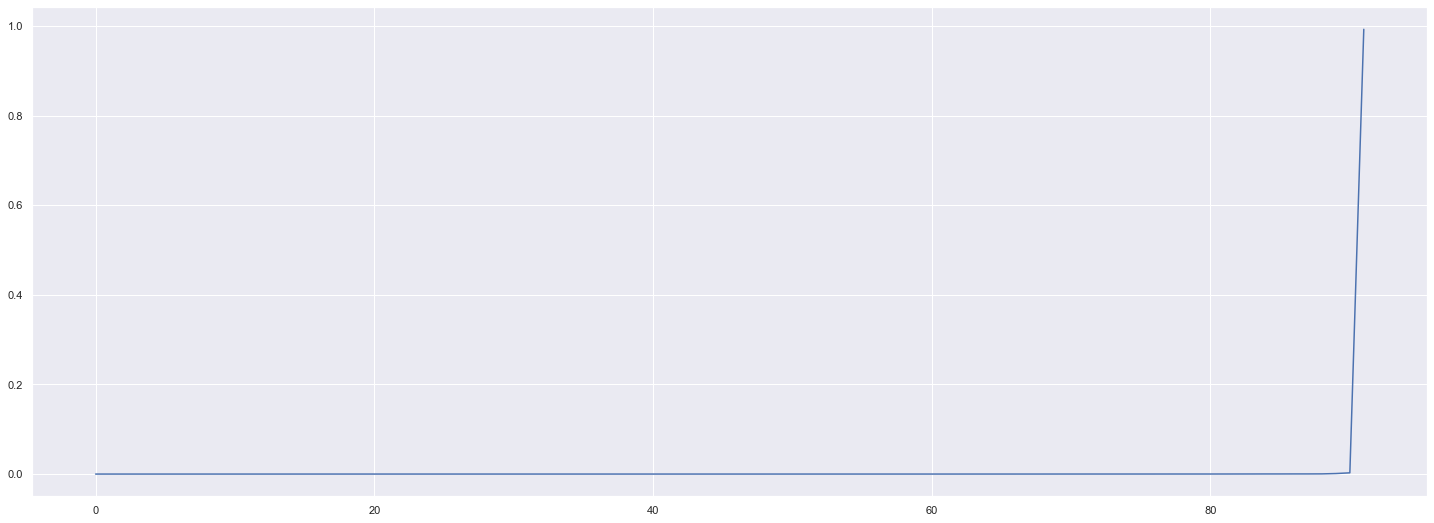

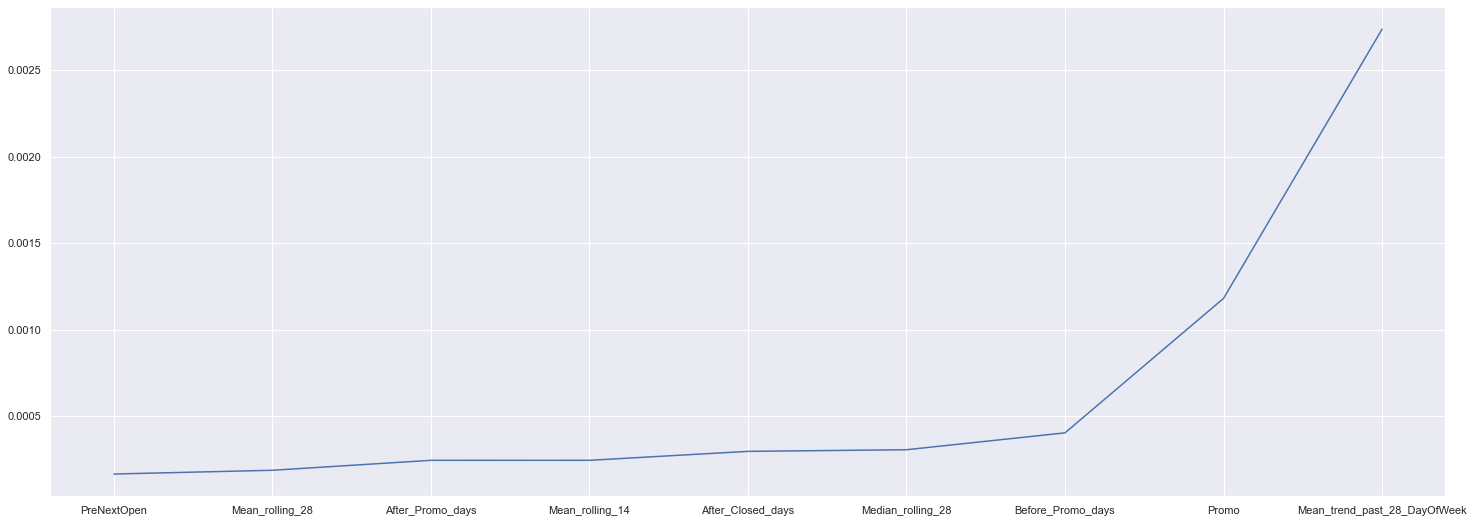

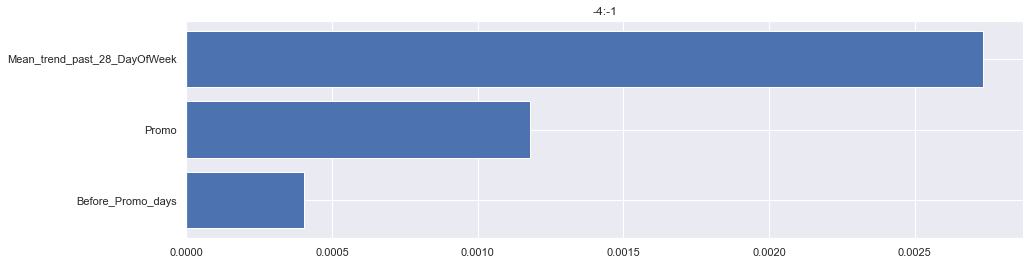

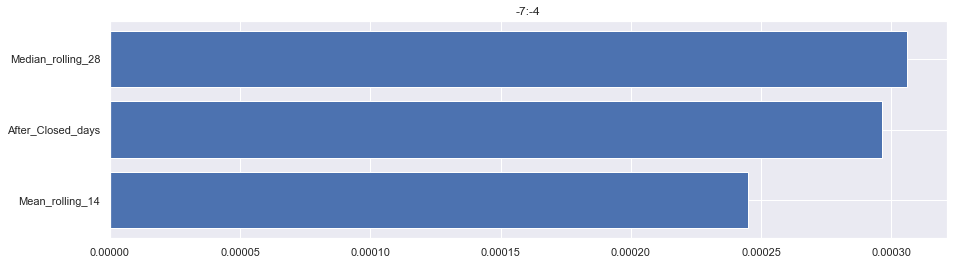

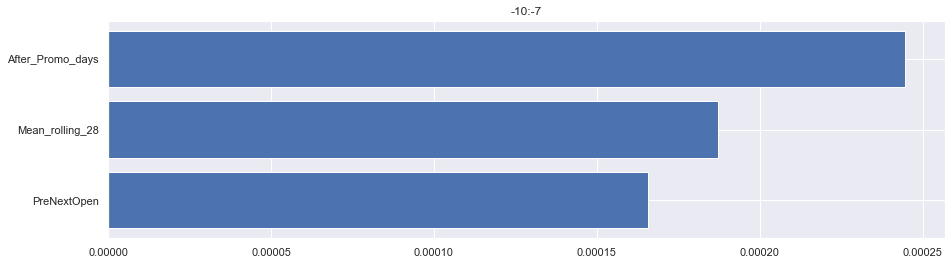

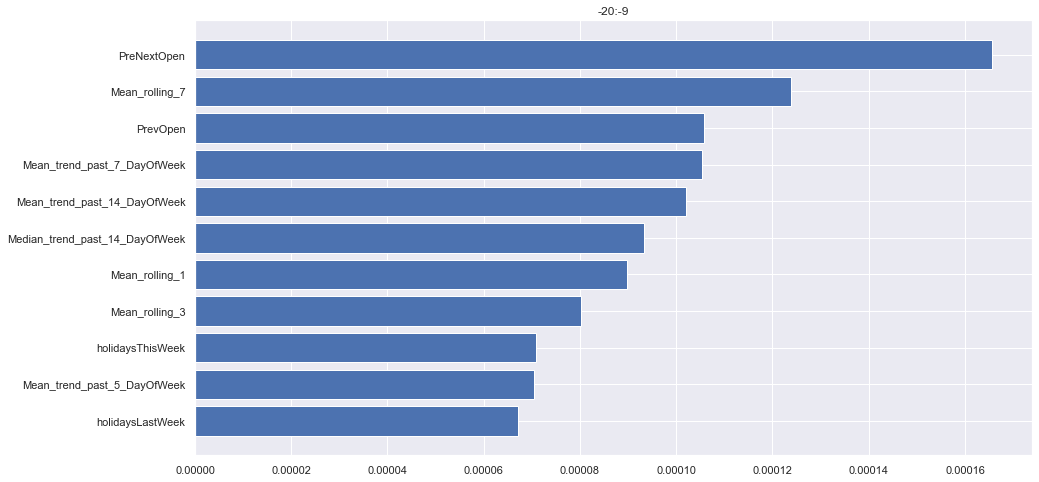

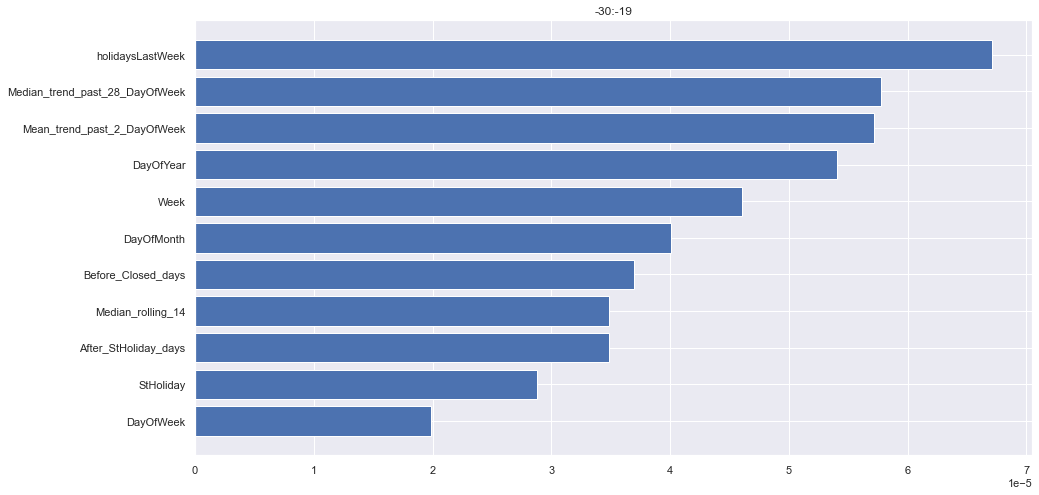

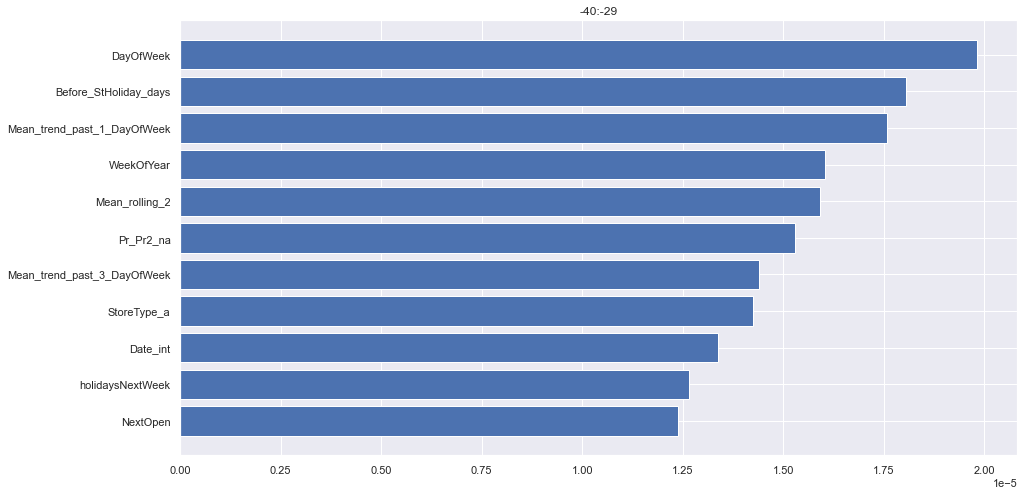

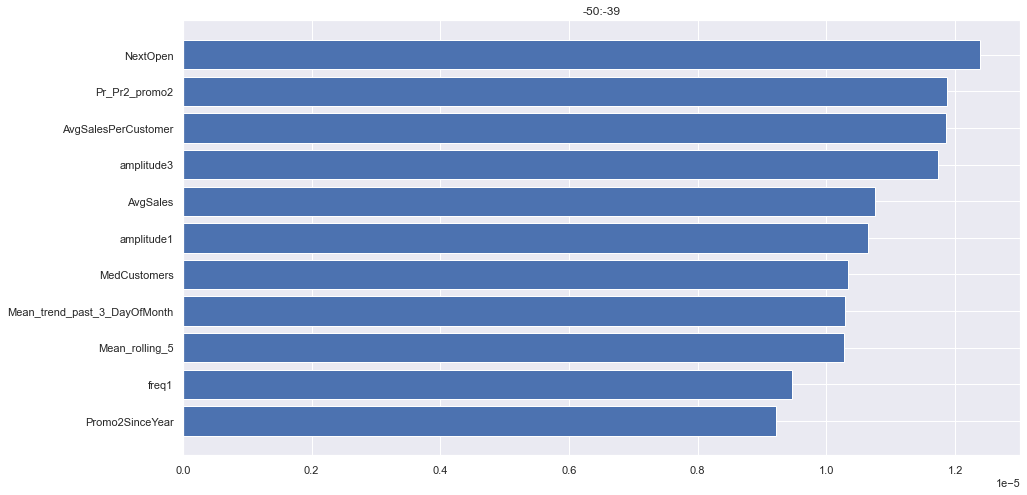

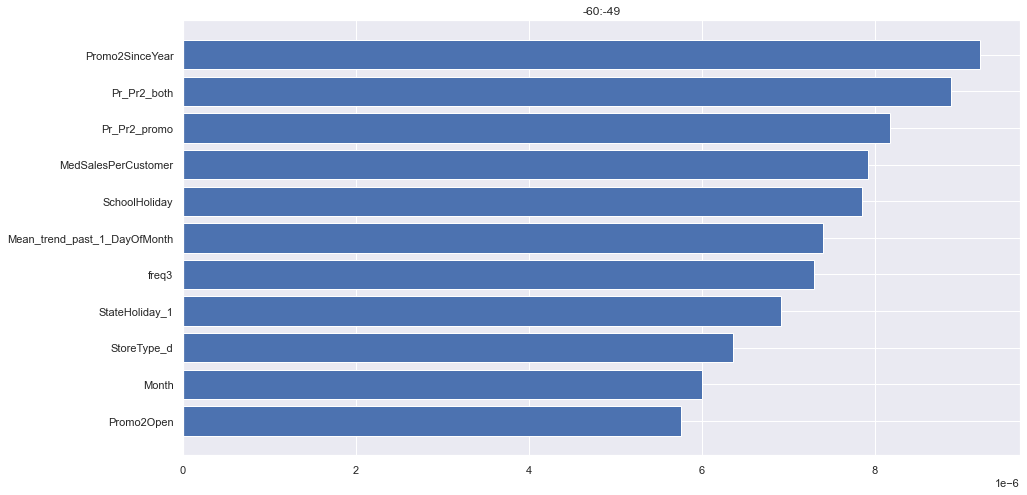

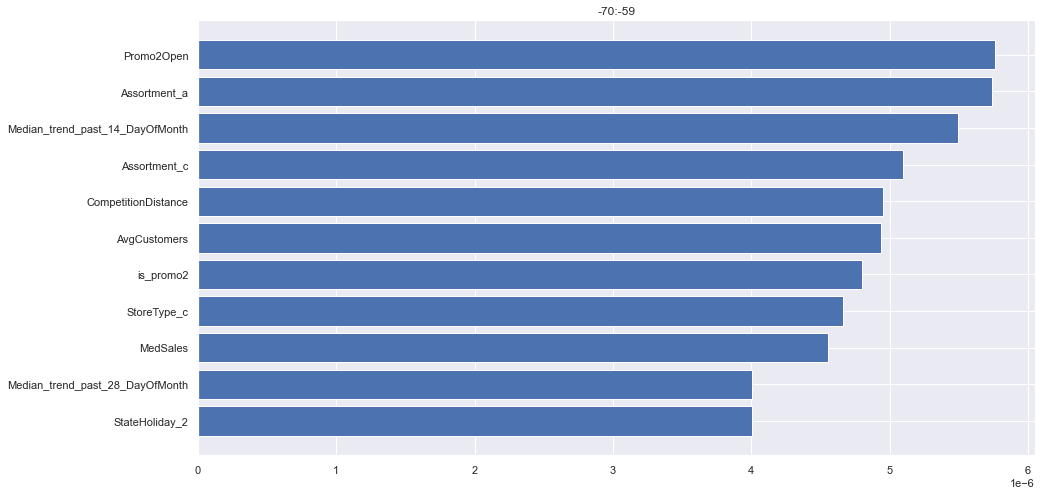

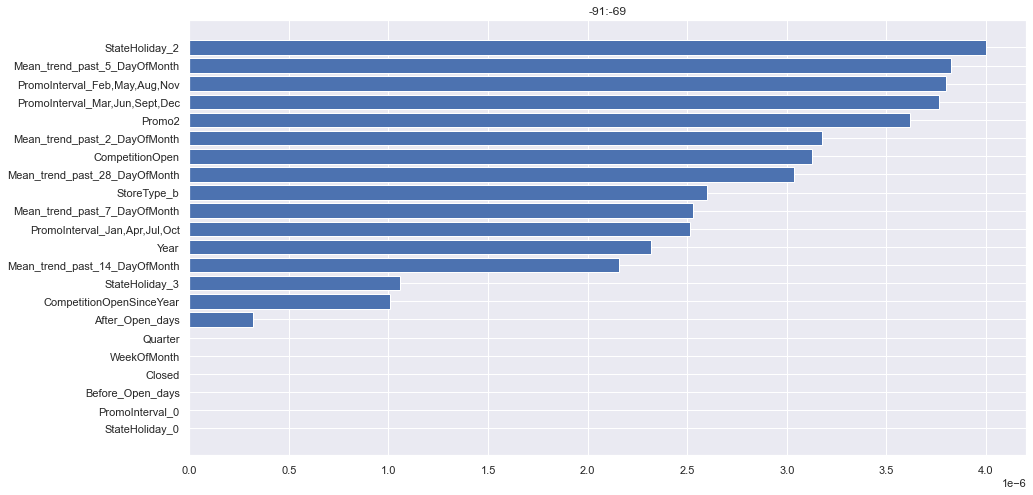

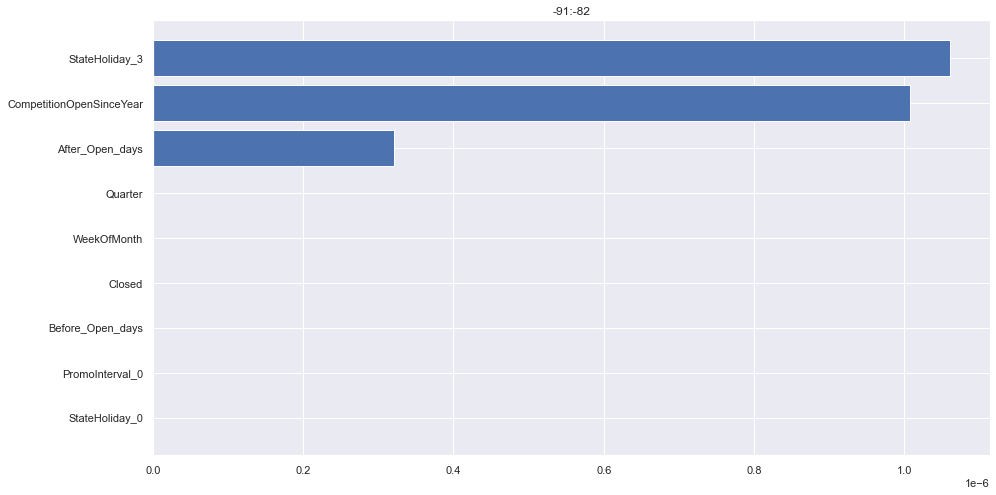

In [49]:
#12 Plotting top features obtained from xgb model trained above

import seaborn as sns

sorted_idx = xgbreg.feature_importances_.argsort()

sns.set(rc={'figure.figsize':(25,9)})
# plt.plot(X_train.columns.values[sorted_idx], xgbreg.feature_importances_[sorted_idx][-10:-1])
plt.plot(xgbreg.feature_importances_[sorted_idx])
plt.show()
sns.set(rc={'figure.figsize':(25,9)})
sns.lineplot(X_train.columns.values[sorted_idx][-10:-1], xgbreg.feature_importances_[sorted_idx][-10:-1])
plt.show()
sns.set(rc={'figure.figsize':(15,4)})
plt.title('-4:-1')
plt.barh(X_train.columns.values[sorted_idx][-4:-1], xgbreg.feature_importances_[sorted_idx][-4:-1])
plt.show()
sns.set(rc={'figure.figsize':(15,4)})
plt.title('-7:-4')
plt.barh(X_train.columns.values[sorted_idx][-7:-4], xgbreg.feature_importances_[sorted_idx][-7:-4])
plt.show()
sns.set(rc={'figure.figsize':(15,4)})
plt.title('-10:-7')
plt.barh(X_train.columns.values[sorted_idx][-10:-7], xgbreg.feature_importances_[sorted_idx][-10:-7])
plt.show()
sns.set(rc={'figure.figsize':(15,8)})
plt.title('-20:-9')
plt.barh(X_train.columns.values[sorted_idx][-20:-9], xgbreg.feature_importances_[sorted_idx][-20:-9])
plt.show()
plt.title('-30:-19')
plt.barh(X_train.columns.values[sorted_idx][-30:-19], xgbreg.feature_importances_[sorted_idx][-30:-19])
plt.show()
plt.title('-40:-29')
plt.barh(X_train.columns.values[sorted_idx][-40:-29], xgbreg.feature_importances_[sorted_idx][-40:-29])
plt.show()
plt.title('-50:-39')
plt.barh(X_train.columns.values[sorted_idx][-50:-39], xgbreg.feature_importances_[sorted_idx][-50:-39])
plt.show()
plt.title('-60:-49')
plt.barh(X_train.columns.values[sorted_idx][-60:-49], xgbreg.feature_importances_[sorted_idx][-60:-49])
plt.show()
plt.title('-70:-59')
plt.barh(X_train.columns.values[sorted_idx][-70:-59], xgbreg.feature_importances_[sorted_idx][-70:-59])
plt.show()
plt.title('-91:-69')
plt.barh(X_train.columns.values[sorted_idx][-91:-69], xgbreg.feature_importances_[sorted_idx][-91:-69])
plt.show()
plt.title('-91:-82')
plt.barh(X_train.columns.values[sorted_idx][-91:-82], xgbreg.feature_importances_[sorted_idx][-91:-82])
plt.show()

In [ ]:
#13 Fitting new model using top features extracted above

sorted_idx = xgbreg.feature_importances_.argsort()

trainset_ = trainset.drop(['Date'],axis=1).copy()
trainset_ = trainset_[~((trainset_.modZScoreOutliers==1) & (trainset_.Sales>0))]
trainset_.drop(['modZScoreOutliers'],axis=1,inplace=True)
trainset_ = pd.get_dummies(trainset_,columns = ['StateHoliday', 'StoreType', 'Assortment', 'Pr_Pr2','PromoInterval'])
trainset_['SalesLog'] = np.log1p(trainset_['Sales'])
trainset__ = trainset_.drop(['Store'],axis=1)

X_train_top_ = trainset__.drop(['SalesLog','Sales'],axis=1)
y_train_top_ = trainset__['SalesLog']

X_train_top__, X_test_top__, y_train_top__, y_test_top__ = train_test_split(X_train_top_,
                                                    y_train_top_,
                                                    test_size=0.1, random_state=40)

start = time.time()

# xgb
gc.collect() # Garbage collection
### Picking top features based on above plots. Customer# is absent in test set, thus we will drop it
top84Features = X_train.columns[xgbreg.feature_importances_.argsort()][-84:]
X_train_top__ = X_train_top__[top68Features]
X_test_top__ = X_test_top__[top68Features]
xgb_ = XGBRegressor()
xgbreg_ = xgb_.fit(X_train_top__, y_train_top__)
yhat_train = xgbreg_.predict(X_train_top__)
yhat_test = xgbreg_.predict(X_test_top__)
print("XGB Training RMSE", ":", rmse(y_train_top__, yhat_train))
print("XGB Testing RMSE", ":", rmse(y_test_top__, yhat_test))
print('Time taken: ', time.time()-start)

# Hyper parameterization on identified features

In [43]:
#14 Hyper parameterizing xgb model on top features found above
sorted_idx = xgbreg.feature_importances_.argsort()
x = list(X_train_.columns.values[sorted_idx][-84:])
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

# Define our search space for grid search
search_space = [
  {
      'learning_rate': [.01, .02, .03, 0.05, .07], #so called `eta` value
      'max_depth': [7, 9, 11, 12, 13, 14],
      'min_child_weight': [4, 6, 10],
      'subsample': [0.5, 0.7, 0.8],
      'colsample_bytree': [0.5, 0.7, 0.8],
      'n_estimators': [200]
  }
]

grid = RandomizedSearchCV(
  XGBRegressor(),
  param_distributions=search_space,
  cv=2,
  random_state = 40, 
  scoring="neg_mean_squared_error",
  n_iter=20,
)

trainset_ = trainset.drop(['Date'],axis=1).copy()
trainset_ = trainset_[~((trainset_.modZScoreOutliers==1) & (trainset_.Sales>0))]
trainset_.drop(['modZScoreOutliers'],axis=1,inplace=True)
trainset_ = pd.get_dummies(trainset_,columns = ['StateHoliday', 'StoreType', 'Assortment', 'Pr_Pr2','PromoInterval'])
trainset_['SalesLog'] = np.log1p(trainset_['Sales'])
trainset__ = trainset_.drop(['Store'],axis=1)

X_train_grid__ = trainset__.drop(['SalesLog','Sales'],axis=1)
y_train_grid__ = trainset__['SalesLog']

X_train_grid = X_train_grid__[top84Features]


# Fit grid search
model = grid.fit(X_train_grid, y_train_grid__)


print('Best Parameters: ',grid.best_params_, end ='\n\n')
cv_results =  model.cv_results_
score_dict = dict(zip(np.sqrt(-cv_results["mean_test_score"]), cv_results["params"]))


for rank,score in enumerate(sorted (score_dict.keys())) :    
    print(rank, ' rank has score: ',score)
    print('Parameters: ',score_dict[score])
    print()

Best Parameters:  {'subsample': 0.7, 'n_estimators': 200, 'min_child_weight': 10, 'max_depth': 14, 'learning_rate': 0.07, 'colsample_bytree': 0.7}

0  rank has score:  0.0978553694131436
Parameters:  {'subsample': 0.7, 'n_estimators': 200, 'min_child_weight': 10, 'max_depth': 14, 'learning_rate': 0.07, 'colsample_bytree': 0.7}

1  rank has score:  0.10060470350813935
Parameters:  {'subsample': 0.8, 'n_estimators': 200, 'min_child_weight': 10, 'max_depth': 11, 'learning_rate': 0.05, 'colsample_bytree': 0.5}

2  rank has score:  0.10093070645692936
Parameters:  {'subsample': 0.7, 'n_estimators': 200, 'min_child_weight': 6, 'max_depth': 11, 'learning_rate': 0.05, 'colsample_bytree': 0.7}

3  rank has score:  0.10126043829796572
Parameters:  {'subsample': 0.8, 'n_estimators': 200, 'min_child_weight': 6, 'max_depth': 11, 'learning_rate': 0.07, 'colsample_bytree': 0.5}

4  rank has score:  0.10192085289383092
Parameters:  {'subsample': 0.5, 'n_estimators': 200, 'min_child_weight': 4, 'max_de

In [53]:
#15 Picking best model obtained from hyper parameterization and using top features
xgb_1 = grid.best_estimator_
joblib.dump(xgb_1 , 'xgbR_hyperParameterized')

# Printing top 84 features found:
top84Features = X_train.columns[xgbreg.feature_importances_.argsort()][-84:]
print(top84Features)

Index(['CompetitionOpenSinceYear', 'StateHoliday_3',
       'Mean_trend_past_14_DayOfMonth', 'Year',
       'PromoInterval_Jan,Apr,Jul,Oct', 'Mean_trend_past_7_DayOfMonth',
       'StoreType_b', 'Mean_trend_past_28_DayOfMonth', 'CompetitionOpen',
       'Mean_trend_past_2_DayOfMonth', 'Promo2',
       'PromoInterval_Mar,Jun,Sept,Dec', 'PromoInterval_Feb,May,Aug,Nov',
       'Mean_trend_past_5_DayOfMonth', 'StateHoliday_2',
       'Median_trend_past_28_DayOfMonth', 'MedSales', 'StoreType_c',
       'is_promo2', 'AvgCustomers', 'CompetitionDistance', 'Assortment_c',
       'Median_trend_past_14_DayOfMonth', 'Assortment_a', 'Promo2Open',
       'Month', 'StoreType_d', 'StateHoliday_1', 'freq3',
       'Mean_trend_past_1_DayOfMonth', 'SchoolHoliday', 'MedSalesPerCustomer',
       'Pr_Pr2_promo', 'Pr_Pr2_both', 'Promo2SinceYear', 'freq1',
       'Mean_rolling_5', 'Mean_trend_past_3_DayOfMonth', 'MedCustomers',
       'amplitude1', 'AvgSales', 'amplitude3', 'AvgSalesPerCustomer',
       'Pr_

In [51]:
top68Features = X_train.columns[xgbreg.feature_importances_.argsort()][-68:]
top68Features

Index(['MedSales', 'StoreType_c', 'is_promo2', 'AvgCustomers',
       'CompetitionDistance', 'Assortment_c',
       'Median_trend_past_14_DayOfMonth', 'Assortment_a', 'Promo2Open',
       'Month', 'StoreType_d', 'StateHoliday_1', 'freq3',
       'Mean_trend_past_1_DayOfMonth', 'SchoolHoliday', 'MedSalesPerCustomer',
       'Pr_Pr2_promo', 'Pr_Pr2_both', 'Promo2SinceYear', 'freq1',
       'Mean_rolling_5', 'Mean_trend_past_3_DayOfMonth', 'MedCustomers',
       'amplitude1', 'AvgSales', 'amplitude3', 'AvgSalesPerCustomer',
       'Pr_Pr2_promo2', 'NextOpen', 'holidaysNextWeek', 'Date_int',
       'StoreType_a', 'Mean_trend_past_3_DayOfWeek', 'Pr_Pr2_na',
       'Mean_rolling_2', 'WeekOfYear', 'Mean_trend_past_1_DayOfWeek',
       'Before_StHoliday_days', 'DayOfWeek', 'StHoliday',
       'After_StHoliday_days', 'Median_rolling_14', 'Before_Closed_days',
       'DayOfMonth', 'Week', 'DayOfYear', 'Mean_trend_past_2_DayOfWeek',
       'Median_trend_past_28_DayOfWeek', 'holidaysLastWeek',
   

In [45]:
#15.1 Printing the model parameters of the best hyper parameterized model
xgb_1

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.07, max_delta_step=0, max_depth=14,
             min_child_weight=10, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [55]:
#16 Training model with best found hyper parameters and top features for several iterations until no improvement found
import xgboost as xgb

params = {'base_score': 0.5,
          "eta": 0.07,   # learning rate
          "max_depth": 14,    # maximum depth of a tree
          "subsample": 0.9,    # Subsample ratio of the training instances
          "colsample_bytree": 0.7,   # Subsample ratio of columns when constructing each tree
          "min_child_weight": 10,
          "seed": 10   # Random number seed
          }
num_boost_round = 4000

X_train_best, X_test_best, y_train_best, y_test_best = train_test_split(X_train_grid,
                                                    y_train_grid__,
                                                    test_size=0.3, random_state=40)

dtrain = xgb.DMatrix(X_train_best, y_train_best)
dcv = xgb.DMatrix(X_test_best, y_test_best)
watchlist = [(dtrain, 'train'), (dcv, 'validation')]
# train the xgboost model
model = xgb.train(params, dtrain, num_boost_round, evals=watchlist, \
  early_stopping_rounds= 50, verbose_eval=True)

dtrain_pred = xgb.DMatrix(X_train_best)
yhat_train = model.predict(dtrain_pred)
print("XGB Training RMSE", ":", rmse(y_train_best, yhat_train))
dcv_pred = xgb.DMatrix(X_test_best)
yhat_train = model.predict(dcv_pred)
print("XGB Training RMSE", ":", rmse(y_test_best, yhat_train))

# Saving the trained model
joblib.dump(model , 'trained_xgbmodel')

[0]	train-rmse:7.00299	validation-rmse:7.00534
[1]	train-rmse:6.51308	validation-rmse:6.51487
[2]	train-rmse:6.05768	validation-rmse:6.05937
[3]	train-rmse:5.63394	validation-rmse:5.63535
[4]	train-rmse:5.23941	validation-rmse:5.24139
[5]	train-rmse:4.87345	validation-rmse:4.87485
[6]	train-rmse:4.53258	validation-rmse:4.53370
[7]	train-rmse:4.21578	validation-rmse:4.21683
[8]	train-rmse:3.92101	validation-rmse:3.92188
[9]	train-rmse:3.64663	validation-rmse:3.64784
[10]	train-rmse:3.39205	validation-rmse:3.39289
[11]	train-rmse:3.15495	validation-rmse:3.15565
[12]	train-rmse:2.93456	validation-rmse:2.93513
[13]	train-rmse:2.72961	validation-rmse:2.73014
[14]	train-rmse:2.53884	validation-rmse:2.53955
[15]	train-rmse:2.36177	validation-rmse:2.36224
[16]	train-rmse:2.19688	validation-rmse:2.19725
[17]	train-rmse:2.04362	validation-rmse:2.04391
[18]	train-rmse:1.90113	validation-rmse:1.90141
[19]	train-rmse:1.76856	validation-rmse:1.76894
[20]	train-rmse:1.64545	validation-rmse:1.64568
[2

[170]	train-rmse:0.06985	validation-rmse:0.08980
[171]	train-rmse:0.06958	validation-rmse:0.08972
[172]	train-rmse:0.06946	validation-rmse:0.08969
[173]	train-rmse:0.06936	validation-rmse:0.08967
[174]	train-rmse:0.06922	validation-rmse:0.08963
[175]	train-rmse:0.06916	validation-rmse:0.08962
[176]	train-rmse:0.06899	validation-rmse:0.08954
[177]	train-rmse:0.06891	validation-rmse:0.08952
[178]	train-rmse:0.06883	validation-rmse:0.08952
[179]	train-rmse:0.06876	validation-rmse:0.08951
[180]	train-rmse:0.06868	validation-rmse:0.08951
[181]	train-rmse:0.06865	validation-rmse:0.08951
[182]	train-rmse:0.06856	validation-rmse:0.08951
[183]	train-rmse:0.06853	validation-rmse:0.08950
[184]	train-rmse:0.06849	validation-rmse:0.08949
[185]	train-rmse:0.06820	validation-rmse:0.08940
[186]	train-rmse:0.06804	validation-rmse:0.08932
[187]	train-rmse:0.06798	validation-rmse:0.08932
[188]	train-rmse:0.06791	validation-rmse:0.08930
[189]	train-rmse:0.06787	validation-rmse:0.08930
[190]	train-rmse:0.0

[338]	train-rmse:0.05651	validation-rmse:0.08760
[339]	train-rmse:0.05645	validation-rmse:0.08760
[340]	train-rmse:0.05638	validation-rmse:0.08760
[341]	train-rmse:0.05635	validation-rmse:0.08760
[342]	train-rmse:0.05629	validation-rmse:0.08759
[343]	train-rmse:0.05624	validation-rmse:0.08759
[344]	train-rmse:0.05622	validation-rmse:0.08759
[345]	train-rmse:0.05618	validation-rmse:0.08759
[346]	train-rmse:0.05608	validation-rmse:0.08758
[347]	train-rmse:0.05603	validation-rmse:0.08758
[348]	train-rmse:0.05597	validation-rmse:0.08758
[349]	train-rmse:0.05589	validation-rmse:0.08757
[350]	train-rmse:0.05586	validation-rmse:0.08757
[351]	train-rmse:0.05582	validation-rmse:0.08757
[352]	train-rmse:0.05581	validation-rmse:0.08756
[353]	train-rmse:0.05571	validation-rmse:0.08755
[354]	train-rmse:0.05567	validation-rmse:0.08755
[355]	train-rmse:0.05562	validation-rmse:0.08755
[356]	train-rmse:0.05559	validation-rmse:0.08755
[357]	train-rmse:0.05557	validation-rmse:0.08754
[358]	train-rmse:0.0

[506]	train-rmse:0.04863	validation-rmse:0.08707
[507]	train-rmse:0.04855	validation-rmse:0.08707
[508]	train-rmse:0.04848	validation-rmse:0.08707
[509]	train-rmse:0.04844	validation-rmse:0.08707
[510]	train-rmse:0.04836	validation-rmse:0.08707
[511]	train-rmse:0.04832	validation-rmse:0.08706
[512]	train-rmse:0.04828	validation-rmse:0.08706
[513]	train-rmse:0.04825	validation-rmse:0.08706
[514]	train-rmse:0.04823	validation-rmse:0.08706
[515]	train-rmse:0.04819	validation-rmse:0.08706
[516]	train-rmse:0.04816	validation-rmse:0.08706
[517]	train-rmse:0.04812	validation-rmse:0.08706
[518]	train-rmse:0.04808	validation-rmse:0.08706
[519]	train-rmse:0.04805	validation-rmse:0.08706
[520]	train-rmse:0.04802	validation-rmse:0.08706
[521]	train-rmse:0.04800	validation-rmse:0.08706
[522]	train-rmse:0.04799	validation-rmse:0.08706
[523]	train-rmse:0.04797	validation-rmse:0.08706
[524]	train-rmse:0.04791	validation-rmse:0.08706
[525]	train-rmse:0.04786	validation-rmse:0.08705
[526]	train-rmse:0.0

[674]	train-rmse:0.04259	validation-rmse:0.08684
[675]	train-rmse:0.04256	validation-rmse:0.08684
[676]	train-rmse:0.04251	validation-rmse:0.08684
[677]	train-rmse:0.04244	validation-rmse:0.08684
[678]	train-rmse:0.04240	validation-rmse:0.08684
[679]	train-rmse:0.04240	validation-rmse:0.08684
[680]	train-rmse:0.04235	validation-rmse:0.08684
[681]	train-rmse:0.04231	validation-rmse:0.08684
[682]	train-rmse:0.04226	validation-rmse:0.08684
[683]	train-rmse:0.04224	validation-rmse:0.08684
[684]	train-rmse:0.04220	validation-rmse:0.08684
[685]	train-rmse:0.04217	validation-rmse:0.08683
[686]	train-rmse:0.04208	validation-rmse:0.08683
[687]	train-rmse:0.04203	validation-rmse:0.08682
[688]	train-rmse:0.04200	validation-rmse:0.08682
[689]	train-rmse:0.04197	validation-rmse:0.08682
[690]	train-rmse:0.04195	validation-rmse:0.08682
[691]	train-rmse:0.04191	validation-rmse:0.08682
[692]	train-rmse:0.04189	validation-rmse:0.08682
[693]	train-rmse:0.04186	validation-rmse:0.08682
[694]	train-rmse:0.0

[842]	train-rmse:0.03717	validation-rmse:0.08672
[843]	train-rmse:0.03716	validation-rmse:0.08672
[844]	train-rmse:0.03714	validation-rmse:0.08672
[845]	train-rmse:0.03711	validation-rmse:0.08671
[846]	train-rmse:0.03710	validation-rmse:0.08671
[847]	train-rmse:0.03708	validation-rmse:0.08671
[848]	train-rmse:0.03706	validation-rmse:0.08671
[849]	train-rmse:0.03703	validation-rmse:0.08671
[850]	train-rmse:0.03703	validation-rmse:0.08671
[851]	train-rmse:0.03700	validation-rmse:0.08671
[852]	train-rmse:0.03698	validation-rmse:0.08671
[853]	train-rmse:0.03694	validation-rmse:0.08671
[854]	train-rmse:0.03692	validation-rmse:0.08671
[855]	train-rmse:0.03687	validation-rmse:0.08671
[856]	train-rmse:0.03683	validation-rmse:0.08671
[857]	train-rmse:0.03678	validation-rmse:0.08671
[858]	train-rmse:0.03675	validation-rmse:0.08671
[859]	train-rmse:0.03674	validation-rmse:0.08671
[860]	train-rmse:0.03671	validation-rmse:0.08671
[861]	train-rmse:0.03667	validation-rmse:0.08671
[862]	train-rmse:0.0

[1010]	train-rmse:0.03284	validation-rmse:0.08663
[1011]	train-rmse:0.03283	validation-rmse:0.08663
[1012]	train-rmse:0.03281	validation-rmse:0.08663
[1013]	train-rmse:0.03279	validation-rmse:0.08663
[1014]	train-rmse:0.03277	validation-rmse:0.08663
[1015]	train-rmse:0.03275	validation-rmse:0.08663
[1016]	train-rmse:0.03274	validation-rmse:0.08663
[1017]	train-rmse:0.03272	validation-rmse:0.08663
[1018]	train-rmse:0.03270	validation-rmse:0.08663
[1019]	train-rmse:0.03269	validation-rmse:0.08663
[1020]	train-rmse:0.03266	validation-rmse:0.08663
[1021]	train-rmse:0.03265	validation-rmse:0.08663
[1022]	train-rmse:0.03263	validation-rmse:0.08663
[1023]	train-rmse:0.03261	validation-rmse:0.08663
[1024]	train-rmse:0.03257	validation-rmse:0.08663
[1025]	train-rmse:0.03253	validation-rmse:0.08663
[1026]	train-rmse:0.03251	validation-rmse:0.08663
[1027]	train-rmse:0.03249	validation-rmse:0.08663
[1028]	train-rmse:0.03246	validation-rmse:0.08663
[1029]	train-rmse:0.03244	validation-rmse:0.08663


[1174]	train-rmse:0.02933	validation-rmse:0.08660
[1175]	train-rmse:0.02932	validation-rmse:0.08660
[1176]	train-rmse:0.02929	validation-rmse:0.08660
[1177]	train-rmse:0.02924	validation-rmse:0.08660
[1178]	train-rmse:0.02923	validation-rmse:0.08660
[1179]	train-rmse:0.02922	validation-rmse:0.08660
[1180]	train-rmse:0.02921	validation-rmse:0.08660
[1181]	train-rmse:0.02918	validation-rmse:0.08660
[1182]	train-rmse:0.02915	validation-rmse:0.08660
[1183]	train-rmse:0.02915	validation-rmse:0.08660
[1184]	train-rmse:0.02912	validation-rmse:0.08660
[1185]	train-rmse:0.02911	validation-rmse:0.08660
[1186]	train-rmse:0.02909	validation-rmse:0.08660
[1187]	train-rmse:0.02905	validation-rmse:0.08660
[1188]	train-rmse:0.02903	validation-rmse:0.08660
[1189]	train-rmse:0.02900	validation-rmse:0.08659
[1190]	train-rmse:0.02899	validation-rmse:0.08660
[1191]	train-rmse:0.02895	validation-rmse:0.08659
[1192]	train-rmse:0.02892	validation-rmse:0.08659
[1193]	train-rmse:0.02890	validation-rmse:0.08659


[1338]	train-rmse:0.02618	validation-rmse:0.08657
[1339]	train-rmse:0.02617	validation-rmse:0.08657
[1340]	train-rmse:0.02614	validation-rmse:0.08657
[1341]	train-rmse:0.02613	validation-rmse:0.08657
[1342]	train-rmse:0.02612	validation-rmse:0.08657
[1343]	train-rmse:0.02610	validation-rmse:0.08657
[1344]	train-rmse:0.02607	validation-rmse:0.08657
[1345]	train-rmse:0.02605	validation-rmse:0.08657
[1346]	train-rmse:0.02604	validation-rmse:0.08657
[1347]	train-rmse:0.02602	validation-rmse:0.08657
[1348]	train-rmse:0.02600	validation-rmse:0.08657
[1349]	train-rmse:0.02597	validation-rmse:0.08657
[1350]	train-rmse:0.02595	validation-rmse:0.08657
[1351]	train-rmse:0.02593	validation-rmse:0.08657
[1352]	train-rmse:0.02591	validation-rmse:0.08657
[1353]	train-rmse:0.02588	validation-rmse:0.08657
[1354]	train-rmse:0.02586	validation-rmse:0.08657
[1355]	train-rmse:0.02584	validation-rmse:0.08657
[1356]	train-rmse:0.02582	validation-rmse:0.08657
[1357]	train-rmse:0.02581	validation-rmse:0.08657


['trained_xgbmodel']

In [56]:
#17 Predicting test set

new_testset = testset.copy()

# Preparing dataset
# new_testset = new_testset.drop(['Date','Id'],axis=1).copy()
# new_testset = new_testset.drop('SalesPerCustomer',axis=1).copy()
new_testset = pd.get_dummies(new_testset,columns = ['StateHoliday', 'StoreType', 'Assortment', 'Pr_Pr2','PromoInterval'])


new_testset.loc[new_testset.Open.isna(),'Open']=1 # Replacing 11 nan spots with Open=1
# new_testset.drop(['Sales','Id','Open'],axis=1,inplace=True)
new_testset.sort_values(['Date_int','Store'],inplace=True)
new_testset.drop(['Store'],axis=1,inplace=True)
new_x_set_ = trainset_.copy()
new_x_set_.sort_values(['Date_int','Store'],inplace=True)
new_x_set_.drop(['Store','SalesLog'],axis=1,inplace=True)
window_list = [1,2,3,5,7,14,28]

for doy in range(213,261): # test set ranges from 213rd DayOfYear to 260th in the year 2015
    df_temp = new_testset[new_testset.DayOfYear==doy].copy() # Getting df pertaining to all stores which were working on this specific DayOfYear
    new_df = rolling_trend_sales_window(df_temp, new_x_set_, window_list) # Getting rolling averages and trend-wise averages across different window sizes for all stores
    new_x_set_ = new_x_set_.append(new_df) # Appending above new_df having all data of all stores for the specific day
    df_temp = new_x_set_.loc[(new_x_set_.Year==2015) & (new_x_set_.DayOfYear==doy)].drop(['Sales','Date','Id'],axis=1) # Re-using earlier variable space i.e. df_temp although this is supposed to be a new variable
    df_temp = df_temp[top84Features]
    df_temp = xgb.DMatrix(df_temp)
    yhat = model.predict(df_temp)
    ypred_bst = np.exp(yhat) - 1
    new_x_set_.loc[(new_x_set_.Year==2015) & (new_x_set_.DayOfYear==doy),'Sales'] = ypred_bst
    display(new_x_set_.tail())
    
new_x_set_.Sales.fillna(0,inplace=True)

,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceYear,Promo2,Promo2SinceYear,StHoliday,DayOfMonth,Week,Month,Year,DayOfYear,WeekOfYear,Quarter,WeekOfMonth,is_promo2,CompetitionOpen,Promo2Open,Date_int,Closed,AvgSales,AvgCustomers,AvgSalesPerCustomer,MedSales,MedCustomers,MedSalesPerCustomer,PrevOpen,NextOpen,PreNextOpen,amplitude1,amplitude3,freq1,freq3,holidaysThisWeek,holidaysLastWeek,holidaysNextWeek,Before_Promo_days,After_Promo_days,Before_Closed_days,After_Closed_days,Before_Open_days,After_Open_days,Before_StHoliday_days,After_StHoliday_days,Mean_rolling_1,Mean_trend_past_1_DayOfWeek,Mean_trend_past_1_DayOfMonth,Mean_rolling_2,Mean_trend_past_2_DayOfWeek,Mean_trend_past_2_DayOfMonth,Mean_rolling_3,Mean_trend_past_3_DayOfWeek,Mean_trend_past_3_DayOfMonth,Mean_rolling_5,Mean_trend_past_5_DayOfWeek,Mean_trend_past_5_DayOfMonth,Mean_rolling_7,Mean_trend_past_7_DayOfWeek,Mean_trend_past_7_DayOfMonth,Mean_rolling_14,Median_rolling_14,Mean_trend_past_14_DayOfWeek,Median_trend_past_14_DayOfWeek,Mean_trend_past_14_DayOfMonth,Median_trend_past_14_DayOfMonth,Mean_rolling_28,Median_rolling_28,Mean_trend_past_28_DayOfWeek,Median_trend_past_28_DayOfWeek,Mean_trend_past_28_DayOfMonth,Median_trend_past_28_DayOfMonth,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,Pr_Pr2_both,Pr_Pr2_na,Pr_Pr2_promo,Pr_Pr2_promo2,PromoInterval_0,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",Date,Id
851,6,2789.271484,NaN,1.0,0,0,1900.0,2014.0,1,2013.0,0,1,31,8,2015,213,30.0,3,1,0,14.0,23.75,1438387200000000000,0,4342.968153,373.548832,11.547388,4614.0,431.0,11.550661,1.0,0.0,1,8.464943e+05,6.133019e+05,-0.285563,0.143312,1.0,1.0,1.0,2,1,1,6,0,0,48,58,5723.0,2177.0,3701.0,5493.0,2399.5,5906.0,5297.666667,2480.000000,3937.333333,6085.6,2615.2,3326.8,4657.857143,2664.857143,2376.285714,3966.500000,4171.0,2799.714286,2732.0,3494.214286,4204.0,3911.428571,4109.0,2868.142857,2812.5,3053.214286,3279.0,1,0,NaN,NaN,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,2015-08-01,41084.0
852,6,7499.748535,NaN,1.0,0,0,1880.0,2006.0,0,2015.0,0,1,31,8,2015,213,30.0,3,1,0,112.0,-1.00,1438387200000000000,0,8465.280255,693.498938,11.993853,8707.0,755.0,11.765432,1.0,0.0,1,1.485865e+06,1.296861e+06,-0.285563,0.428875,1.0,1.0,1.0,2,1,1,6,0,0,48,58,9626.0,6216.0,10620.0,9639.0,6552.0,14081.0,9485.666667,6503.000000,9387.333333,10484.6,6775.8,8410.6,8377.000000,7204.714286,6007.571429,7060.428571,6809.0,7904.142857,8184.0,7513.785714,10339.0,7118.571429,6957.0,7936.500000,8040.0,6437.678571,8869.0,1,0,NaN,NaN,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,2015-08-01,41085.0
853,6,5903.746094,NaN,1.0,0,0,9260.0,1900.0,0,2015.0,0,1,31,8,2015,213,30.0,3,1,0,1387.0,-1.00,1438387200000000000,0,5516.180467,596.763270,9.211189,6018.5,675.5,9.163448,1.0,0.0,1,8.554533e+05,7.631429e+05,0.285563,-0.428875,1.0,1.0,1.0,2,1,1,6,0,0,48,68,7289.0,4784.0,8222.0,7390.0,5090.0,8581.5,7140.000000,5280.000000,5721.000000,7094.0,5505.2,5531.4,5750.571429,5437.571429,3951.000000,5299.714286,6375.0,5907.214286,5647.0,5469.714286,7227.5,5643.392857,6380.0,5953.321429,5713.0,4700.000000,5987.0,1,0,NaN,NaN,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,2015-08-01,41086.0
854,6,23386.691406,NaN,1.0,0,0,870.0,1900.0,0,2015.0,0,1,31,8,2015,213,30.0,3,1,0,1387.0,-1.00,1438387200000000000,0,17200.196391,2664.057325,6.454992,19556.5,3086.0,6.427373,1.0,0.0,1,2.875098e+06,2.578631e+06,0.285563,0.428875,1.0,1.0,1.0,2,1,1,6,0,0,48,68,27508.0,21312.0,27071.0,25951.5,22074.0,27137.0,25914.333333,22080.000000,18091.333333,25996.2,21312.0,16544.0,21613.285714,21604.714286,11817.142857,19981.714286,22074.0,23069.142857,22457.0,16234.071429,22904.0,19673.892857,21826.0,22760.285714,22353.5,14616.821429,21798.0,1,0,NaN,NaN,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,2015-08-01,41087.0
855,6,7954.766113,NaN,1.0,0,1,5350.0,1900.0,1,2012.0,0,1,31,8,2015,213,30.0,3,1,0,1387.0,38.00,1438387200000000000

,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceYear,Promo2,Promo2SinceYear,StHoliday,DayOfMonth,Week,Month,Year,DayOfYear,WeekOfYear,Quarter,WeekOfMonth,is_promo2,CompetitionOpen,Promo2Open,Date_int,Closed,AvgSales,AvgCustomers,AvgSalesPerCustomer,MedSales,MedCustomers,MedSalesPerCustomer,PrevOpen,NextOpen,PreNextOpen,amplitude1,amplitude3,freq1,freq3,holidaysThisWeek,holidaysLastWeek,holidaysNextWeek,Before_Promo_days,After_Promo_days,Before_Closed_days,After_Closed_days,Before_Open_days,After_Open_days,Before_StHoliday_days,After_StHoliday_days,Mean_rolling_1,Mean_trend_past_1_DayOfWeek,Mean_trend_past_1_DayOfMonth,Mean_rolling_2,Mean_trend_past_2_DayOfWeek,Mean_trend_past_2_DayOfMonth,Mean_rolling_3,Mean_trend_past_3_DayOfWeek,Mean_trend_past_3_DayOfMonth,Mean_rolling_5,Mean_trend_past_5_DayOfWeek,Mean_trend_past_5_DayOfMonth,Mean_rolling_7,Mean_trend_past_7_DayOfWeek,Mean_trend_past_7_DayOfMonth,Mean_rolling_14,Median_rolling_14,Mean_trend_past_14_DayOfWeek,Median_trend_past_14_DayOfWeek,Mean_trend_past_14_DayOfMonth,Median_trend_past_14_DayOfMonth,Mean_rolling_28,Median_rolling_28,Mean_trend_past_28_DayOfWeek,Median_trend_past_28_DayOfWeek,Mean_trend_past_28_DayOfMonth,Median_trend_past_28_DayOfMonth,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,Pr_Pr2_both,Pr_Pr2_na,Pr_Pr2_promo,Pr_Pr2_promo2,PromoInterval_0,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",Date,Id
851,0,0.020976,NaN,0.0,0,0,1900.0,2014.0,1,2013.0,0,2,31,8,2015,214,31.0,3,1,0,14.0,24.00,1438473600000000000,1,4342.968153,373.548832,11.547388,4614.0,431.0,11.550661,1.0,1.0,0,8.464943e+05,6.133019e+05,-0.285563,0.143312,1.0,1.0,1.0,1,2,0,0,1,1,47,59,2789.271484,0.0,3945.0,4256.135742,0.0,5351.5,4591.757161,0.0,4743.666667,5095.054297,0.0,5684.6,4745.324498,0.0,5737.142857,3978.447963,4171.000000,0.0,0.0,5516.214286,5694.0,3918.402553,4109.000000,0.0,0.0,5244.857143,5531.5,1,0,NaN,NaN,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,2015-08-02,40228.0
852,0,-0.010489,NaN,0.0,0,0,1880.0,2006.0,0,2015.0,0,2,31,8,2015,214,31.0,3,1,0,112.0,-1.00,1438473600000000000,1,8465.280255,693.498938,11.993853,8707.0,755.0,11.765432,1.0,1.0,0,1.485865e+06,1.296861e+06,-0.285563,0.428875,1.0,1.0,1.0,1,2,0,0,1,1,47,59,7499.748535,0.0,7447.0,8562.874268,0.0,10026.0,8925.916178,0.0,9951.666667,9107.949707,0.0,11705.6,8560.392648,0.0,11608.142857,7104.124895,7114.874268,0.0,0.0,10958.071429,11454.5,7177.955305,7262.874268,0.0,0.0,10223.392857,10621.5,1,0,NaN,NaN,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,2015-08-02,40229.0
853,0,-0.013792,NaN,0.0,0,0,9260.0,1900.0,0,2015.0,0,2,31,8,2015,214,31.0,3,1,0,1387.0,-1.00,1438473600000000000,1,5516.180467,596.763270,9.211189,6018.5,675.5,9.163448,1.0,1.0,0,8.554533e+05,7.631429e+05,0.285563,-0.428875,1.0,1.0,1.0,1,2,0,0,1,1,47,69,5903.746094,0.0,7932.0,6596.373047,0.0,7854.5,6894.582031,0.0,7915.333333,6758.349219,0.0,7922.4,5910.535156,0.0,7850.428571,5335.981864,6375.000000,0.0,0.0,7347.071429,7864.5,5663.526646,6380.000000,0.0,0.0,6376.821429,7106.0,1,0,NaN,NaN,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,2015-08-02,40230.0
854,0,-0.011376,NaN,0.0,0,0,870.0,1900.0,0,2015.0,0,2,31,8,2015,214,31.0,3,1,0,1387.0,-1.00,1438473600000000000,1,17200.196391,2664.057325,6.454992,19556.5,3086.0,6.427373,1.0,1.0,0,2.875098e+06,2.578631e+06,0.285563,0.428875,1.0,1.0,1.0,1,2,0,0,1,1,47,69,23386.691406,0.0,24898.0,25447.345703,0.0,24953.5,25096.563802,0.0,27117.333333,25329.538281,0.0,27467.2,21909.670201,0.0,26284.857143,20021.049386,22349.345703,0.0,0.0,23093.928571,24125.5,19847.381836,22464.000000,0.0,0.0,20718.000000,22838.0,1,0,NaN,NaN,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,2015-08-02,40231.0
855,0,-0.010655,NaN,0.0,0,1,5350.0,1900.0,1,2012.0,0,2,31,8,2015,214,31.0,3,1,0,1387.0,38.25,1438473600000000000,1,5225.296178,358.687898,14.415954,5671.0,401.0,14.401198,1.0,1.0,0,9.095603e+05,8.370077e+05,-0.285563,-

,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceYear,Promo2,Promo2SinceYear,StHoliday,DayOfMonth,Week,Month,Year,DayOfYear,WeekOfYear,Quarter,WeekOfMonth,is_promo2,CompetitionOpen,Promo2Open,Date_int,Closed,AvgSales,AvgCustomers,AvgSalesPerCustomer,MedSales,MedCustomers,MedSalesPerCustomer,PrevOpen,NextOpen,PreNextOpen,amplitude1,amplitude3,freq1,freq3,holidaysThisWeek,holidaysLastWeek,holidaysNextWeek,Before_Promo_days,After_Promo_days,Before_Closed_days,After_Closed_days,Before_Open_days,After_Open_days,Before_StHoliday_days,After_StHoliday_days,Mean_rolling_1,Mean_trend_past_1_DayOfWeek,Mean_trend_past_1_DayOfMonth,Mean_rolling_2,Mean_trend_past_2_DayOfWeek,Mean_trend_past_2_DayOfMonth,Mean_rolling_3,Mean_trend_past_3_DayOfWeek,Mean_trend_past_3_DayOfMonth,Mean_rolling_5,Mean_trend_past_5_DayOfWeek,Mean_trend_past_5_DayOfMonth,Mean_rolling_7,Mean_trend_past_7_DayOfWeek,Mean_trend_past_7_DayOfMonth,Mean_rolling_14,Median_rolling_14,Mean_trend_past_14_DayOfWeek,Median_trend_past_14_DayOfWeek,Mean_trend_past_14_DayOfMonth,Median_trend_past_14_DayOfMonth,Mean_rolling_28,Median_rolling_28,Mean_trend_past_28_DayOfWeek,Median_trend_past_28_DayOfWeek,Mean_trend_past_28_DayOfMonth,Median_trend_past_28_DayOfMonth,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,Pr_Pr2_both,Pr_Pr2_na,Pr_Pr2_promo,Pr_Pr2_promo2,PromoInterval_0,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",Date,Id
851,1,7941.098145,NaN,1.0,1,1,1900.0,2014.0,1,2013.0,0,3,32,8,2015,215,31.0,3,1,0,14.0,24.00,1438560000000000000,0,4342.968153,373.548832,11.547388,4614.0,431.0,11.550661,0.0,1.0,1,8.464943e+05,6.133019e+05,-0.285563,0.143312,1.0,1.0,1.0,0,0,6,1,0,0,46,60,0.020976,7742.0,4596.0,1394.646230,6031.5,5424.0,2837.430820,6863.666667,3616.000000,3736.458492,6943.8,3299.0,4745.327494,6887.142857,3613.428571,3978.449461,4171.000000,6307.785714,7568.0,4123.214286,5468.0,3918.403302,4109.000000,6141.250000,6974.0,4737.464286,5164.0,1,0,NaN,NaN,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,2015-08-03,39372.0
852,1,13958.542969,NaN,1.0,1,1,1880.0,2006.0,0,2015.0,0,3,32,8,2015,215,31.0,3,1,0,112.0,-1.00,1438560000000000000,0,8465.280255,693.498938,11.993853,8707.0,755.0,11.765432,0.0,1.0,1,1.485865e+06,1.296861e+06,-0.285563,0.428875,1.0,1.0,1.0,0,0,6,1,0,0,46,60,-0.010489,14383.0,9285.0,3749.869023,11055.5,11061.0,5708.579349,11996.000000,7374.000000,7191.347609,11620.2,6746.0,8560.391149,11687.285714,7339.857143,7104.124146,7114.874268,11335.857143,14074.5,7938.000000,9600.0,7177.954930,7262.874268,10898.321429,13596.5,8691.785714,9290.0,1,0,NaN,NaN,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,2015-08-03,39373.0
853,1,8661.751953,NaN,1.0,1,1,9260.0,1900.0,0,2015.0,0,3,32,8,2015,215,31.0,3,1,0,1387.0,-1.00,1438560000000000000,0,5516.180467,596.763270,9.211189,6018.5,675.5,9.163448,0.0,1.0,1,8.554533e+05,7.631429e+05,0.285563,-0.428875,1.0,1.0,1.0,0,0,6,1,0,0,46,70,-0.013792,7582.0,6942.0,2951.866151,6966.5,7223.5,4397.577434,8012.333333,4815.666667,5464.746460,7861.8,4239.8,5910.533186,7537.285714,4959.142857,5335.980879,6375.000000,7009.428571,7582.0,5305.714286,6884.0,5663.526154,6380.000000,6674.000000,7219.0,5738.892857,6884.0,1,0,NaN,NaN,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,2015-08-03,39374.0
854,1,28449.890625,NaN,1.0,1,1,870.0,1900.0,0,2015.0,0,3,32,8,2015,215,31.0,3,1,0,1387.0,-1.00,1438560000000000000,0,17200.196391,2664.057325,6.454992,19556.5,3086.0,6.427373,0.0,1.0,1,2.875098e+06,2.578631e+06,0.285563,0.428875,1.0,1.0,1.0,0,0,6,1,0,0,46,70,-0.011376,26720.0,23750.0,11693.340015,25225.5,24497.0,16964.893344,26202.333333,16331.333333,20225.936006,26066.0,14125.6,21909.668576,24767.714286,16024.428571,20021.048574,22349.345703,22830.857143,24360.5,15974.785714,21244.0,19847.381430,22464.000000,21190.000000,23287.5,17390.392857,21244.0,1,0,NaN,NaN,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,2015-08-03,39375.0
855,1,9825.487305

,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceYear,Promo2,Promo2SinceYear,StHoliday,DayOfMonth,Week,Month,Year,DayOfYear,WeekOfYear,Quarter,WeekOfMonth,is_promo2,CompetitionOpen,Promo2Open,Date_int,Closed,AvgSales,AvgCustomers,AvgSalesPerCustomer,MedSales,MedCustomers,MedSalesPerCustomer,PrevOpen,NextOpen,PreNextOpen,amplitude1,amplitude3,freq1,freq3,holidaysThisWeek,holidaysLastWeek,holidaysNextWeek,Before_Promo_days,After_Promo_days,Before_Closed_days,After_Closed_days,Before_Open_days,After_Open_days,Before_StHoliday_days,After_StHoliday_days,Mean_rolling_1,Mean_trend_past_1_DayOfWeek,Mean_trend_past_1_DayOfMonth,Mean_rolling_2,Mean_trend_past_2_DayOfWeek,Mean_trend_past_2_DayOfMonth,Mean_rolling_3,Mean_trend_past_3_DayOfWeek,Mean_trend_past_3_DayOfMonth,Mean_rolling_5,Mean_trend_past_5_DayOfWeek,Mean_trend_past_5_DayOfMonth,Mean_rolling_7,Mean_trend_past_7_DayOfWeek,Mean_trend_past_7_DayOfMonth,Mean_rolling_14,Median_rolling_14,Mean_trend_past_14_DayOfWeek,Median_trend_past_14_DayOfWeek,Mean_trend_past_14_DayOfMonth,Median_trend_past_14_DayOfMonth,Mean_rolling_28,Median_rolling_28,Mean_trend_past_28_DayOfWeek,Median_trend_past_28_DayOfWeek,Mean_trend_past_28_DayOfMonth,Median_trend_past_28_DayOfMonth,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,Pr_Pr2_both,Pr_Pr2_na,Pr_Pr2_promo,Pr_Pr2_promo2,PromoInterval_0,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",Date,Id
851,2,5818.646973,NaN,1.0,1,1,1900.0,2014.0,1,2013.0,0,4,32,8,2015,216,31.0,3,1,0,14.0,24.00,1438646400000000000,0,4342.968153,373.548832,11.547388,4614.0,431.0,11.550661,1.0,1.0,0,8.464943e+05,6.133019e+05,-0.285563,0.143312,1.0,1.0,1.0,0,0,5,2,0,0,45,61,7941.098145,6793.0,2594.0,3970.559560,5625.0,1297.0,3576.796868,5584.666667,3362.000000,4343.278121,5844.8,4029.8,4773.770086,5732.714286,3594.714286,4237.027900,4239.000000,5694.071429,5779.5,4687.785714,5210.0,4050.013950,4109.000000,5446.000000,5575.5,4924.035714,5537.0,1,0,NaN,NaN,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,2015-08-04,38516.0
852,2,10660.781250,NaN,1.0,1,1,1880.0,2006.0,0,2015.0,0,4,32,8,2015,216,31.0,3,1,0,112.0,-1.00,1438646400000000000,0,8465.280255,693.498938,11.993853,8707.0,755.0,11.765432,1.0,1.0,0,1.485865e+06,1.296861e+06,-0.285563,0.428875,1.0,1.0,1.0,0,0,5,2,0,0,45,61,13958.542969,9583.0,5837.0,6979.266240,8097.5,2918.5,7152.760338,9584.000000,6796.666667,8147.256203,9302.2,8138.0,8499.754431,9616.142857,7169.428571,7549.162930,7114.874268,9807.285714,10285.0,9253.428571,9819.0,7396.438608,7262.874268,9170.428571,9321.5,9637.142857,9894.5,1,0,NaN,NaN,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,2015-08-04,38517.0
853,2,7109.999512,NaN,1.0,1,1,9260.0,1900.0,0,2015.0,0,4,32,8,2015,216,31.0,3,1,0,1387.0,-1.00,1438646400000000000,0,5516.180467,596.763270,9.211189,6018.5,675.5,9.163448,1.0,1.0,0,8.554533e+05,7.631429e+05,0.285563,-0.428875,1.0,1.0,1.0,0,0,5,2,0,0,45,71,8661.751953,6468.0,5340.0,4330.869081,5644.5,6132.5,4855.161418,6189.000000,7183.666667,5869.096851,6407.6,7646.4,6064.783465,6373.857143,6493.000000,5501.034590,6404.500000,6390.357143,6379.5,7094.857143,7279.5,5736.053009,6380.000000,6426.214286,6413.5,6458.142857,7076.0,1,0,NaN,NaN,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,2015-08-04,38518.0
854,2,24890.082031,NaN,1.0,1,1,870.0,1900.0,0,2015.0,0,4,32,8,2015,216,31.0,3,1,0,1387.0,-1.00,1438646400000000000,0,17200.196391,2664.057325,6.454992,19556.5,3086.0,6.427373,1.0,1.0,0,2.875098e+06,2.578631e+06,0.285563,0.428875,1.0,1.0,1.0,0,0,5,2,0,0,45,71,28449.890625,25518.0,18529.0,14224.939625,23393.5,21569.0,17278.856885,23785.000000,23732.333333,20747.914131,23907.0,24741.6,22156.795808,22910.571429,20561.142857,20358.112190,22349.345703,22409.642857,22291.5,21531.714286,21637.5,20041.877523,22464.000000,21434.500000,21842.5,19870.607143,20808.0,1,0,NaN,NaN,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,2015-08-04,38519.0
855,2,7321.3066

,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceYear,Promo2,Promo2SinceYear,StHoliday,DayOfMonth,Week,Month,Year,DayOfYear,WeekOfYear,Quarter,WeekOfMonth,is_promo2,CompetitionOpen,Promo2Open,Date_int,Closed,AvgSales,AvgCustomers,AvgSalesPerCustomer,MedSales,MedCustomers,MedSalesPerCustomer,PrevOpen,NextOpen,PreNextOpen,amplitude1,amplitude3,freq1,freq3,holidaysThisWeek,holidaysLastWeek,holidaysNextWeek,Before_Promo_days,After_Promo_days,Before_Closed_days,After_Closed_days,Before_Open_days,After_Open_days,Before_StHoliday_days,After_StHoliday_days,Mean_rolling_1,Mean_trend_past_1_DayOfWeek,Mean_trend_past_1_DayOfMonth,Mean_rolling_2,Mean_trend_past_2_DayOfWeek,Mean_trend_past_2_DayOfMonth,Mean_rolling_3,Mean_trend_past_3_DayOfWeek,Mean_trend_past_3_DayOfMonth,Mean_rolling_5,Mean_trend_past_5_DayOfWeek,Mean_trend_past_5_DayOfMonth,Mean_rolling_7,Mean_trend_past_7_DayOfWeek,Mean_trend_past_7_DayOfMonth,Mean_rolling_14,Median_rolling_14,Mean_trend_past_14_DayOfWeek,Median_trend_past_14_DayOfWeek,Mean_trend_past_14_DayOfMonth,Median_trend_past_14_DayOfMonth,Mean_rolling_28,Median_rolling_28,Mean_trend_past_28_DayOfWeek,Median_trend_past_28_DayOfWeek,Mean_trend_past_28_DayOfMonth,Median_trend_past_28_DayOfMonth,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,Pr_Pr2_both,Pr_Pr2_na,Pr_Pr2_promo,Pr_Pr2_promo2,PromoInterval_0,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",Date,Id
851,3,4993.289062,NaN,1.0,1,1,1900.0,2014.0,1,2013.0,0,5,32,8,2015,217,31.0,3,1,0,14.0,24.00,1438732800000000000,0,4342.968153,373.548832,11.547388,4614.0,431.0,11.550661,1.0,1.0,0,8.464943e+05,6.133019e+05,-0.285563,0.143312,1.0,1.0,1.0,0,0,4,3,0,0,44,62,5818.646973,4907.0,0.0,6879.872559,4464.0,2830.5,4586.588698,5060.666667,3905.333333,4454.407516,4482.6,3477.2,4634.576797,4644.000000,4357.714286,4334.288398,4464.000000,4926.285714,4853.0,4607.000000,5665.5,4143.215628,4259.000000,4786.857143,4810.5,4786.285714,5659.5,1,0,NaN,NaN,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,2015-08-05,37660.0
852,3,9194.597656,NaN,1.0,1,1,1880.0,2006.0,0,2015.0,0,5,32,8,2015,217,31.0,3,1,0,112.0,-1.00,1438732800000000000,0,8465.280255,693.498938,11.993853,8707.0,755.0,11.765432,1.0,1.0,0,1.485865e+06,1.296861e+06,-0.285563,0.428875,1.0,1.0,1.0,0,0,4,3,0,0,44,62,10660.781250,9179.0,0.0,12309.662109,7604.0,6351.0,8206.437910,8222.333333,7900.000000,8349.012453,8560.4,6646.0,8653.723181,8866.285714,8221.000000,7838.361590,8339.374268,9285.142857,9316.5,8468.357143,9565.0,7569.145081,7507.374268,8870.214286,9157.5,9001.428571,9565.0,1,0,NaN,NaN,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,2015-08-05,37661.0
853,3,7082.742676,NaN,1.0,1,1,9260.0,1900.0,0,2015.0,0,5,32,8,2015,217,31.0,3,1,0,1387.0,-1.00,1438732800000000000,0,5516.180467,596.763270,9.211189,6018.5,675.5,9.163448,1.0,1.0,0,8.554533e+05,7.631429e+05,0.285563,-0.428875,1.0,1.0,1.0,0,0,4,3,0,0,44,72,7109.999512,6640.0,0.0,7885.875732,5602.5,3025.0,5257.245891,6386.666667,4032.000000,5792.896753,6748.6,3829.8,6156.497681,6557.428571,5094.714286,5664.534555,6439.000000,6734.357143,6808.0,5546.642857,6744.0,5781.552992,6404.500000,6567.821429,6394.5,5759.928571,6689.0,1,0,NaN,NaN,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,2015-08-05,37662.0
854,3,24707.875000,NaN,1.0,1,1,870.0,1900.0,0,2015.0,0,5,32,8,2015,217,31.0,3,1,0,1387.0,-1.00,1438732800000000000,0,17200.196391,2664.057325,6.454992,19556.5,3086.0,6.427373,1.0,1.0,0,2.875098e+06,2.578631e+06,0.285563,0.428875,1.0,1.0,1.0,0,0,4,3,0,0,44,72,24890.082031,25840.0,0.0,26669.986328,23132.0,13434.5,17779.987094,24004.666667,16396.333333,20846.930537,23978.2,14274.2,22067.093241,22969.714286,16059.714286,20616.760906,23890.845703,22713.571429,22793.5,17575.285714,21008.0,20271.309025,23111.345703,21186.714286,20817.0,17718.892857,20777.5,1,0,NaN,NaN,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,2015-08-05,37663.0
855,3,7265.620117,NaN,1.0,1,1

,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceYear,Promo2,Promo2SinceYear,StHoliday,DayOfMonth,Week,Month,Year,DayOfYear,WeekOfYear,Quarter,WeekOfMonth,is_promo2,CompetitionOpen,Promo2Open,Date_int,Closed,AvgSales,AvgCustomers,AvgSalesPerCustomer,MedSales,MedCustomers,MedSalesPerCustomer,PrevOpen,NextOpen,PreNextOpen,amplitude1,amplitude3,freq1,freq3,holidaysThisWeek,holidaysLastWeek,holidaysNextWeek,Before_Promo_days,After_Promo_days,Before_Closed_days,After_Closed_days,Before_Open_days,After_Open_days,Before_StHoliday_days,After_StHoliday_days,Mean_rolling_1,Mean_trend_past_1_DayOfWeek,Mean_trend_past_1_DayOfMonth,Mean_rolling_2,Mean_trend_past_2_DayOfWeek,Mean_trend_past_2_DayOfMonth,Mean_rolling_3,Mean_trend_past_3_DayOfWeek,Mean_trend_past_3_DayOfMonth,Mean_rolling_5,Mean_trend_past_5_DayOfWeek,Mean_trend_past_5_DayOfMonth,Mean_rolling_7,Mean_trend_past_7_DayOfWeek,Mean_trend_past_7_DayOfMonth,Mean_rolling_14,Median_rolling_14,Mean_trend_past_14_DayOfWeek,Median_trend_past_14_DayOfWeek,Mean_trend_past_14_DayOfMonth,Median_trend_past_14_DayOfMonth,Mean_rolling_28,Median_rolling_28,Mean_trend_past_28_DayOfWeek,Median_trend_past_28_DayOfWeek,Mean_trend_past_28_DayOfMonth,Median_trend_past_28_DayOfMonth,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,Pr_Pr2_both,Pr_Pr2_na,Pr_Pr2_promo,Pr_Pr2_promo2,PromoInterval_0,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",Date,Id
851,4,4829.941406,NaN,1.0,1,1,1900.0,2014.0,1,2013.0,0,6,32,8,2015,218,31.0,3,1,0,14.0,24.00,1438819200000000000,0,4342.968153,373.548832,11.547388,4614.0,431.0,11.550661,1.0,1.0,0,8.464943e+05,6.133019e+05,-0.285563,0.143312,1.0,1.0,1.0,0,0,3,4,0,0,43,63,4993.289062,5263.0,4256.0,5405.968018,4425.0,3486.0,6251.011393,4551.333333,4260.000000,4308.465328,4285.4,3640.2,4646.903806,4419.857143,4275.857143,4403.737617,4950.144531,3953.500000,4091.0,4329.571429,5155.0,4195.475951,4389.000000,4420.357143,4361.5,4602.571429,5328.5,1,0,NaN,NaN,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,2015-08-06,36804.0
852,4,8884.207031,NaN,1.0,1,1,1880.0,2006.0,0,2015.0,0,6,32,8,2015,218,31.0,3,1,0,112.0,-1.00,1438819200000000000,0,8465.280255,693.498938,11.993853,8707.0,755.0,11.765432,1.0,1.0,0,1.485865e+06,1.296861e+06,-0.285563,0.428875,1.0,1.0,1.0,0,0,3,4,0,0,43,63,9194.597656,9652.0,7841.0,9927.689453,8191.0,8077.5,11271.307292,8548.333333,8749.666667,8262.731984,8023.6,7117.4,8655.951417,8260.428571,8129.857143,8064.475709,9186.798828,7635.500000,8282.0,8278.071429,9334.0,7629.130711,7613.874268,7986.142857,8132.0,8868.250000,9483.0,1,0,NaN,NaN,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,2015-08-06,36805.0
853,4,7219.791504,NaN,1.0,1,1,9260.0,1900.0,0,2015.0,0,6,32,8,2015,218,31.0,3,1,0,1387.0,-1.00,1438819200000000000,0,5516.180467,596.763270,9.211189,6018.5,675.5,9.163448,1.0,1.0,0,8.554533e+05,7.631429e+05,0.285563,-0.428875,1.0,1.0,1.0,0,0,3,4,0,0,43,73,7082.742676,7491.0,6631.0,7096.371094,6950.5,6082.0,7618.164714,7319.666667,6617.000000,5751.645289,7223.4,5342.8,6219.746635,6963.571429,5825.285714,5844.373317,6554.000000,6608.000000,6793.5,5941.285714,6756.5,5807.329516,6439.000000,6549.785714,6469.5,5914.821429,6695.5,1,0,NaN,NaN,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,2015-08-06,36806.0
854,4,24075.490234,NaN,1.0,1,1,870.0,1900.0,0,2015.0,0,6,32,8,2015,218,31.0,3,1,0,1387.0,-1.00,1438819200000000000,0,17200.196391,2664.057325,6.454992,19556.5,3086.0,6.427373,1.0,1.0,0,2.875098e+06,2.578631e+06,0.285563,0.428875,1.0,1.0,1.0,0,0,3,4,0,0,43,73,24707.875000,24395.0,23004.0,24798.978516,22479.5,22510.5,26015.949219,23108.333333,22771.333333,20286.905537,22915.6,18136.4,21905.361098,22091.714286,18994.857143,20922.751978,24551.437500,20567.928571,21203.5,19247.214286,22303.0,20410.661703,23429.845703,20449.678571,20795.0,18118.535714,20334.5,1,0,NaN,NaN,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,2015-08-06,36807.0
855,4,7429.051758

,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceYear,Promo2,Promo2SinceYear,StHoliday,DayOfMonth,Week,Month,Year,DayOfYear,WeekOfYear,Quarter,WeekOfMonth,is_promo2,CompetitionOpen,Promo2Open,Date_int,Closed,AvgSales,AvgCustomers,AvgSalesPerCustomer,MedSales,MedCustomers,MedSalesPerCustomer,PrevOpen,NextOpen,PreNextOpen,amplitude1,amplitude3,freq1,freq3,holidaysThisWeek,holidaysLastWeek,holidaysNextWeek,Before_Promo_days,After_Promo_days,Before_Closed_days,After_Closed_days,Before_Open_days,After_Open_days,Before_StHoliday_days,After_StHoliday_days,Mean_rolling_1,Mean_trend_past_1_DayOfWeek,Mean_trend_past_1_DayOfMonth,Mean_rolling_2,Mean_trend_past_2_DayOfWeek,Mean_trend_past_2_DayOfMonth,Mean_rolling_3,Mean_trend_past_3_DayOfWeek,Mean_trend_past_3_DayOfMonth,Mean_rolling_5,Mean_trend_past_5_DayOfWeek,Mean_trend_past_5_DayOfMonth,Mean_rolling_7,Mean_trend_past_7_DayOfWeek,Mean_trend_past_7_DayOfMonth,Mean_rolling_14,Median_rolling_14,Mean_trend_past_14_DayOfWeek,Median_trend_past_14_DayOfWeek,Mean_trend_past_14_DayOfMonth,Median_trend_past_14_DayOfMonth,Mean_rolling_28,Median_rolling_28,Mean_trend_past_28_DayOfWeek,Median_trend_past_28_DayOfWeek,Mean_trend_past_28_DayOfMonth,Median_trend_past_28_DayOfMonth,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,Pr_Pr2_both,Pr_Pr2_na,Pr_Pr2_promo,Pr_Pr2_promo2,PromoInterval_0,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",Date,Id
851,5,5038.021484,NaN,1.0,1,1,1900.0,2014.0,1,2013.0,0,7,32,8,2015,219,31.0,3,2,0,14.0,24.00,1438905600000000000,0,4342.968153,373.548832,11.547388,4614.0,431.0,11.550661,1.0,1.0,0,8.464943e+05,6.133019e+05,-0.285563,0.143312,1.0,1.0,1.0,0,0,2,5,0,0,42,64,4829.941406,5723.0,3209.0,4911.615234,4820.5,1604.5,5213.959147,4761.666667,3010.666667,4716.599312,4615.6,3388.6,4585.038292,4687.428571,3765.428571,4492.519146,4950.144531,4494.071429,4755.0,3680.714286,4341.5,4231.259573,4550.5,4504.000000,4755.0,4282.285714,5063.5,1,0,NaN,NaN,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,2015-08-07,35948.0
852,5,8826.781250,NaN,1.0,1,1,1880.0,2006.0,0,2015.0,0,7,32,8,2015,219,31.0,3,2,0,112.0,-1.00,1438905600000000000,0,8465.280255,693.498938,11.993853,8707.0,755.0,11.765432,1.0,1.0,0,1.485865e+06,1.296861e+06,-0.285563,0.428875,1.0,1.0,1.0,0,0,2,5,0,0,42,64,8884.207031,9626.0,5825.0,9039.402344,7923.0,2912.5,9579.861979,8037.333333,5535.666667,8539.623683,8000.0,6260.4,8546.266707,8384.428571,7050.571429,8218.347639,9186.798828,8280.285714,8864.0,6676.857143,7904.5,7695.495248,7997.0,8147.464286,8838.0,8136.214286,9001.5,1,0,NaN,NaN,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,2015-08-07,35949.0
853,5,7081.493164,NaN,1.0,1,1,9260.0,1900.0,0,2015.0,0,7,32,8,2015,219,31.0,3,2,0,1387.0,-1.00,1438905600000000000,0,5516.180467,596.763270,9.211189,6018.5,675.5,9.163448,1.0,1.0,0,8.554533e+05,7.631429e+05,0.285563,-0.428875,1.0,1.0,1.0,0,0,2,5,0,0,42,74,7219.791504,7289.0,5836.0,7151.267090,6844.0,2918.0,7137.511230,7142.666667,4377.666667,6014.854371,7000.0,4990.0,6181.002564,6844.285714,5303.571429,5902.215568,6861.371338,6306.000000,6913.0,5012.571429,6209.0,5842.822070,6549.0,6062.642857,6411.0,5420.821429,6363.0,1,0,NaN,NaN,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,2015-08-07,35950.0
854,5,25088.056641,NaN,1.0,1,1,870.0,1900.0,0,2015.0,0,7,32,8,2015,219,31.0,3,2,0,1387.0,-1.00,1438905600000000000,0,17200.196391,2664.057325,6.454992,19556.5,3086.0,6.427373,1.0,1.0,0,2.875098e+06,2.578631e+06,0.285563,0.428875,1.0,1.0,1.0,0,0,2,5,0,0,42,74,24075.490234,27508.0,18466.0,24391.682617,23567.5,9233.0,24557.815755,23536.000000,13565.666667,20424.665303,23183.6,17803.0,21859.716846,22338.000000,18353.285714,21173.572709,24551.437500,21416.571429,23069.5,16750.642857,20678.5,20543.536354,23602.0,20437.571429,21697.0,17282.035714,20074.0,1,0,NaN,NaN,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,2015-08-07,35951.0
855,5,7519.991211,NaN,1.0,1,1,5350.0,19

,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceYear,Promo2,Promo2SinceYear,StHoliday,DayOfMonth,Week,Month,Year,DayOfYear,WeekOfYear,Quarter,WeekOfMonth,is_promo2,CompetitionOpen,Promo2Open,Date_int,Closed,AvgSales,AvgCustomers,AvgSalesPerCustomer,MedSales,MedCustomers,MedSalesPerCustomer,PrevOpen,NextOpen,PreNextOpen,amplitude1,amplitude3,freq1,freq3,holidaysThisWeek,holidaysLastWeek,holidaysNextWeek,Before_Promo_days,After_Promo_days,Before_Closed_days,After_Closed_days,Before_Open_days,After_Open_days,Before_StHoliday_days,After_StHoliday_days,Mean_rolling_1,Mean_trend_past_1_DayOfWeek,Mean_trend_past_1_DayOfMonth,Mean_rolling_2,Mean_trend_past_2_DayOfWeek,Mean_trend_past_2_DayOfMonth,Mean_rolling_3,Mean_trend_past_3_DayOfWeek,Mean_trend_past_3_DayOfMonth,Mean_rolling_5,Mean_trend_past_5_DayOfWeek,Mean_trend_past_5_DayOfMonth,Mean_rolling_7,Mean_trend_past_7_DayOfWeek,Mean_trend_past_7_DayOfMonth,Mean_rolling_14,Median_rolling_14,Mean_trend_past_14_DayOfWeek,Median_trend_past_14_DayOfWeek,Mean_trend_past_14_DayOfMonth,Median_trend_past_14_DayOfMonth,Mean_rolling_28,Median_rolling_28,Mean_trend_past_28_DayOfWeek,Median_trend_past_28_DayOfWeek,Mean_trend_past_28_DayOfMonth,Median_trend_past_28_DayOfMonth,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,Pr_Pr2_both,Pr_Pr2_na,Pr_Pr2_promo,Pr_Pr2_promo2,PromoInterval_0,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",Date,Id
851,6,2498.589111,NaN,1.0,0,0,1900.0,2014.0,1,2013.0,0,8,32,8,2015,220,31.0,3,2,0,14.0,24.00,1438992000000000000,0,4342.968153,373.548832,11.547388,4614.0,431.0,11.550661,1.0,0.0,1,8.464943e+05,6.133019e+05,-0.285563,0.143312,1.0,1.0,1.0,9,1,1,6,0,0,41,65,5038.021484,2789.271484,3530.0,4933.981445,2483.135742,4048.5,4953.750651,2529.423828,4321.000000,5724.199414,2564.654297,3499.4,4487.184219,2657.610212,3146.857143,4572.520681,5015.655273,2804.233677,2754.0,3406.285714,4399.0,4261.296055,4724.000000,2868.295410,2814.635742,4126.357143,4536.5,1,0,NaN,NaN,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,2015-08-08,35092.0
852,6,7223.317871,NaN,1.0,0,0,1880.0,2006.0,0,2015.0,0,8,32,8,2015,220,31.0,3,2,0,112.0,-1.00,1438992000000000000,0,8465.280255,693.498938,11.993853,8707.0,755.0,11.765432,1.0,0.0,1,1.485865e+06,1.296861e+06,-0.285563,0.428875,1.0,1.0,1.0,9,1,1,6,0,0,41,65,8826.781250,7499.748535,7515.0,8855.494141,6857.874268,7696.5,8968.528646,6867.916178,8384.000000,10304.982031,6569.149707,6475.0,8432.092600,7129.535505,5848.285714,8404.546300,9186.798828,7876.982038,8184.0,6370.000000,7531.5,7774.916007,8546.390625,7941.062448,8040.000000,7677.428571,8268.0,1,0,NaN,NaN,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,2015-08-08,35093.0
853,6,5795.300781,NaN,1.0,0,0,9260.0,1900.0,0,2015.0,0,8,32,8,2015,220,31.0,3,2,0,1387.0,-1.00,1438992000000000000,0,5516.180467,596.763270,9.211189,6018.5,675.5,9.163448,1.0,0.0,1,8.554533e+05,7.631429e+05,0.285563,-0.428875,1.0,1.0,1.0,9,1,1,6,0,0,41,75,7081.493164,5903.746094,6361.0,7150.642334,5343.873047,6150.0,7128.009115,5361.248698,6521.666667,7431.155762,5416.749219,5054.8,6151.358730,5551.535156,4466.857143,5950.965079,7082.117920,5917.053292,5647.0,4984.500000,5966.5,5858.946825,6554.000000,5955.598075,5713.000000,5213.107143,5966.5,1,0,NaN,NaN,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,2015-08-08,35094.0
854,6,23296.689453,NaN,1.0,0,0,870.0,1900.0,0,2015.0,0,8,32,8,2015,220,31.0,3,2,0,1387.0,-1.00,1438992000000000000,0,17200.196391,2664.057325,6.454992,19556.5,3086.0,6.427373,1.0,0.0,1,2.875098e+06,2.578631e+06,0.285563,0.428875,1.0,1.0,1.0,9,1,1,6,0,0,41,75,25088.056641,23386.691406,20806.0,24581.773438,22349.345703,20587.0,24623.807292,22511.563802,21713.333333,25442.278906,21631.138281,17457.2,21514.010652,21732.813058,14707.571429,21563.648183,24798.978516,23137.906529,22663.0,16089.285714,20261.5,20669.538377,23903.245117,22851.917550,22413.000000,16668.214286,20261.

,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceYear,Promo2,Promo2SinceYear,StHoliday,DayOfMonth,Week,Month,Year,DayOfYear,WeekOfYear,Quarter,WeekOfMonth,is_promo2,CompetitionOpen,Promo2Open,Date_int,Closed,AvgSales,AvgCustomers,AvgSalesPerCustomer,MedSales,MedCustomers,MedSalesPerCustomer,PrevOpen,NextOpen,PreNextOpen,amplitude1,amplitude3,freq1,freq3,holidaysThisWeek,holidaysLastWeek,holidaysNextWeek,Before_Promo_days,After_Promo_days,Before_Closed_days,After_Closed_days,Before_Open_days,After_Open_days,Before_StHoliday_days,After_StHoliday_days,Mean_rolling_1,Mean_trend_past_1_DayOfWeek,Mean_trend_past_1_DayOfMonth,Mean_rolling_2,Mean_trend_past_2_DayOfWeek,Mean_trend_past_2_DayOfMonth,Mean_rolling_3,Mean_trend_past_3_DayOfWeek,Mean_trend_past_3_DayOfMonth,Mean_rolling_5,Mean_trend_past_5_DayOfWeek,Mean_trend_past_5_DayOfMonth,Mean_rolling_7,Mean_trend_past_7_DayOfWeek,Mean_trend_past_7_DayOfMonth,Mean_rolling_14,Median_rolling_14,Mean_trend_past_14_DayOfWeek,Median_trend_past_14_DayOfWeek,Mean_trend_past_14_DayOfMonth,Median_trend_past_14_DayOfMonth,Mean_rolling_28,Median_rolling_28,Mean_trend_past_28_DayOfWeek,Median_trend_past_28_DayOfWeek,Mean_trend_past_28_DayOfMonth,Median_trend_past_28_DayOfMonth,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,Pr_Pr2_both,Pr_Pr2_na,Pr_Pr2_promo,Pr_Pr2_promo2,PromoInterval_0,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",Date,Id
851,0,0.003883,NaN,0.0,0,0,1900.0,2014.0,1,2013.0,0,9,32,8,2015,221,32.0,3,2,0,14.0,24.25,1439078400000000000,1,4342.968153,373.548832,11.547388,4614.0,431.0,11.550661,1.0,1.0,0,8.464943e+05,6.133019e+05,-0.285563,0.143312,1.0,1.0,1.0,8,2,0,0,1,1,40,66,2498.589111,0.020976,3828.0,3768.305298,0.010488,4101.5,4122.184001,0.006992,3839.000000,4635.697607,0.004195,3983.8,4445.658165,0.002997,4166.571429,4595.491332,5015.655273,0.001498,0.0,3471.928571,3832.0,4256.209952,4724.000000,0.000749,0.0,3837.500000,4171.5,1,0,NaN,NaN,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,2015-08-09,34236.0
852,0,-0.012025,NaN,0.0,0,0,1880.0,2006.0,0,2015.0,0,9,32,8,2015,221,32.0,3,2,0,112.0,-1.00,1439078400000000000,1,8465.280255,693.498938,11.993853,8707.0,755.0,11.765432,1.0,1.0,0,1.485865e+06,1.296861e+06,-0.285563,0.428875,1.0,1.0,1.0,8,2,0,0,1,1,40,66,7223.317871,-0.010489,7026.0,8025.049561,-0.005245,7184.0,8311.435384,-0.003496,7601.000000,8957.937012,-0.002098,7163.6,8392.602505,-0.001498,7479.285714,8476.497577,9186.798828,-0.000749,0.0,6479.357143,7141.5,7804.141645,8546.390625,-0.000375,0.0,6836.678571,7579.5,1,0,NaN,NaN,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,2015-08-09,34237.0
853,0,-0.009455,NaN,0.0,0,0,9260.0,1900.0,0,2015.0,0,9,32,8,2015,221,32.0,3,2,0,1387.0,-1.00,1439078400000000000,1,5516.180467,596.763270,9.211189,6018.5,675.5,9.163448,1.0,1.0,0,8.554533e+05,7.631429e+05,0.285563,-0.428875,1.0,1.0,1.0,8,2,0,0,1,1,40,76,5795.300781,-0.013792,6226.0,6438.396973,-0.006896,5780.5,6698.861816,-0.004597,6077.666667,6857.865527,-0.002758,6043.4,6135.866543,-0.001970,5966.000000,6023.200849,7082.117920,-0.000985,0.0,5158.285714,5730.5,5863.778996,6554.000000,-0.000493,0.0,4903.678571,5930.0,1,0,NaN,NaN,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,2015-08-09,34238.0
854,0,0.006809,NaN,0.0,0,0,870.0,1900.0,0,2015.0,0,9,32,8,2015,221,32.0,3,2,0,1387.0,-1.00,1439078400000000000,1,17200.196391,2664.057325,6.454992,19556.5,3086.0,6.427373,1.0,1.0,0,2.875098e+06,2.578631e+06,0.285563,0.428875,1.0,1.0,1.0,8,2,0,0,1,1,40,76,23296.689453,-0.011376,20355.0,24192.373047,-0.005688,19363.5,24153.412109,-0.003792,20722.666667,24411.638672,-0.002275,20415.0,21501.153230,-0.001625,19136.571429,21705.411715,24798.978516,-0.000813,0.0,16351.571429,18444.0,20712.563001,23903.245117,-0.000406,0.0,15309.607143,18680.0,1,0,NaN,NaN,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,2015-08-09,34239.0
855,0,-0.002646,NaN,0.0,0,1,5350.0,1900.0,1,2012.0,0,9,32,8,2015,

,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceYear,Promo2,Promo2SinceYear,StHoliday,DayOfMonth,Week,Month,Year,DayOfYear,WeekOfYear,Quarter,WeekOfMonth,is_promo2,CompetitionOpen,Promo2Open,Date_int,Closed,AvgSales,AvgCustomers,AvgSalesPerCustomer,MedSales,MedCustomers,MedSalesPerCustomer,PrevOpen,NextOpen,PreNextOpen,amplitude1,amplitude3,freq1,freq3,holidaysThisWeek,holidaysLastWeek,holidaysNextWeek,Before_Promo_days,After_Promo_days,Before_Closed_days,After_Closed_days,Before_Open_days,After_Open_days,Before_StHoliday_days,After_StHoliday_days,Mean_rolling_1,Mean_trend_past_1_DayOfWeek,Mean_trend_past_1_DayOfMonth,Mean_rolling_2,Mean_trend_past_2_DayOfWeek,Mean_trend_past_2_DayOfMonth,Mean_rolling_3,Mean_trend_past_3_DayOfWeek,Mean_trend_past_3_DayOfMonth,Mean_rolling_5,Mean_trend_past_5_DayOfWeek,Mean_trend_past_5_DayOfMonth,Mean_rolling_7,Mean_trend_past_7_DayOfWeek,Mean_trend_past_7_DayOfMonth,Mean_rolling_14,Median_rolling_14,Mean_trend_past_14_DayOfWeek,Median_trend_past_14_DayOfWeek,Mean_trend_past_14_DayOfMonth,Median_trend_past_14_DayOfMonth,Mean_rolling_28,Median_rolling_28,Mean_trend_past_28_DayOfWeek,Median_trend_past_28_DayOfWeek,Mean_trend_past_28_DayOfMonth,Median_trend_past_28_DayOfMonth,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,Pr_Pr2_both,Pr_Pr2_na,Pr_Pr2_promo,Pr_Pr2_promo2,PromoInterval_0,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",Date,Id
851,1,4174.734863,NaN,1.0,0,1,1900.0,2014.0,1,2013.0,0,10,33,8,2015,222,32.0,3,2,0,14.0,24.25,1439164800000000000,0,4342.968153,373.548832,11.547388,4614.0,431.0,11.550661,0.0,1.0,1,8.464943e+05,6.133019e+05,-0.285563,0.143312,1.0,1.0,1.0,7,3,6,1,0,0,39,67,0.003883,7941.098145,4197.0,1249.296497,7841.549072,3964.0,2512.204826,6668.032715,2642.666667,3471.968990,6557.619629,3207.0,4445.655724,6782.014021,3303.857143,4595.491609,5015.655273,6300.364153,7568.000000,3734.785714,3997.0,4256.210090,4724.000000,6252.182077,7288.000000,4296.535714,4424.5,1,0,NaN,NaN,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,2015-08-10,33380.0
852,1,7250.894531,NaN,1.0,0,1,1880.0,2006.0,0,2015.0,0,10,33,8,2015,222,32.0,3,2,0,112.0,-1.00,1439164800000000000,0,8465.280255,693.498938,11.993853,8707.0,755.0,11.765432,0.0,1.0,1,1.485865e+06,1.296861e+06,-0.285563,0.428875,1.0,1.0,1.0,7,3,6,1,0,0,39,67,-0.012025,13958.542969,6603.0,3611.652923,14170.771484,7398.5,5350.029032,12023.180990,4932.333333,6825.778357,11557.508594,5453.4,8392.602286,11386.791853,5928.428571,8476.496718,9186.798828,11252.181641,13917.771484,6716.142857,6655.5,7804.141216,8546.390625,11146.447963,13917.771484,8078.785714,7953.5,1,0,NaN,NaN,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,2015-08-10,33381.0
853,1,6355.563477,NaN,1.0,0,1,9260.0,1900.0,0,2015.0,0,10,33,8,2015,222,32.0,3,2,0,1387.0,-1.00,1439164800000000000,0,5516.180467,596.763270,9.211189,6018.5,675.5,9.163448,0.0,1.0,1,8.554533e+05,7.631429e+05,0.285563,-0.428875,1.0,1.0,1.0,7,3,6,1,0,0,39,77,-0.009455,8661.751953,6630.0,2897.645663,8121.875977,5947.5,4292.261497,7531.583984,3965.000000,5435.863734,7865.950391,4541.0,6135.867162,7521.821708,4801.714286,6023.200174,7082.117920,7040.553711,7582.000000,5372.928571,5877.0,5863.778658,6554.000000,6800.276855,7582.000000,5607.714286,6039.5,1,0,NaN,NaN,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,2015-08-10,33382.0
854,1,23584.310547,NaN,1.0,0,1,870.0,1900.0,0,2015.0,0,10,33,8,2015,222,32.0,3,2,0,1387.0,-1.00,1439164800000000000,0,17200.196391,2664.057325,6.454992,19556.5,3086.0,6.427373,0.0,1.0,1,2.875098e+06,2.578631e+06,0.285563,0.428875,1.0,1.0,1.0,7,3,6,1,0,0,39,77,0.006809,28449.890625,21560.0,11648.348131,27584.945312,20361.0,16128.250968,26300.296875,13574.000000,19433.623627,26012.178125,16055.6,21501.155828,25334.555804,16461.285714,21705.412202,24798.978516,23125.420759,24438.500000,16789.071429,19168.5,20712.563244,23903.245117,21638.496094,23651.00000

,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceYear,Promo2,Promo2SinceYear,StHoliday,DayOfMonth,Week,Month,Year,DayOfYear,WeekOfYear,Quarter,WeekOfMonth,is_promo2,CompetitionOpen,Promo2Open,Date_int,Closed,AvgSales,AvgCustomers,AvgSalesPerCustomer,MedSales,MedCustomers,MedSalesPerCustomer,PrevOpen,NextOpen,PreNextOpen,amplitude1,amplitude3,freq1,freq3,holidaysThisWeek,holidaysLastWeek,holidaysNextWeek,Before_Promo_days,After_Promo_days,Before_Closed_days,After_Closed_days,Before_Open_days,After_Open_days,Before_StHoliday_days,After_StHoliday_days,Mean_rolling_1,Mean_trend_past_1_DayOfWeek,Mean_trend_past_1_DayOfMonth,Mean_rolling_2,Mean_trend_past_2_DayOfWeek,Mean_trend_past_2_DayOfMonth,Mean_rolling_3,Mean_trend_past_3_DayOfWeek,Mean_trend_past_3_DayOfMonth,Mean_rolling_5,Mean_trend_past_5_DayOfWeek,Mean_trend_past_5_DayOfMonth,Mean_rolling_7,Mean_trend_past_7_DayOfWeek,Mean_trend_past_7_DayOfMonth,Mean_rolling_14,Median_rolling_14,Mean_trend_past_14_DayOfWeek,Median_trend_past_14_DayOfWeek,Mean_trend_past_14_DayOfMonth,Median_trend_past_14_DayOfMonth,Mean_rolling_28,Median_rolling_28,Mean_trend_past_28_DayOfWeek,Median_trend_past_28_DayOfWeek,Mean_trend_past_28_DayOfMonth,Median_trend_past_28_DayOfMonth,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,Pr_Pr2_both,Pr_Pr2_na,Pr_Pr2_promo,Pr_Pr2_promo2,PromoInterval_0,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",Date,Id
851,2,4011.622070,NaN,1.0,0,1,1900.0,2014.0,1,2013.0,0,11,33,8,2015,223,32.0,3,2,0,14.0,24.25,1439251200000000000,0,4342.968153,373.548832,11.547388,4614.0,431.0,11.550661,1.0,1.0,0,8.464943e+05,6.133019e+05,-0.285563,0.143312,1.0,1.0,1.0,6,4,5,2,0,0,38,68,4174.734863,5818.646973,2641.0,2087.369373,6305.823486,3159.5,2224.442619,5689.548991,3519.666667,3308.258150,5156.329395,3530.8,3907.603826,5628.663853,3136.000000,4340.686956,4950.144531,5634.260498,5661.323486,3639.571429,3706.5,4100.736335,4550.500000,5526.165963,5717.0,3989.642857,4358.5,1,0,NaN,NaN,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,2015-08-11,32524.0
852,2,6158.576660,NaN,1.0,0,1,1880.0,2006.0,0,2015.0,0,11,33,8,2015,223,32.0,3,2,0,112.0,-1.00,1439251200000000000,0,8465.280255,693.498938,11.993853,8707.0,755.0,11.765432,1.0,1.0,0,1.485865e+06,1.296861e+06,-0.285563,0.428875,1.0,1.0,1.0,6,4,5,2,0,0,38,68,7250.894531,10660.781250,6405.0,3625.441253,10121.890625,7005.5,4824.733459,8951.927083,6843.333333,6437.037732,9047.556250,6863.8,7434.366795,9301.968750,5971.714286,7967.060613,9031.603516,9732.127232,10121.890625,6828.142857,7301.5,7567.494592,7997.000000,9329.420759,9749.0,7544.535714,7553.0,1,0,NaN,NaN,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,2015-08-11,32525.0
853,2,5571.812500,NaN,1.0,0,1,9260.0,1900.0,0,2015.0,0,11,33,8,2015,223,32.0,3,2,0,1387.0,-1.00,1439251200000000000,0,5516.180467,596.763270,9.211189,6018.5,675.5,9.163448,1.0,1.0,0,8.554533e+05,7.631429e+05,0.285563,-0.428875,1.0,1.0,1.0,6,4,5,2,0,0,38,78,6355.563477,7109.999512,5660.0,3177.777011,6788.999756,5805.5,4050.284934,6132.999837,5669.333333,5290.427894,6302.599902,5560.0,5806.411666,6381.428502,4807.571429,5935.597565,6860.746582,6386.428537,6379.500000,5734.142857,5787.5,5729.905925,6439.000000,6508.214268,6458.0,5415.607143,5692.5,1,0,NaN,NaN,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,2015-08-11,32526.0
854,2,21867.480469,NaN,1.0,0,1,870.0,1900.0,0,2015.0,0,11,33,8,2015,223,32.0,3,2,0,1387.0,-1.00,1439251200000000000,0,17200.196391,2664.057325,6.454992,19556.5,3086.0,6.427373,1.0,1.0,0,2.875098e+06,2.578631e+06,0.285563,0.428875,1.0,1.0,1.0,6,4,5,2,0,0,38,78,23584.310547,24890.082031,22092.0,11792.158678,25204.041016,20756.0,15627.002270,23892.360677,21139.666667,19208.910737,22942.216406,20949.2,20806.072959,23274.297433,17335.857143,21481.434384,24551.437500,22522.148717,22291.500000,18480.285714,19694.5,20549.288620,23657.655273,21782.181501,22110.0,17438.857143,

,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceYear,Promo2,Promo2SinceYear,StHoliday,DayOfMonth,Week,Month,Year,DayOfYear,WeekOfYear,Quarter,WeekOfMonth,is_promo2,CompetitionOpen,Promo2Open,Date_int,Closed,AvgSales,AvgCustomers,AvgSalesPerCustomer,MedSales,MedCustomers,MedSalesPerCustomer,PrevOpen,NextOpen,PreNextOpen,amplitude1,amplitude3,freq1,freq3,holidaysThisWeek,holidaysLastWeek,holidaysNextWeek,Before_Promo_days,After_Promo_days,Before_Closed_days,After_Closed_days,Before_Open_days,After_Open_days,Before_StHoliday_days,After_StHoliday_days,Mean_rolling_1,Mean_trend_past_1_DayOfWeek,Mean_trend_past_1_DayOfMonth,Mean_rolling_2,Mean_trend_past_2_DayOfWeek,Mean_trend_past_2_DayOfMonth,Mean_rolling_3,Mean_trend_past_3_DayOfWeek,Mean_trend_past_3_DayOfMonth,Mean_rolling_5,Mean_trend_past_5_DayOfWeek,Mean_trend_past_5_DayOfMonth,Mean_rolling_7,Mean_trend_past_7_DayOfWeek,Mean_trend_past_7_DayOfMonth,Mean_rolling_14,Median_rolling_14,Mean_trend_past_14_DayOfWeek,Median_trend_past_14_DayOfWeek,Mean_trend_past_14_DayOfMonth,Median_trend_past_14_DayOfMonth,Mean_rolling_28,Median_rolling_28,Mean_trend_past_28_DayOfWeek,Median_trend_past_28_DayOfWeek,Mean_trend_past_28_DayOfMonth,Median_trend_past_28_DayOfMonth,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,Pr_Pr2_both,Pr_Pr2_na,Pr_Pr2_promo,Pr_Pr2_promo2,PromoInterval_0,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",Date,Id
851,3,3712.037109,NaN,1.0,0,0,1900.0,2014.0,1,2013.0,0,12,33,8,2015,224,32.0,3,2,0,14.0,24.25,1439337600000000000,0,4342.968153,373.548832,11.547388,4614.0,431.0,11.550661,1.0,1.0,0,8.464943e+05,6.133019e+05,-0.285563,0.143312,1.0,1.0,1.0,5,5,4,3,0,0,37,69,4011.622070,4993.289062,0.0,4093.178467,4950.144531,1907.0,2728.786939,4640.429688,2659.666667,3144.594283,4741.057813,2412.4,3649.457412,4523.184152,3438.142857,4142.017104,4868.470703,4859.092076,4853.000000,3433.357143,4023.5,4047.437124,4389.000000,4841.581752,4830.000000,3918.785714,4212.5,1,0,NaN,NaN,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,2015-08-12,31668.0
852,3,6316.299805,NaN,1.0,0,0,1880.0,2006.0,0,2015.0,0,12,33,8,2015,224,32.0,3,2,0,112.0,-1.00,1439337600000000000,0,8465.280255,693.498938,11.993853,8707.0,755.0,11.765432,1.0,1.0,0,1.485865e+06,1.296861e+06,-0.285563,0.428875,1.0,1.0,1.0,5,5,4,3,0,0,37,69,6158.576660,9194.597656,0.0,6704.735596,9186.798828,3932.5,4469.819722,8134.199219,5226.666667,5891.911657,8275.319531,4436.2,6791.194711,8507.371094,5978.571429,7722.458946,8855.494141,9110.614118,9186.798828,6210.500000,7141.0,7338.979473,7613.874268,8973.592773,9186.798828,6877.928571,7635.0,1,0,NaN,NaN,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,2015-08-12,31669.0
853,3,5414.678711,NaN,1.0,0,1,9260.0,1900.0,0,2015.0,0,12,33,8,2015,224,32.0,3,2,0,1387.0,-1.00,1439337600000000000,0,5516.180467,596.763270,9.211189,6018.5,675.5,9.163448,1.0,1.0,0,8.554533e+05,7.631429e+05,0.285563,-0.428875,1.0,1.0,1.0,5,5,4,3,0,0,37,79,5571.812500,7082.742676,0.0,5963.687988,6861.371338,2725.0,3975.788841,6095.914225,3642.333333,4960.832093,6520.748535,3357.2,5586.670664,6572.677525,4311.285714,5871.584172,6860.746582,6703.695905,6808.000000,4859.214286,5668.0,5668.970658,6404.500000,6639.490810,6471.500000,5014.214286,5463.5,1,0,NaN,NaN,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,2015-08-12,31670.0
854,3,21742.457031,NaN,1.0,0,1,870.0,1900.0,0,2015.0,0,12,33,8,2015,224,32.0,3,2,0,1387.0,-1.00,1439337600000000000,0,17200.196391,2664.057325,6.454992,19556.5,3086.0,6.427373,1.0,1.0,0,2.875098e+06,2.578631e+06,0.285563,0.428875,1.0,1.0,1.0,5,5,4,3,0,0,37,79,21867.480469,24707.875000,0.0,22725.895508,25273.937500,9353.5,15150.599275,23657.291667,12873.333333,18767.308784,23505.575000,11431.2,20374.272736,23148.696429,13466.857143,21220.682989,24235.245117,22710.848214,22793.500000,15068.285714,18760.0,20452.841494,23528.655273,21544.924107,21324.500000,15930.8214

,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceYear,Promo2,Promo2SinceYear,StHoliday,DayOfMonth,Week,Month,Year,DayOfYear,WeekOfYear,Quarter,WeekOfMonth,is_promo2,CompetitionOpen,Promo2Open,Date_int,Closed,AvgSales,AvgCustomers,AvgSalesPerCustomer,MedSales,MedCustomers,MedSalesPerCustomer,PrevOpen,NextOpen,PreNextOpen,amplitude1,amplitude3,freq1,freq3,holidaysThisWeek,holidaysLastWeek,holidaysNextWeek,Before_Promo_days,After_Promo_days,Before_Closed_days,After_Closed_days,Before_Open_days,After_Open_days,Before_StHoliday_days,After_StHoliday_days,Mean_rolling_1,Mean_trend_past_1_DayOfWeek,Mean_trend_past_1_DayOfMonth,Mean_rolling_2,Mean_trend_past_2_DayOfWeek,Mean_trend_past_2_DayOfMonth,Mean_rolling_3,Mean_trend_past_3_DayOfWeek,Mean_trend_past_3_DayOfMonth,Mean_rolling_5,Mean_trend_past_5_DayOfWeek,Mean_trend_past_5_DayOfMonth,Mean_rolling_7,Mean_trend_past_7_DayOfWeek,Mean_trend_past_7_DayOfMonth,Mean_rolling_14,Median_rolling_14,Mean_trend_past_14_DayOfWeek,Median_trend_past_14_DayOfWeek,Mean_trend_past_14_DayOfMonth,Median_trend_past_14_DayOfMonth,Mean_rolling_28,Median_rolling_28,Mean_trend_past_28_DayOfWeek,Median_trend_past_28_DayOfWeek,Mean_trend_past_28_DayOfMonth,Median_trend_past_28_DayOfMonth,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,Pr_Pr2_both,Pr_Pr2_na,Pr_Pr2_promo,Pr_Pr2_promo2,PromoInterval_0,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",Date,Id
851,4,3741.890381,NaN,1.0,0,0,1900.0,2014.0,1,2013.0,0,13,33,8,2015,225,32.0,3,2,0,14.0,24.25,1439424000000000000,0,4342.968153,373.548832,11.547388,4614.0,431.0,11.550661,1.0,1.0,0,8.464943e+05,6.133019e+05,-0.285563,0.143312,1.0,1.0,1.0,4,6,3,4,0,0,36,70,3712.037109,4829.941406,8528.0,3861.829590,5046.470703,5684.0,3966.131348,4559.980469,5247.333333,2879.397408,4462.388281,5704.2,3466.421418,4324.848772,5583.428571,4056.662612,4502.338135,3899.067243,4091.000000,4540.000000,4262.0,3956.652735,4247.867432,4457.212193,4619.000000,4462.535714,4262.0,1,0,NaN,NaN,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,2015-08-13,30812.0
852,4,6418.788086,NaN,1.0,0,0,1880.0,2006.0,0,2015.0,0,13,33,8,2015,225,32.0,3,2,0,112.0,-1.00,1439424000000000000,0,8465.280255,693.498938,11.993853,8707.0,755.0,11.765432,1.0,1.0,0,1.485865e+06,1.296861e+06,-0.285563,0.428875,1.0,1.0,1.0,4,6,3,4,0,0,36,70,6316.299805,8884.207031,13877.0,6237.438232,9268.103516,10951.5,6575.256999,8422.069010,10159.333333,5389.815368,8311.041406,10638.0,6380.009303,8066.315290,10057.571429,7517.980360,8163.264893,7369.871931,8245.103516,8308.642857,7937.0,7226.740180,7375.321533,8067.364537,8771.103516,8019.857143,8047.5,1,0,NaN,NaN,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,2015-08-13,30813.0
853,4,5747.813477,NaN,1.0,0,1,9260.0,1900.0,0,2015.0,0,13,33,8,2015,225,32.0,3,2,0,1387.0,-1.00,1439424000000000000,0,5516.180467,596.763270,9.211189,6018.5,675.5,9.163448,1.0,1.0,0,8.554533e+05,7.631429e+05,0.285563,-0.428875,1.0,1.0,1.0,4,6,3,4,0,0,36,80,5414.678711,7219.791504,10104.0,5493.245605,7355.395752,7605.0,5780.684896,7040.263835,7593.000000,4627.469203,7080.958301,7278.0,5348.375812,7043.255929,7125.714286,5784.061223,6718.528320,6460.127965,6793.500000,6232.214286,6203.0,5578.244897,6377.281738,6580.135411,6595.500000,5753.214286,5852.0,1,0,NaN,NaN,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,2015-08-13,30814.0
854,4,20689.115234,NaN,1.0,0,1,870.0,1900.0,0,2015.0,0,13,33,8,2015,225,32.0,3,2,0,1387.0,-1.00,1439424000000000000,0,17200.196391,2664.057325,6.454992,19556.5,3086.0,6.427373,1.0,1.0,0,2.875098e+06,2.578631e+06,0.285563,0.428875,1.0,1.0,1.0,4,6,3,4,0,0,36,80,21742.457031,24075.490234,28156.0,21804.968750,24235.245117,25323.0,22398.082682,23011.496745,24313.333333,18098.188862,22751.098047,23578.6,19950.641598,22490.784319,22302.857143,20928.001348,23829.900391,20387.320731,21203.500000,20146.642857,20298.5,20309.714960,23429.845703,20758.624651,210

,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceYear,Promo2,Promo2SinceYear,StHoliday,DayOfMonth,Week,Month,Year,DayOfYear,WeekOfYear,Quarter,WeekOfMonth,is_promo2,CompetitionOpen,Promo2Open,Date_int,Closed,AvgSales,AvgCustomers,AvgSalesPerCustomer,MedSales,MedCustomers,MedSalesPerCustomer,PrevOpen,NextOpen,PreNextOpen,amplitude1,amplitude3,freq1,freq3,holidaysThisWeek,holidaysLastWeek,holidaysNextWeek,Before_Promo_days,After_Promo_days,Before_Closed_days,After_Closed_days,Before_Open_days,After_Open_days,Before_StHoliday_days,After_StHoliday_days,Mean_rolling_1,Mean_trend_past_1_DayOfWeek,Mean_trend_past_1_DayOfMonth,Mean_rolling_2,Mean_trend_past_2_DayOfWeek,Mean_trend_past_2_DayOfMonth,Mean_rolling_3,Mean_trend_past_3_DayOfWeek,Mean_trend_past_3_DayOfMonth,Mean_rolling_5,Mean_trend_past_5_DayOfWeek,Mean_trend_past_5_DayOfMonth,Mean_rolling_7,Mean_trend_past_7_DayOfWeek,Mean_trend_past_7_DayOfMonth,Mean_rolling_14,Median_rolling_14,Mean_trend_past_14_DayOfWeek,Median_trend_past_14_DayOfWeek,Mean_trend_past_14_DayOfMonth,Median_trend_past_14_DayOfMonth,Mean_rolling_28,Median_rolling_28,Mean_trend_past_28_DayOfWeek,Median_trend_past_28_DayOfWeek,Mean_trend_past_28_DayOfMonth,Median_trend_past_28_DayOfMonth,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,Pr_Pr2_both,Pr_Pr2_na,Pr_Pr2_promo,Pr_Pr2_promo2,PromoInterval_0,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",Date,Id
851,5,4079.412598,NaN,1.0,0,0,1900.0,2014.0,1,2013.0,0,14,33,8,2015,226,32.0,3,3,0,14.0,24.25,1439510400000000000,0,4342.968153,373.548832,11.547388,4614.0,431.0,11.550661,1.0,1.0,0,8.464943e+05,6.133019e+05,-0.285563,0.143312,1.0,1.0,1.0,3,7,2,5,0,0,35,71,3741.890381,5038.021484,5504.0,3726.963745,5380.510742,2752.0,3821.849854,4893.007161,1834.666667,3128.057661,4704.004297,2732.6,3310.985558,4604.574498,3151.571429,3948.011925,4093.178467,4853.930106,4952.010742,3237.714286,3402.5,3918.720248,4097.867432,4544.286482,4952.010742,3928.285714,4286.5,1,0,NaN,NaN,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,2015-08-14,29956.0
852,5,7019.082031,NaN,1.0,0,0,1880.0,2006.0,0,2015.0,0,14,33,8,2015,226,32.0,3,3,0,112.0,-1.00,1439510400000000000,0,8465.280255,693.498938,11.993853,8707.0,755.0,11.765432,1.0,1.0,0,1.485865e+06,1.296861e+06,-0.285563,0.428875,1.0,1.0,1.0,3,7,2,5,0,0,35,71,6418.788086,8826.781250,12557.0,6367.543945,9226.390625,6278.5,6297.888184,8224.260417,4185.666667,5228.909411,7908.356250,6092.6,6027.806597,8039.683036,6866.428571,7287.036652,7375.321533,8910.770089,8981.390625,6640.285714,7700.5,7125.161183,7237.106201,8207.920759,8955.390625,7601.357143,7927.0,1,0,NaN,NaN,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,2015-08-14,29957.0
853,5,5834.430664,NaN,1.0,0,1,9260.0,1900.0,0,2015.0,0,14,33,8,2015,226,32.0,3,3,0,1387.0,-1.00,1439510400000000000,0,5516.180467,596.763270,9.211189,6018.5,675.5,9.163448,1.0,1.0,0,8.554533e+05,7.631429e+05,0.285563,-0.428875,1.0,1.0,1.0,3,7,2,5,0,0,35,81,5747.813477,7081.493164,7278.0,5581.246094,7185.246582,3639.0,5578.101562,6923.164388,2426.000000,4617.971742,7027.898633,4054.2,5138.093236,6839.641881,4758.428571,5659.547900,6129.654785,6811.820940,7011.746582,4676.428571,6063.5,5495.738236,6353.281738,6124.553327,6514.000000,5018.928571,5909.0,1,0,NaN,NaN,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,2015-08-14,29958.0
854,5,22071.412109,NaN,1.0,0,1,870.0,1900.0,0,2015.0,0,14,33,8,2015,226,32.0,3,3,0,1387.0,-1.00,1439510400000000000,0,17200.196391,2664.057325,6.454992,19556.5,3086.0,6.427373,1.0,1.0,0,2.875098e+06,2.578631e+06,0.285563,0.428875,1.0,1.0,1.0,3,7,2,5,0,0,35,81,20689.115234,25088.056641,24568.0,21215.786133,26298.028320,12284.0,21433.017578,24074.352214,8189.333333,17576.674018,23451.211328,13719.2,19466.873741,22802.865234,15587.142857,20663.295293,23485.500977,23208.575474,23465.500000,15344.357143,19715.5,20178.397647,23341.690430,20715.252023,21889.000

,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceYear,Promo2,Promo2SinceYear,StHoliday,DayOfMonth,Week,Month,Year,DayOfYear,WeekOfYear,Quarter,WeekOfMonth,is_promo2,CompetitionOpen,Promo2Open,Date_int,Closed,AvgSales,AvgCustomers,AvgSalesPerCustomer,MedSales,MedCustomers,MedSalesPerCustomer,PrevOpen,NextOpen,PreNextOpen,amplitude1,amplitude3,freq1,freq3,holidaysThisWeek,holidaysLastWeek,holidaysNextWeek,Before_Promo_days,After_Promo_days,Before_Closed_days,After_Closed_days,Before_Open_days,After_Open_days,Before_StHoliday_days,After_StHoliday_days,Mean_rolling_1,Mean_trend_past_1_DayOfWeek,Mean_trend_past_1_DayOfMonth,Mean_rolling_2,Mean_trend_past_2_DayOfWeek,Mean_trend_past_2_DayOfMonth,Mean_rolling_3,Mean_trend_past_3_DayOfWeek,Mean_trend_past_3_DayOfMonth,Mean_rolling_5,Mean_trend_past_5_DayOfWeek,Mean_trend_past_5_DayOfMonth,Mean_rolling_7,Mean_trend_past_7_DayOfWeek,Mean_trend_past_7_DayOfMonth,Mean_rolling_14,Median_rolling_14,Mean_trend_past_14_DayOfWeek,Median_trend_past_14_DayOfWeek,Mean_trend_past_14_DayOfMonth,Median_trend_past_14_DayOfMonth,Mean_rolling_28,Median_rolling_28,Mean_trend_past_28_DayOfWeek,Median_trend_past_28_DayOfWeek,Mean_trend_past_28_DayOfMonth,Median_trend_past_28_DayOfMonth,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,Pr_Pr2_both,Pr_Pr2_na,Pr_Pr2_promo,Pr_Pr2_promo2,PromoInterval_0,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",Date,Id
851,6,2432.719238,NaN,1.0,0,0,1900.0,2014.0,1,2013.0,0,15,33,8,2015,227,32.0,3,3,0,14.0,24.25,1439596800000000000,0,4342.968153,373.548832,11.547388,4614.0,431.0,11.550661,1.0,0.0,1,8.464943e+05,6.133019e+05,-0.285563,0.143312,1.0,1.0,1.0,2,8,1,6,0,0,34,72,4079.412598,2498.589111,6254.0,3910.651489,2643.930298,7465.5,3844.446696,2488.286865,6761.666667,3943.939404,2545.572119,5164.0,3174.041431,2623.408657,4402.428571,3830.612825,4045.517334,2730.704328,2727.000000,4542.357143,5175.5,3898.556412,4050.206299,2894.209307,2814.635742,4524.928571,4752.5,1,0,NaN,NaN,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,2015-08-15,29100.0
852,6,7031.270508,NaN,1.0,0,0,1880.0,2006.0,0,2015.0,0,15,33,8,2015,227,32.0,3,3,0,112.0,-1.00,1439596800000000000,0,8465.280255,693.498938,11.993853,8707.0,755.0,11.765432,1.0,0.0,1,1.485865e+06,1.296861e+06,-0.285563,0.428875,1.0,1.0,1.0,2,8,1,6,0,0,34,72,7019.082031,7223.317871,9459.0,6718.935059,7361.533203,12760.5,6584.723307,6979.688802,11371.000000,6632.728223,6846.413281,8719.4,5769.563851,6943.152344,7572.428571,7100.828226,7237.106201,7692.719029,8040.000000,8682.285714,9008.0,7080.628399,7121.199951,7956.645229,8040.000000,8410.928571,8599.0,1,0,NaN,NaN,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,2015-08-15,29101.0
853,6,5372.933594,NaN,1.0,0,0,9260.0,1900.0,0,2015.0,0,15,33,8,2015,227,32.0,3,3,0,1387.0,-1.00,1439596800000000000,0,5516.180467,596.763270,9.211189,6018.5,675.5,9.163448,1.0,0.0,1,8.554533e+05,7.631429e+05,0.285563,-0.428875,1.0,1.0,1.0,2,8,1,6,0,0,34,82,5834.430664,5795.300781,7955.0,5791.122070,5849.523438,8362.5,5665.640951,5494.348958,8059.333333,5784.859766,5507.809375,6105.2,4959.941451,5603.578125,5270.857143,5555.650090,5869.088379,5756.931920,5647.000000,5262.000000,6141.0,5427.682188,6127.373047,6006.073103,5780.650391,5237.928571,5863.0,1,0,NaN,NaN,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,2015-08-15,29102.0
854,6,22734.871094,NaN,1.0,0,0,870.0,1900.0,0,2015.0,0,15,33,8,2015,227,32.0,3,3,0,1387.0,-1.00,1439596800000000000,0,17200.196391,2664.057325,6.454992,19556.5,3086.0,6.427373,1.0,0.0,1,2.875098e+06,2.578631e+06,0.285563,0.428875,1.0,1.0,1.0,2,8,1,6,0,0,34,82,22071.412109,23296.689453,25750.0,21380.263672,23341.690430,25116.0,21500.994792,22665.126953,26005.666667,21990.955078,22584.676172,20180.8,19035.924522,21891.911551,16859.857143,20274.967587,23341.690430,22555.884347,22663.000000,17853.571429,20871.5,20128.340936,23066.344727,23018.620745,22457.0

,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceYear,Promo2,Promo2SinceYear,StHoliday,DayOfMonth,Week,Month,Year,DayOfYear,WeekOfYear,Quarter,WeekOfMonth,is_promo2,CompetitionOpen,Promo2Open,Date_int,Closed,AvgSales,AvgCustomers,AvgSalesPerCustomer,MedSales,MedCustomers,MedSalesPerCustomer,PrevOpen,NextOpen,PreNextOpen,amplitude1,amplitude3,freq1,freq3,holidaysThisWeek,holidaysLastWeek,holidaysNextWeek,Before_Promo_days,After_Promo_days,Before_Closed_days,After_Closed_days,Before_Open_days,After_Open_days,Before_StHoliday_days,After_StHoliday_days,Mean_rolling_1,Mean_trend_past_1_DayOfWeek,Mean_trend_past_1_DayOfMonth,Mean_rolling_2,Mean_trend_past_2_DayOfWeek,Mean_trend_past_2_DayOfMonth,Mean_rolling_3,Mean_trend_past_3_DayOfWeek,Mean_trend_past_3_DayOfMonth,Mean_rolling_5,Mean_trend_past_5_DayOfWeek,Mean_trend_past_5_DayOfMonth,Mean_rolling_7,Mean_trend_past_7_DayOfWeek,Mean_trend_past_7_DayOfMonth,Mean_rolling_14,Median_rolling_14,Mean_trend_past_14_DayOfWeek,Median_trend_past_14_DayOfWeek,Mean_trend_past_14_DayOfMonth,Median_trend_past_14_DayOfMonth,Mean_rolling_28,Median_rolling_28,Mean_trend_past_28_DayOfWeek,Median_trend_past_28_DayOfWeek,Mean_trend_past_28_DayOfMonth,Median_trend_past_28_DayOfMonth,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,Pr_Pr2_both,Pr_Pr2_na,Pr_Pr2_promo,Pr_Pr2_promo2,PromoInterval_0,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",Date,Id
851,0,0.010075,NaN,0.0,0,0,1900.0,2014.0,1,2013.0,0,16,33,8,2015,228,33.0,3,3,0,14.0,24.50,1439683200000000000,1,4342.968153,373.548832,11.547388,4614.0,431.0,11.550661,1.0,1.0,0,8.464943e+05,6.133019e+05,-0.285563,0.143312,1.0,1.0,1.0,1,9,0,0,1,1,33,73,2432.719238,0.003883,4804.0,3256.065918,0.012430,5675.5,3418.007406,0.008287,4707.000000,3595.536279,0.004972,5643.0,3164.631449,0.003551,5880.428571,3805.144807,4045.517334,0.001776,0.0,5349.000000,5588.5,3891.796385,4050.206299,0.000888,0.0,4657.071429,4866.5,1,0,NaN,NaN,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,2015-08-16,28244.0
852,0,-0.012838,NaN,0.0,0,0,1880.0,2006.0,0,2015.0,0,16,33,8,2015,228,33.0,3,3,0,112.0,-1.00,1439683200000000000,1,8465.280255,693.498938,11.993853,8707.0,755.0,11.765432,1.0,1.0,0,1.485865e+06,1.296861e+06,-0.285563,0.428875,1.0,1.0,1.0,1,9,0,0,1,1,33,73,7031.270508,-0.012025,9263.0,7025.176270,-0.011257,11061.5,6823.046875,-0.007505,10295.000000,6588.803418,-0.004503,11302.4,5742.128514,-0.003216,11659.142857,7067.365510,7127.294189,-0.001608,0.0,10462.214286,10313.5,7085.745202,7127.294189,-0.000804,0.0,9108.607143,9476.5,1,0,NaN,NaN,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,2015-08-16,28245.0
853,0,0.001272,NaN,0.0,0,0,9260.0,1900.0,0,2015.0,0,16,33,8,2015,228,33.0,3,3,0,1387.0,-1.00,1439683200000000000,1,5516.180467,596.763270,9.211189,6018.5,675.5,9.163448,1.0,1.0,0,8.554533e+05,7.631429e+05,0.285563,-0.428875,1.0,1.0,1.0,1,9,0,0,1,1,33,83,5372.933594,-0.009455,8058.0,5603.682129,-0.011623,7557.5,5651.725911,-0.007749,7299.000000,5588.333789,-0.004649,7491.4,4899.603281,-0.003321,7509.428571,5517.734912,5814.865723,-0.001660,0.0,6501.500000,6987.5,5426.858388,6127.373047,-0.000830,0.0,5627.035714,5998.0,1,0,NaN,NaN,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,2015-08-16,28246.0
854,0,0.001731,NaN,0.0,0,0,870.0,1900.0,0,2015.0,0,16,33,8,2015,228,33.0,3,3,0,1387.0,-1.00,1439683200000000000,1,17200.196391,2664.057325,6.454992,19556.5,3086.0,6.427373,1.0,1.0,0,2.875098e+06,2.578631e+06,0.285563,0.428875,1.0,1.0,1.0,1,9,0,0,1,1,33,83,22734.871094,0.006809,24366.0,22403.141602,-0.002283,23355.0,21831.799479,-0.001522,23474.666667,21821.067188,-0.000913,23098.6,18955.664756,-0.000652,22637.714286,20228.408993,23015.780273,-0.000326,0.0,20400.714286,21589.0,20124.729190,23015.780273,-0.000163,0.0,17959.392857,20768.5,1,0,NaN,NaN,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,2015-08-16,28247.0
855,0,-0.007733,NaN,0.0,0,1,5350.0,1900.0,1,2012.0,0,16,3

,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceYear,Promo2,Promo2SinceYear,StHoliday,DayOfMonth,Week,Month,Year,DayOfYear,WeekOfYear,Quarter,WeekOfMonth,is_promo2,CompetitionOpen,Promo2Open,Date_int,Closed,AvgSales,AvgCustomers,AvgSalesPerCustomer,MedSales,MedCustomers,MedSalesPerCustomer,PrevOpen,NextOpen,PreNextOpen,amplitude1,amplitude3,freq1,freq3,holidaysThisWeek,holidaysLastWeek,holidaysNextWeek,Before_Promo_days,After_Promo_days,Before_Closed_days,After_Closed_days,Before_Open_days,After_Open_days,Before_StHoliday_days,After_StHoliday_days,Mean_rolling_1,Mean_trend_past_1_DayOfWeek,Mean_trend_past_1_DayOfMonth,Mean_rolling_2,Mean_trend_past_2_DayOfWeek,Mean_trend_past_2_DayOfMonth,Mean_rolling_3,Mean_trend_past_3_DayOfWeek,Mean_trend_past_3_DayOfMonth,Mean_rolling_5,Mean_trend_past_5_DayOfWeek,Mean_trend_past_5_DayOfMonth,Mean_rolling_7,Mean_trend_past_7_DayOfWeek,Mean_trend_past_7_DayOfMonth,Mean_rolling_14,Median_rolling_14,Mean_trend_past_14_DayOfWeek,Median_trend_past_14_DayOfWeek,Mean_trend_past_14_DayOfMonth,Median_trend_past_14_DayOfMonth,Mean_rolling_28,Median_rolling_28,Mean_trend_past_28_DayOfWeek,Median_trend_past_28_DayOfWeek,Mean_trend_past_28_DayOfMonth,Median_trend_past_28_DayOfMonth,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,Pr_Pr2_both,Pr_Pr2_na,Pr_Pr2_promo,Pr_Pr2_promo2,PromoInterval_0,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",Date,Id
851,1,7822.457520,NaN,1.0,1,0,1900.0,2014.0,1,2013.0,0,17,34,8,2015,229,33.0,3,3,0,14.0,24.50,1439769600000000000,0,4342.968153,373.548832,11.547388,4614.0,431.0,11.550661,0.0,1.0,1,8.464943e+05,6.133019e+05,-0.285563,0.143312,1.0,1.0,1.0,0,0,6,1,0,0,32,74,0.010075,4174.734863,4644.0,1216.364657,6057.916504,5241.5,2170.713970,6619.277669,3494.333333,2793.213880,6541.366602,4464.8,3164.632334,6690.690430,4413.714286,3805.144029,4045.517334,6063.416643,6229.0,4398.571429,4660.0,3891.796745,4050.206299,6119.851179,6974.000000,5078.214286,5094.0,1,0,NaN,NaN,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,2015-08-17,27388.0
852,1,14456.395508,NaN,1.0,1,0,1880.0,2006.0,0,2015.0,0,17,34,8,2015,229,33.0,3,3,0,112.0,-1.00,1439769600000000000,0,8465.280255,693.498938,11.993853,8707.0,755.0,11.765432,0.0,1.0,1,1.485865e+06,1.296861e+06,-0.285563,0.428875,1.0,1.0,1.0,0,0,6,1,0,0,32,74,-0.012838,7250.894531,8266.0,3515.628835,10604.718750,9986.5,4683.446567,11864.145833,6657.666667,5357.085518,11439.487500,7822.8,5742.128398,11330.062500,8290.285714,7067.365342,7127.294189,10730.602679,10877.5,8103.714286,8763.0,7085.744744,7127.294189,10929.837054,13917.771484,9590.571429,8763.0,1,0,NaN,NaN,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,2015-08-17,27389.0
853,1,8686.513672,NaN,1.0,1,1,9260.0,1900.0,0,2015.0,0,17,34,8,2015,229,33.0,3,3,0,1387.0,-1.00,1439769600000000000,0,5516.180467,596.763270,9.211189,6018.5,675.5,9.163448,0.0,1.0,1,8.554533e+05,7.631429e+05,0.285563,-0.428875,1.0,1.0,1.0,0,0,6,1,0,0,32,84,0.001272,6355.563477,7740.0,2686.467433,7508.657715,7358.0,3735.788510,7533.105143,4905.333333,4473.971544,7810.863086,5424.4,4899.604813,7760.902204,5620.142857,5517.735988,5814.865723,6831.236816,7106.5,5777.857143,6522.0,5426.858433,6127.373047,6782.404122,7582.000000,5639.107143,5969.5,1,0,NaN,NaN,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,2015-08-17,27390.0
854,1,27201.142578,NaN,1.0,1,1,870.0,1900.0,0,2015.0,0,17,34,8,2015,229,33.0,3,3,0,1387.0,-1.00,1439769600000000000,0,17200.196391,2664.057325,6.454992,19556.5,3086.0,6.427373,0.0,1.0,1,2.875098e+06,2.578631e+06,0.285563,0.428875,1.0,1.0,1.0,0,0,6,1,0,0,32,84,0.001731,23584.310547,23473.0,11367.436412,26017.100586,23464.0,14935.428311,26251.400391,15642.666667,17447.571440,26128.240234,18685.2,18955.664031,26052.028739,19471.142857,20228.409929,23015.780273,22805.800084,24063.0,18713.142857,22036.0,20124.729251,23015.780273,21813.364328,23657.655273,19044.214286,21381.

,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceYear,Promo2,Promo2SinceYear,StHoliday,DayOfMonth,Week,Month,Year,DayOfYear,WeekOfYear,Quarter,WeekOfMonth,is_promo2,CompetitionOpen,Promo2Open,Date_int,Closed,AvgSales,AvgCustomers,AvgSalesPerCustomer,MedSales,MedCustomers,MedSalesPerCustomer,PrevOpen,NextOpen,PreNextOpen,amplitude1,amplitude3,freq1,freq3,holidaysThisWeek,holidaysLastWeek,holidaysNextWeek,Before_Promo_days,After_Promo_days,Before_Closed_days,After_Closed_days,Before_Open_days,After_Open_days,Before_StHoliday_days,After_StHoliday_days,Mean_rolling_1,Mean_trend_past_1_DayOfWeek,Mean_trend_past_1_DayOfMonth,Mean_rolling_2,Mean_trend_past_2_DayOfWeek,Mean_trend_past_2_DayOfMonth,Mean_rolling_3,Mean_trend_past_3_DayOfWeek,Mean_trend_past_3_DayOfMonth,Mean_rolling_5,Mean_trend_past_5_DayOfWeek,Mean_trend_past_5_DayOfMonth,Mean_rolling_7,Mean_trend_past_7_DayOfWeek,Mean_trend_past_7_DayOfMonth,Mean_rolling_14,Median_rolling_14,Mean_trend_past_14_DayOfWeek,Median_trend_past_14_DayOfWeek,Mean_trend_past_14_DayOfMonth,Median_trend_past_14_DayOfMonth,Mean_rolling_28,Median_rolling_28,Mean_trend_past_28_DayOfWeek,Median_trend_past_28_DayOfWeek,Mean_trend_past_28_DayOfMonth,Median_trend_past_28_DayOfMonth,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,Pr_Pr2_both,Pr_Pr2_na,Pr_Pr2_promo,Pr_Pr2_promo2,PromoInterval_0,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",Date,Id
851,2,6205.448242,NaN,1.0,1,0,1900.0,2014.0,1,2013.0,0,18,34,8,2015,230,33.0,3,3,0,14.0,24.50,1439856000000000000,0,4342.968153,373.548832,11.547388,4614.0,431.0,11.550661,1.0,1.0,0,8.464943e+05,6.133019e+05,-0.285563,0.143312,1.0,1.0,1.0,0,0,5,2,0,0,31,75,7822.457520,4011.622070,2622.0,3911.233797,4915.134521,4058.5,3418.395611,5541.089681,5253.666667,3615.297962,5316.853809,4703.8,3685.735570,5579.181292,4157.285714,3796.669698,4045.517334,5488.304932,5477.50000,4709.642857,4985.0,4016.848799,4050.206299,5434.366752,5575.5,4595.857143,4801.5,1,0,NaN,NaN,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,2015-08-18,26532.0
852,2,10720.960938,NaN,1.0,1,0,1880.0,2006.0,0,2015.0,0,18,34,8,2015,230,33.0,3,3,0,112.0,-1.00,1439856000000000000,0,8465.280255,693.498938,11.993853,8707.0,755.0,11.765432,1.0,1.0,0,1.485865e+06,1.296861e+06,-0.285563,0.428875,1.0,1.0,1.0,0,0,5,2,0,0,31,75,14456.395508,6158.576660,6888.0,7228.191335,8409.678955,8565.5,7162.551059,8800.785970,10800.000000,6985.104659,9114.271582,9802.2,6771.485680,9047.193987,8457.857143,7102.926237,7127.294189,9386.454136,9056.00000,9304.928571,9148.5,7326.044584,7127.294189,9174.798497,9321.5,9249.142857,9148.5,1,0,NaN,NaN,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,2015-08-18,26533.0
853,2,6954.766113,NaN,1.0,1,1,9260.0,1900.0,0,2015.0,0,18,34,8,2015,230,33.0,3,3,0,1387.0,-1.00,1439856000000000000,0,5516.180467,596.763270,9.211189,6018.5,675.5,9.163448,1.0,1.0,0,8.554533e+05,7.631429e+05,0.285563,-0.428875,1.0,1.0,1.0,0,0,5,2,0,0,31,85,8686.513672,5571.812500,5396.0,4343.257472,6340.906006,6029.0,4686.482846,6383.270671,6546.666667,5128.338536,6249.762402,6426.0,5232.597699,6388.544573,5565.571429,5519.504682,5814.865723,6352.558001,6379.50000,5510.214286,6366.0,5510.269636,6129.654785,6449.779000,6413.5,5572.285714,6296.5,1,0,NaN,NaN,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,2015-08-18,26534.0
854,2,25001.042969,NaN,1.0,1,1,870.0,1900.0,0,2015.0,0,18,34,8,2015,230,33.0,3,3,0,1387.0,-1.00,1439856000000000000,0,17200.196391,2664.057325,6.454992,19556.5,3086.0,6.427373,1.0,1.0,0,2.875098e+06,2.578631e+06,0.285563,0.428875,1.0,1.0,1.0,0,0,5,2,0,0,31,85,27201.142578,21867.480469,22836.0,13600.572155,23378.781250,22059.0,16645.338468,24091.854167,22837.666667,18539.308549,23622.512500,22645.4,19472.354321,23756.080357,19065.428571,20139.213640,23015.780273,22489.825893,22216.00000,19948.571429,21554.0,20248.662915,23015.780273,21827.520089,22110.0,17953.785714,2033

,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceYear,Promo2,Promo2SinceYear,StHoliday,DayOfMonth,Week,Month,Year,DayOfYear,WeekOfYear,Quarter,WeekOfMonth,is_promo2,CompetitionOpen,Promo2Open,Date_int,Closed,AvgSales,AvgCustomers,AvgSalesPerCustomer,MedSales,MedCustomers,MedSalesPerCustomer,PrevOpen,NextOpen,PreNextOpen,amplitude1,amplitude3,freq1,freq3,holidaysThisWeek,holidaysLastWeek,holidaysNextWeek,Before_Promo_days,After_Promo_days,Before_Closed_days,After_Closed_days,Before_Open_days,After_Open_days,Before_StHoliday_days,After_StHoliday_days,Mean_rolling_1,Mean_trend_past_1_DayOfWeek,Mean_trend_past_1_DayOfMonth,Mean_rolling_2,Mean_trend_past_2_DayOfWeek,Mean_trend_past_2_DayOfMonth,Mean_rolling_3,Mean_trend_past_3_DayOfWeek,Mean_trend_past_3_DayOfMonth,Mean_rolling_5,Mean_trend_past_5_DayOfWeek,Mean_trend_past_5_DayOfMonth,Mean_rolling_7,Mean_trend_past_7_DayOfWeek,Mean_trend_past_7_DayOfMonth,Mean_rolling_14,Median_rolling_14,Mean_trend_past_14_DayOfWeek,Median_trend_past_14_DayOfWeek,Mean_trend_past_14_DayOfMonth,Median_trend_past_14_DayOfMonth,Mean_rolling_28,Median_rolling_28,Mean_trend_past_28_DayOfWeek,Median_trend_past_28_DayOfWeek,Mean_trend_past_28_DayOfMonth,Median_trend_past_28_DayOfMonth,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,Pr_Pr2_both,Pr_Pr2_na,Pr_Pr2_promo,Pr_Pr2_promo2,PromoInterval_0,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",Date,Id
851,3,5334.363770,NaN,1.0,1,0,1900.0,2014.0,1,2013.0,0,19,34,8,2015,231,33.0,3,3,0,14.0,24.50,1439942400000000000,0,4342.968153,373.548832,11.547388,4614.0,431.0,11.550661,1.0,1.0,0,8.464943e+05,6.133019e+05,-0.285563,0.143312,1.0,1.0,1.0,0,0,4,3,0,0,30,76,6205.448242,3712.037109,0.0,7013.952881,4352.663086,2809.0,4675.971946,4537.442057,3915.333333,4108.009535,4777.465234,3551.6,3999.139309,4445.475167,4035.285714,3824.298360,4045.517334,4709.380441,4586.500000,3713.214286,5155.0,4079.293379,4050.206299,4790.368792,4810.500000,4333.392857,5352.5,1,0,NaN,NaN,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,2015-08-19,25676.0
852,3,9536.964844,NaN,1.0,1,0,1880.0,2006.0,0,2015.0,0,19,34,8,2015,231,33.0,3,3,0,112.0,-1.00,1439942400000000000,0,8465.280255,693.498938,11.993853,8707.0,755.0,11.765432,1.0,1.0,0,1.485865e+06,1.296861e+06,-0.285563,0.428875,1.0,1.0,1.0,0,0,4,3,0,0,30,76,10720.960938,6316.299805,0.0,12588.678223,7755.448730,5620.0,8392.447869,8229.965820,7409.000000,7845.539229,8035.579492,6397.0,7423.254862,8330.413923,6886.857143,7107.224787,7127.294189,8840.778390,8877.000000,6744.785714,8021.0,7472.793188,7237.106201,8863.103481,9157.500000,8098.107143,9121.5,1,0,NaN,NaN,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,2015-08-19,25677.0
853,3,6677.153320,NaN,1.0,1,1,9260.0,1900.0,0,2015.0,0,19,34,8,2015,231,33.0,3,3,0,1387.0,-1.00,1439942400000000000,0,5516.180467,596.763270,9.211189,6018.5,675.5,9.163448,1.0,1.0,0,8.554533e+05,7.631429e+05,0.285563,-0.428875,1.0,1.0,1.0,0,0,4,3,0,0,30,86,6954.766113,5414.678711,0.0,7820.639893,6248.710693,3557.0,5213.760352,6379.140462,4468.333333,5369.729063,6331.484277,4136.8,5430.162500,6605.774484,4619.857143,5508.416582,5814.865723,6541.387242,6577.500000,5257.714286,6410.0,5586.475568,6377.281738,6621.586478,6471.500000,5341.928571,6074.0,1,0,NaN,NaN,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,2015-08-19,25678.0
854,3,24506.822266,NaN,1.0,1,1,870.0,1900.0,0,2015.0,0,19,34,8,2015,231,33.0,3,3,0,1387.0,-1.00,1439942400000000000,0,17200.196391,2664.057325,6.454992,19556.5,3086.0,6.427373,1.0,1.0,0,2.875098e+06,2.578631e+06,0.285563,0.428875,1.0,1.0,1.0,0,0,4,3,0,0,30,86,25001.042969,21742.457031,0.0,26101.092773,23225.166016,10917.0,17400.729093,24096.777344,14699.000000,19401.694096,23692.866406,12882.0,19920.006107,23763.047433,14485.000000,20147.139421,23015.780273,22600.095145,22057.500000,16422.000000,19791.0,20381.950164,23341.690430,21672.476144,21781.728516,17118.5

,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceYear,Promo2,Promo2SinceYear,StHoliday,DayOfMonth,Week,Month,Year,DayOfYear,WeekOfYear,Quarter,WeekOfMonth,is_promo2,CompetitionOpen,Promo2Open,Date_int,Closed,AvgSales,AvgCustomers,AvgSalesPerCustomer,MedSales,MedCustomers,MedSalesPerCustomer,PrevOpen,NextOpen,PreNextOpen,amplitude1,amplitude3,freq1,freq3,holidaysThisWeek,holidaysLastWeek,holidaysNextWeek,Before_Promo_days,After_Promo_days,Before_Closed_days,After_Closed_days,Before_Open_days,After_Open_days,Before_StHoliday_days,After_StHoliday_days,Mean_rolling_1,Mean_trend_past_1_DayOfWeek,Mean_trend_past_1_DayOfMonth,Mean_rolling_2,Mean_trend_past_2_DayOfWeek,Mean_trend_past_2_DayOfMonth,Mean_rolling_3,Mean_trend_past_3_DayOfWeek,Mean_trend_past_3_DayOfMonth,Mean_rolling_5,Mean_trend_past_5_DayOfWeek,Mean_trend_past_5_DayOfMonth,Mean_rolling_7,Mean_trend_past_7_DayOfWeek,Mean_trend_past_7_DayOfMonth,Mean_rolling_14,Median_rolling_14,Mean_trend_past_14_DayOfWeek,Median_trend_past_14_DayOfWeek,Mean_trend_past_14_DayOfMonth,Median_trend_past_14_DayOfMonth,Mean_rolling_28,Median_rolling_28,Mean_trend_past_28_DayOfWeek,Median_trend_past_28_DayOfWeek,Mean_trend_past_28_DayOfMonth,Median_trend_past_28_DayOfMonth,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,Pr_Pr2_both,Pr_Pr2_na,Pr_Pr2_promo,Pr_Pr2_promo2,PromoInterval_0,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",Date,Id
851,4,4895.135742,NaN,1.0,1,0,1900.0,2014.0,1,2013.0,0,20,34,8,2015,232,33.0,3,3,0,14.0,24.50,1440028800000000000,0,4342.968153,373.548832,11.547388,4614.0,431.0,11.550661,1.0,1.0,0,8.464943e+05,6.133019e+05,-0.285563,0.143312,1.0,1.0,1.0,0,0,3,4,0,0,29,77,5334.363770,3741.890381,4321.0,5769.906006,4285.915894,3529.5,6454.089844,4611.610596,4207.000000,4358.999769,4445.166357,4689.2,4230.900260,4285.547398,4665.571429,3848.660839,4045.517334,3750.416556,3981.000000,4627.857143,4963.5,4126.199228,4127.073730,4382.993992,4361.500000,4549.821429,5030.0,1,0,NaN,NaN,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,2015-08-20,24820.0
852,4,9243.239258,NaN,1.0,1,0,1880.0,2006.0,0,2015.0,0,20,34,8,2015,232,33.0,3,3,0,112.0,-1.00,1440028800000000000,0,8465.280255,693.498938,11.993853,8707.0,755.0,11.765432,1.0,1.0,0,1.485865e+06,1.296861e+06,-0.285563,0.428875,1.0,1.0,1.0,0,0,3,4,0,0,29,77,9536.964844,6418.788086,7728.0,10128.962891,7651.497559,8128.0,11571.440430,8318.331706,8570.000000,8349.115792,8189.599023,8459.8,7883.349868,7917.285017,8342.857143,7131.679586,7127.294189,7058.213937,7534.000000,8513.785714,8991.0,7598.077647,7375.321533,7953.964111,8132.000000,8633.821429,9306.0,1,0,NaN,NaN,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,2015-08-20,24821.0
853,4,6753.727539,NaN,1.0,1,1,9260.0,1900.0,0,2015.0,0,20,34,8,2015,232,33.0,3,3,0,1387.0,-1.00,1440028800000000000,0,5516.180467,596.763270,9.211189,6018.5,675.5,9.163448,1.0,1.0,0,8.554533e+05,7.631429e+05,0.285563,-0.428875,1.0,1.0,1.0,0,0,3,4,0,0,29,87,6677.153320,5747.813477,6351.0,6815.959717,6483.802490,5891.0,7439.477702,6819.534993,6036.000000,5538.273594,6985.320996,5990.8,5610.516016,7012.086426,5945.285714,5479.445914,5814.865723,6349.471784,6536.000000,5759.571429,6317.0,5661.909616,6404.500000,6592.593035,6595.500000,5361.321429,6223.0,1,0,NaN,NaN,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,2015-08-20,24822.0
854,4,23397.421875,NaN,1.0,1,1,870.0,1900.0,0,2015.0,0,20,34,8,2015,232,33.0,3,3,0,1387.0,-1.00,1440028800000000000,0,17200.196391,2664.057325,6.454992,19556.5,3086.0,6.427373,1.0,1.0,0,2.875098e+06,2.578631e+06,0.285563,0.428875,1.0,1.0,1.0,0,0,3,4,0,0,29,87,24506.822266,20689.115234,23731.0,24753.932617,22382.302734,22957.0,25569.669271,23053.201823,22578.333333,19888.776127,22817.921094,21757.2,20314.915426,22763.229353,20620.285714,20132.778512,23015.780273,20277.186105,20907.057617,19485.214286,21038.0,20527.765245,23485.500977,20746.593052,20891.0

,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceYear,Promo2,Promo2SinceYear,StHoliday,DayOfMonth,Week,Month,Year,DayOfYear,WeekOfYear,Quarter,WeekOfMonth,is_promo2,CompetitionOpen,Promo2Open,Date_int,Closed,AvgSales,AvgCustomers,AvgSalesPerCustomer,MedSales,MedCustomers,MedSalesPerCustomer,PrevOpen,NextOpen,PreNextOpen,amplitude1,amplitude3,freq1,freq3,holidaysThisWeek,holidaysLastWeek,holidaysNextWeek,Before_Promo_days,After_Promo_days,Before_Closed_days,After_Closed_days,Before_Open_days,After_Open_days,Before_StHoliday_days,After_StHoliday_days,Mean_rolling_1,Mean_trend_past_1_DayOfWeek,Mean_trend_past_1_DayOfMonth,Mean_rolling_2,Mean_trend_past_2_DayOfWeek,Mean_trend_past_2_DayOfMonth,Mean_rolling_3,Mean_trend_past_3_DayOfWeek,Mean_trend_past_3_DayOfMonth,Mean_rolling_5,Mean_trend_past_5_DayOfWeek,Mean_trend_past_5_DayOfMonth,Mean_rolling_7,Mean_trend_past_7_DayOfWeek,Mean_trend_past_7_DayOfMonth,Mean_rolling_14,Median_rolling_14,Mean_trend_past_14_DayOfWeek,Median_trend_past_14_DayOfWeek,Mean_trend_past_14_DayOfMonth,Median_trend_past_14_DayOfMonth,Mean_rolling_28,Median_rolling_28,Mean_trend_past_28_DayOfWeek,Median_trend_past_28_DayOfWeek,Mean_trend_past_28_DayOfMonth,Median_trend_past_28_DayOfMonth,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,Pr_Pr2_both,Pr_Pr2_na,Pr_Pr2_promo,Pr_Pr2_promo2,PromoInterval_0,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",Date,Id
851,5,5131.662598,NaN,1.0,1,0,1900.0,2014.0,1,2013.0,0,21,34,8,2015,233,33.0,3,4,0,14.0,24.50,1440115200000000000,0,4342.968153,373.548832,11.547388,4614.0,431.0,11.550661,1.0,1.0,0,8.464943e+05,6.133019e+05,-0.285563,0.143312,1.0,1.0,1.0,0,0,2,5,0,0,28,78,4895.135742,4079.412598,4457.0,5114.749756,4558.717041,2228.5,5478.315918,4946.811361,3203.000000,4851.483070,4680.486816,3292.8,4395.649598,4599.347726,3225.428571,3853.317578,4045.517334,4797.745292,4841.010742,3179.428571,3646.5,4172.918362,4502.338135,4498.872646,4755.000000,3891.107143,4203.5,1,0,NaN,NaN,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,2015-08-21,23964.0
852,5,8995.718750,NaN,1.0,1,0,1880.0,2006.0,0,2015.0,0,21,34,8,2015,233,33.0,3,4,0,112.0,-1.00,1440115200000000000,0,8465.280255,693.498938,11.993853,8707.0,755.0,11.765432,1.0,1.0,0,1.485865e+06,1.296861e+06,-0.285563,0.428875,1.0,1.0,1.0,0,0,2,5,0,0,28,78,9243.239258,7019.082031,6612.0,9390.102051,7922.931641,3306.0,9833.721680,8490.621094,5245.666667,8791.509542,7991.572656,5633.0,8286.842892,7977.980469,6090.714286,7157.324745,7127.294189,8715.061663,8709.390625,5959.214286,6754.5,7687.836192,8163.264893,8097.923689,8709.390625,7394.928571,8056.0,1,0,NaN,NaN,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,2015-08-21,23965.0
853,5,6769.044434,NaN,1.0,1,1,9260.0,1900.0,0,2015.0,0,21,34,8,2015,233,33.0,3,4,0,1387.0,-1.00,1440115200000000000,0,5516.180467,596.763270,9.211189,6018.5,675.5,9.163448,1.0,1.0,0,8.554533e+05,7.631429e+05,0.285563,-0.428875,1.0,1.0,1.0,0,0,2,5,0,0,28,88,6753.727539,5834.430664,4821.0,6715.440430,6457.961914,2410.5,6795.215658,6734.974609,4345.333333,5814.432383,6868.784766,4814.8,5754.218025,6845.131975,4860.857143,5446.155631,5814.865723,6709.637416,6913.000000,4671.714286,5323.0,5674.185599,6433.500000,6050.604422,6411.000000,4789.428571,5505.0,1,0,NaN,NaN,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,2015-08-21,23966.0
854,5,24425.201172,NaN,1.0,1,1,870.0,1900.0,0,2015.0,0,21,34,8,2015,233,33.0,3,4,0,1387.0,-1.00,1440115200000000000,0,17200.196391,2664.057325,6.454992,19556.5,3086.0,6.427373,1.0,1.0,0,2.875098e+06,2.578631e+06,0.285563,0.428875,1.0,1.0,1.0,0,0,2,5,0,0,28,88,23397.421875,22071.412109,21269.0,23952.122070,23579.734375,10634.5,24301.762370,24889.156250,14131.333333,20021.286284,23553.493750,15969.8,20701.816375,23296.781250,16324.142857,20084.345058,23015.780273,23073.247768,23069.500000,15167.571429,19129.0,20628.958883,23490.866211,20628.909598,21889.000

,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceYear,Promo2,Promo2SinceYear,StHoliday,DayOfMonth,Week,Month,Year,DayOfYear,WeekOfYear,Quarter,WeekOfMonth,is_promo2,CompetitionOpen,Promo2Open,Date_int,Closed,AvgSales,AvgCustomers,AvgSalesPerCustomer,MedSales,MedCustomers,MedSalesPerCustomer,PrevOpen,NextOpen,PreNextOpen,amplitude1,amplitude3,freq1,freq3,holidaysThisWeek,holidaysLastWeek,holidaysNextWeek,Before_Promo_days,After_Promo_days,Before_Closed_days,After_Closed_days,Before_Open_days,After_Open_days,Before_StHoliday_days,After_StHoliday_days,Mean_rolling_1,Mean_trend_past_1_DayOfWeek,Mean_trend_past_1_DayOfMonth,Mean_rolling_2,Mean_trend_past_2_DayOfWeek,Mean_trend_past_2_DayOfMonth,Mean_rolling_3,Mean_trend_past_3_DayOfWeek,Mean_trend_past_3_DayOfMonth,Mean_rolling_5,Mean_trend_past_5_DayOfWeek,Mean_trend_past_5_DayOfMonth,Mean_rolling_7,Mean_trend_past_7_DayOfWeek,Mean_trend_past_7_DayOfMonth,Mean_rolling_14,Median_rolling_14,Mean_trend_past_14_DayOfWeek,Median_trend_past_14_DayOfWeek,Mean_trend_past_14_DayOfMonth,Median_trend_past_14_DayOfMonth,Mean_rolling_28,Median_rolling_28,Mean_trend_past_28_DayOfWeek,Median_trend_past_28_DayOfWeek,Mean_trend_past_28_DayOfMonth,Median_trend_past_28_DayOfMonth,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,Pr_Pr2_both,Pr_Pr2_na,Pr_Pr2_promo,Pr_Pr2_promo2,PromoInterval_0,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",Date,Id
851,6,2454.452881,NaN,1.0,0,0,1900.0,2014.0,1,2013.0,0,22,34,8,2015,234,33.0,3,4,0,14.0,24.50,1440201600000000000,0,4342.968153,373.548832,11.547388,4614.0,431.0,11.550661,1.0,0.0,1,8.464943e+05,6.133019e+05,-0.285563,0.143312,1.0,1.0,1.0,9,1,1,6,0,0,27,79,5131.662598,2432.719238,4021.0,5013.399170,2465.654175,4417.5,5120.387370,2573.526611,4627.666667,5877.813574,2503.915967,3457.0,4545.971026,2536.368548,3011.857143,3860.006229,4045.517334,2667.755702,2680.000000,3559.928571,3909.5,4216.263455,4862.538574,2866.556423,2779.635742,3952.678571,4152.5,1,0,NaN,NaN,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,2015-08-22,23108.0
852,6,7298.305664,NaN,1.0,0,0,1880.0,2006.0,0,2015.0,0,22,34,8,2015,234,33.0,3,4,0,112.0,-1.00,1440201600000000000,0,8465.280255,693.498938,11.993853,8707.0,755.0,11.765432,1.0,0.0,1,1.485865e+06,1.296861e+06,-0.285563,0.428875,1.0,1.0,1.0,9,1,1,6,0,0,27,79,8995.718750,7031.270508,6029.0,9119.479004,7127.294189,6838.5,9258.640951,7251.445638,7604.333333,10590.655859,6971.667383,5912.6,8569.219567,6728.619559,5167.571429,7169.391709,7127.294189,7592.452637,7762.874268,6280.857143,6698.0,7786.969005,8855.494141,7877.297747,7953.000000,7399.250000,8175.0,1,0,NaN,NaN,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,2015-08-22,23109.0
853,6,5536.017090,NaN,1.0,0,0,9260.0,1900.0,0,2015.0,0,22,34,8,2015,234,33.0,3,4,0,1387.0,-1.00,1440201600000000000,0,5516.180467,596.763270,9.211189,6018.5,675.5,9.163448,1.0,0.0,1,8.554533e+05,7.631429e+05,0.285563,-0.428875,1.0,1.0,1.0,9,1,1,6,0,0,27,89,6769.044434,5372.933594,4565.0,6761.385986,5584.117188,4623.5,6733.308431,5690.660156,5506.333333,7168.241016,5450.396094,4464.4,5887.734278,5464.568638,3960.142857,5423.837864,5814.865723,5664.141462,5583.500000,4633.214286,5372.5,5687.401472,6554.000000,5953.356445,5713.000000,4860.821429,5460.0,1,0,NaN,NaN,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,2015-08-22,23110.0
854,6,22929.673828,NaN,1.0,0,0,870.0,1900.0,0,2015.0,0,22,34,8,2015,234,33.0,3,4,0,1387.0,-1.00,1440201600000000000,0,17200.196391,2664.057325,6.454992,19556.5,3086.0,6.427373,1.0,0.0,1,2.875098e+06,2.578631e+06,0.285563,0.428875,1.0,1.0,1.0,9,1,1,6,0,0,27,89,24425.201172,22734.871094,20424.0,23911.311523,23015.780273,19493.0,24109.815104,23139.417318,20555.666667,24906.326172,22713.250391,15669.4,21038.071955,22026.750279,13396.000000,20036.998238,23015.780273,22505.446568,22612.435547,15816.571429,18224.0,20800.323211,23829.900391,23030.508998,22612.43

,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceYear,Promo2,Promo2SinceYear,StHoliday,DayOfMonth,Week,Month,Year,DayOfYear,WeekOfYear,Quarter,WeekOfMonth,is_promo2,CompetitionOpen,Promo2Open,Date_int,Closed,AvgSales,AvgCustomers,AvgSalesPerCustomer,MedSales,MedCustomers,MedSalesPerCustomer,PrevOpen,NextOpen,PreNextOpen,amplitude1,amplitude3,freq1,freq3,holidaysThisWeek,holidaysLastWeek,holidaysNextWeek,Before_Promo_days,After_Promo_days,Before_Closed_days,After_Closed_days,Before_Open_days,After_Open_days,Before_StHoliday_days,After_StHoliday_days,Mean_rolling_1,Mean_trend_past_1_DayOfWeek,Mean_trend_past_1_DayOfMonth,Mean_rolling_2,Mean_trend_past_2_DayOfWeek,Mean_trend_past_2_DayOfMonth,Mean_rolling_3,Mean_trend_past_3_DayOfWeek,Mean_trend_past_3_DayOfMonth,Mean_rolling_5,Mean_trend_past_5_DayOfWeek,Mean_trend_past_5_DayOfMonth,Mean_rolling_7,Mean_trend_past_7_DayOfWeek,Mean_trend_past_7_DayOfMonth,Mean_rolling_14,Median_rolling_14,Mean_trend_past_14_DayOfWeek,Median_trend_past_14_DayOfWeek,Mean_trend_past_14_DayOfMonth,Median_trend_past_14_DayOfMonth,Mean_rolling_28,Median_rolling_28,Mean_trend_past_28_DayOfWeek,Median_trend_past_28_DayOfWeek,Mean_trend_past_28_DayOfMonth,Median_trend_past_28_DayOfMonth,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,Pr_Pr2_both,Pr_Pr2_na,Pr_Pr2_promo,Pr_Pr2_promo2,PromoInterval_0,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",Date,Id
851,0,0.008262,NaN,0.0,0,0,1900.0,2014.0,1,2013.0,0,23,34,8,2015,235,34.0,3,4,0,14.0,24.75,1440288000000000000,1,4342.968153,373.548832,11.547388,4614.0,431.0,11.550661,1.0,1.0,0,8.464943e+05,6.133019e+05,-0.285563,0.143312,1.0,1.0,1.0,8,2,0,0,1,1,26,80,2454.452881,0.010075,3587.0,3793.057739,0.006979,3972.5,4160.417074,0.011645,3529.666667,4804.212646,0.006987,3925.4,4549.075832,0.004991,3961.428571,3856.853641,4045.517334,0.002495,0.0,3887.571429,4025.0,4226.172486,4862.538574,0.001248,0.0,4207.821429,4124.0,1,0,NaN,NaN,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,2015-08-23,22252.0
852,0,-0.019856,NaN,0.0,0,0,1880.0,2006.0,0,2015.0,0,23,34,8,2015,235,34.0,3,4,0,112.0,-1.00,1440288000000000000,1,8465.280255,693.498938,11.993853,8707.0,755.0,11.765432,1.0,1.0,0,1.485865e+06,1.296861e+06,-0.285563,0.428875,1.0,1.0,1.0,8,2,0,0,1,1,26,80,7298.305664,-0.012838,6730.0,8147.012207,-0.012432,7336.0,8512.421224,-0.011784,7575.333333,9159.037891,-0.007071,7261.4,8607.367446,-0.005050,7196.285714,7174.747980,7141.082520,-0.002525,0.0,7208.357143,7122.5,7825.622778,8855.494141,-0.001263,0.0,7815.107143,7865.5,1,0,NaN,NaN,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,2015-08-23,22253.0
853,0,-0.019837,NaN,0.0,0,0,9260.0,1900.0,0,2015.0,0,23,34,8,2015,235,34.0,3,4,0,1387.0,-1.00,1440288000000000000,1,5516.180467,596.763270,9.211189,6018.5,675.5,9.163448,1.0,1.0,0,8.554533e+05,7.631429e+05,0.285563,-0.428875,1.0,1.0,1.0,8,2,0,0,1,1,26,90,5536.017090,0.001272,6410.0,6152.530762,-0.004091,5966.0,6352.929688,-0.007325,5855.333333,6538.141699,-0.004395,5998.2,5911.031920,-0.003139,5834.000000,5405.317601,5791.122070,-0.001570,0.0,5328.785714,5654.5,5714.259225,6554.000000,-0.000785,0.0,4973.535714,5608.0,1,0,NaN,NaN,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,2015-08-23,22254.0
854,0,-0.010968,NaN,0.0,0,0,870.0,1900.0,0,2015.0,0,23,34,8,2015,235,34.0,3,4,0,1387.0,-1.00,1440288000000000000,1,17200.196391,2664.057325,6.454992,19556.5,3086.0,6.427373,1.0,1.0,0,2.875098e+06,2.578631e+06,0.285563,0.428875,1.0,1.0,1.0,8,2,0,0,1,1,26,90,22929.673828,0.001731,20564.0,23677.437500,0.004270,19529.5,23584.098958,-0.000945,20710.666667,24052.032422,-0.000567,19599.4,21065.900917,-0.000405,18823.285714,20010.782837,22832.272461,-0.000203,0.0,18153.714286,18216.0,20858.097276,23829.900391,-0.000101,0.0,16426.607143,18037.0,1,0,NaN,NaN,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,2015-08-23,22255.0
855,0,-0.015037,NaN,0.0,0,1,5350.0,1900.0,1,2012.0,0,23,34,8,20

,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceYear,Promo2,Promo2SinceYear,StHoliday,DayOfMonth,Week,Month,Year,DayOfYear,WeekOfYear,Quarter,WeekOfMonth,is_promo2,CompetitionOpen,Promo2Open,Date_int,Closed,AvgSales,AvgCustomers,AvgSalesPerCustomer,MedSales,MedCustomers,MedSalesPerCustomer,PrevOpen,NextOpen,PreNextOpen,amplitude1,amplitude3,freq1,freq3,holidaysThisWeek,holidaysLastWeek,holidaysNextWeek,Before_Promo_days,After_Promo_days,Before_Closed_days,After_Closed_days,Before_Open_days,After_Open_days,Before_StHoliday_days,After_StHoliday_days,Mean_rolling_1,Mean_trend_past_1_DayOfWeek,Mean_trend_past_1_DayOfMonth,Mean_rolling_2,Mean_trend_past_2_DayOfWeek,Mean_trend_past_2_DayOfMonth,Mean_rolling_3,Mean_trend_past_3_DayOfWeek,Mean_trend_past_3_DayOfMonth,Mean_rolling_5,Mean_trend_past_5_DayOfWeek,Mean_trend_past_5_DayOfMonth,Mean_rolling_7,Mean_trend_past_7_DayOfWeek,Mean_trend_past_7_DayOfMonth,Mean_rolling_14,Median_rolling_14,Mean_trend_past_14_DayOfWeek,Median_trend_past_14_DayOfWeek,Mean_trend_past_14_DayOfMonth,Median_trend_past_14_DayOfMonth,Mean_rolling_28,Median_rolling_28,Mean_trend_past_28_DayOfWeek,Median_trend_past_28_DayOfWeek,Mean_trend_past_28_DayOfMonth,Median_trend_past_28_DayOfMonth,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,Pr_Pr2_both,Pr_Pr2_na,Pr_Pr2_promo,Pr_Pr2_promo2,PromoInterval_0,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",Date,Id
851,1,4222.051758,NaN,1.0,0,0,1900.0,2014.0,1,2013.0,0,24,35,8,2015,236,34.0,3,4,0,14.0,24.75,1440374400000000000,0,4342.968153,373.548832,11.547388,4614.0,431.0,11.550661,0.0,1.0,1,8.464943e+05,6.133019e+05,-0.285563,0.143312,1.0,1.0,1.0,7,3,6,1,0,0,25,81,0.008262,7822.457520,3918.0,1227.230571,5998.596191,4087.0,2528.707913,6646.096842,2724.666667,3563.124650,6400.258105,3273.2,4549.075573,6397.898647,3129.428571,3856.853953,4045.517334,6319.306466,7693.000000,3659.285714,3842.5,4226.172781,4862.538574,6146.224662,7178.000000,4028.678571,4206.5,1,0,NaN,NaN,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,2015-08-24,21396.0
852,1,7515.917969,NaN,1.0,0,0,1880.0,2006.0,0,2015.0,0,24,35,8,2015,236,34.0,3,4,0,112.0,-1.00,1440374400000000000,0,8465.280255,693.498938,11.993853,8707.0,755.0,11.765432,0.0,1.0,1,1.485865e+06,1.296861e+06,-0.285563,0.428875,1.0,1.0,1.0,7,3,6,1,0,0,25,81,-0.019856,14456.395508,6220.0,3649.142904,10853.645020,6887.5,5431.334853,11888.611003,4591.666667,7014.841732,11555.366602,5227.2,8607.366444,11356.404715,5635.714286,7174.747421,7141.082520,11297.559501,13917.771484,6120.857143,6379.0,7825.622069,8855.494141,10929.279750,13917.771484,7199.500000,6994.5,1,0,NaN,NaN,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,2015-08-24,21397.0
853,1,5889.903809,NaN,1.0,0,1,9260.0,1900.0,0,2015.0,0,24,35,8,2015,236,34.0,3,4,0,1387.0,-1.00,1440374400000000000,0,5516.180467,596.763270,9.211189,6018.5,675.5,9.163448,0.0,1.0,1,8.554533e+05,7.631429e+05,0.285563,-0.428875,1.0,1.0,1.0,7,3,6,1,0,0,25,91,-0.019837,8686.513672,6399.0,2767.998626,7521.038574,5791.0,4101.680562,7901.276367,3860.666667,5147.184509,7527.365820,4591.8,5911.028904,7767.404157,4661.857143,5405.316859,5791.122070,7066.202079,7582.000000,5093.428571,5259.5,5714.258517,6554.000000,6814.172468,7582.000000,5176.321429,5511.0,1,0,NaN,NaN,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,2015-08-24,21398.0
854,1,23126.056641,NaN,1.0,0,1,870.0,1900.0,0,2015.0,0,24,35,8,2015,236,34.0,3,4,0,1387.0,-1.00,1440374400000000000,0,17200.196391,2664.057325,6.454992,19556.5,3086.0,6.427373,0.0,1.0,1,2.875098e+06,2.578631e+06,0.285563,0.428875,1.0,1.0,1.0,7,3,6,1,0,0,25,91,-0.010968,27201.142578,19627.0,11464.831430,25392.726562,18534.5,15784.954677,26411.781250,12356.333333,19051.821634,25937.268750,14652.4,21065.899103,25835.191964,15628.000000,20010.781567,22832.272461,23183.953125,24438.500000,15056.142857,17473.5,20858.096884,23829.900391,21925.190848,23657.6552

,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceYear,Promo2,Promo2SinceYear,StHoliday,DayOfMonth,Week,Month,Year,DayOfYear,WeekOfYear,Quarter,WeekOfMonth,is_promo2,CompetitionOpen,Promo2Open,Date_int,Closed,AvgSales,AvgCustomers,AvgSalesPerCustomer,MedSales,MedCustomers,MedSalesPerCustomer,PrevOpen,NextOpen,PreNextOpen,amplitude1,amplitude3,freq1,freq3,holidaysThisWeek,holidaysLastWeek,holidaysNextWeek,Before_Promo_days,After_Promo_days,Before_Closed_days,After_Closed_days,Before_Open_days,After_Open_days,Before_StHoliday_days,After_StHoliday_days,Mean_rolling_1,Mean_trend_past_1_DayOfWeek,Mean_trend_past_1_DayOfMonth,Mean_rolling_2,Mean_trend_past_2_DayOfWeek,Mean_trend_past_2_DayOfMonth,Mean_rolling_3,Mean_trend_past_3_DayOfWeek,Mean_trend_past_3_DayOfMonth,Mean_rolling_5,Mean_trend_past_5_DayOfWeek,Mean_trend_past_5_DayOfMonth,Mean_rolling_7,Mean_trend_past_7_DayOfWeek,Mean_trend_past_7_DayOfMonth,Mean_rolling_14,Median_rolling_14,Mean_trend_past_14_DayOfWeek,Median_trend_past_14_DayOfWeek,Mean_trend_past_14_DayOfMonth,Median_trend_past_14_DayOfMonth,Mean_rolling_28,Median_rolling_28,Mean_trend_past_28_DayOfWeek,Median_trend_past_28_DayOfWeek,Mean_trend_past_28_DayOfMonth,Median_trend_past_28_DayOfMonth,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,Pr_Pr2_both,Pr_Pr2_na,Pr_Pr2_promo,Pr_Pr2_promo2,PromoInterval_0,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",Date,Id
851,2,3888.077637,NaN,1.0,0,0,1900.0,2014.0,1,2013.0,0,25,35,8,2015,237,34.0,3,4,0,14.0,24.75,1440460800000000000,0,4342.968153,373.548832,11.547388,4614.0,431.0,11.550661,1.0,1.0,0,8.464943e+05,6.133019e+05,-0.285563,0.143312,1.0,1.0,1.0,6,4,5,2,0,0,24,82,4222.051758,6205.448242,2177.0,2111.030010,5108.535156,3097.0,2225.504300,5345.239095,2064.666667,3340.662248,5457.143457,2672.0,4034.731893,5142.673898,2513.142857,3860.233732,4045.517334,5634.051235,5661.323486,2978.857143,3587.0,4100.460344,4525.996582,5431.525617,5575.5,3383.464286,3870.5,1,0,NaN,NaN,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,2015-08-25,20540.0
852,2,6385.440430,NaN,1.0,0,0,1880.0,2006.0,0,2015.0,0,25,35,8,2015,237,34.0,3,4,0,112.0,-1.00,1440460800000000000,0,8465.280255,693.498938,11.993853,8707.0,755.0,11.765432,1.0,1.0,0,1.485865e+06,1.296861e+06,-0.285563,0.428875,1.0,1.0,1.0,6,4,5,2,0,0,24,82,7515.917969,10720.960938,6216.0,3757.949057,8439.768799,6839.0,4938.067926,9180.106283,4559.333333,6610.632357,8747.063770,5568.6,7615.869652,8873.902693,4836.857143,7193.677666,7164.788086,9594.022775,10121.890625,5552.071429,6325.5,7580.369139,8171.349609,9203.582816,9321.5,6173.178571,7019.0,1,0,NaN,NaN,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,2015-08-25,20541.0
853,2,5157.690430,NaN,1.0,0,1,9260.0,1900.0,0,2015.0,0,25,35,8,2015,237,34.0,3,4,0,1387.0,-1.00,1440460800000000000,0,5516.180467,596.763270,9.211189,6018.5,675.5,9.163448,1.0,1.0,0,8.554533e+05,7.631429e+05,0.285563,-0.428875,1.0,1.0,1.0,6,4,5,2,0,0,24,92,5889.903809,6954.766113,4784.0,2944.941986,6263.289307,5375.0,3808.633687,6545.526042,3583.333333,4989.734607,6185.115625,4375.0,5511.513210,6291.368304,3914.285714,5372.055454,5791.122070,6458.112723,6612.500000,4675.357143,5279.0,5653.826510,6411.781738,6417.592076,6413.5,4520.428571,5201.5,1,0,NaN,NaN,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,2015-08-25,20542.0
854,2,20680.019531,NaN,1.0,0,1,870.0,1900.0,0,2015.0,0,25,35,8,2015,237,34.0,3,4,0,1387.0,-1.00,1440460800000000000,0,17200.196391,2664.057325,6.454992,19556.5,3086.0,6.427373,1.0,1.0,0,2.875098e+06,2.578631e+06,0.285563,0.428875,1.0,1.0,1.0,6,4,5,2,0,0,24,92,23126.056641,25001.042969,21312.0,11563.022836,23434.261719,20047.0,15351.906500,23919.535156,13364.666667,18775.668509,23709.121094,16031.2,20483.743969,23082.800781,13867.285714,19978.049145,22832.272461,22853.257533,22303.500000,15038.357143,17627.0,20729.741764,23490.866211,21960.557338,22216.0,14597.321429,1

,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceYear,Promo2,Promo2SinceYear,StHoliday,DayOfMonth,Week,Month,Year,DayOfYear,WeekOfYear,Quarter,WeekOfMonth,is_promo2,CompetitionOpen,Promo2Open,Date_int,Closed,AvgSales,AvgCustomers,AvgSalesPerCustomer,MedSales,MedCustomers,MedSalesPerCustomer,PrevOpen,NextOpen,PreNextOpen,amplitude1,amplitude3,freq1,freq3,holidaysThisWeek,holidaysLastWeek,holidaysNextWeek,Before_Promo_days,After_Promo_days,Before_Closed_days,After_Closed_days,Before_Open_days,After_Open_days,Before_StHoliday_days,After_StHoliday_days,Mean_rolling_1,Mean_trend_past_1_DayOfWeek,Mean_trend_past_1_DayOfMonth,Mean_rolling_2,Mean_trend_past_2_DayOfWeek,Mean_trend_past_2_DayOfMonth,Mean_rolling_3,Mean_trend_past_3_DayOfWeek,Mean_trend_past_3_DayOfMonth,Mean_rolling_5,Mean_trend_past_5_DayOfWeek,Mean_trend_past_5_DayOfMonth,Mean_rolling_7,Mean_trend_past_7_DayOfWeek,Mean_trend_past_7_DayOfMonth,Mean_rolling_14,Median_rolling_14,Mean_trend_past_14_DayOfWeek,Median_trend_past_14_DayOfWeek,Mean_trend_past_14_DayOfMonth,Median_trend_past_14_DayOfMonth,Mean_rolling_28,Median_rolling_28,Mean_trend_past_28_DayOfWeek,Median_trend_past_28_DayOfWeek,Mean_trend_past_28_DayOfMonth,Median_trend_past_28_DayOfMonth,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,Pr_Pr2_both,Pr_Pr2_na,Pr_Pr2_promo,Pr_Pr2_promo2,PromoInterval_0,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",Date,Id
851,3,3556.098877,NaN,1.0,0,0,1900.0,2014.0,1,2013.0,0,26,35,8,2015,238,34.0,3,4,0,14.0,24.75,1440547200000000000,0,4342.968153,373.548832,11.547388,4614.0,431.0,11.550661,1.0,1.0,0,8.464943e+05,6.133019e+05,-0.285563,0.143312,1.0,1.0,1.0,5,5,4,3,0,0,23,83,3888.077637,5334.363770,0.0,4055.064697,4523.200439,2058.0,2703.379219,4679.896647,3189.000000,3139.250627,4593.537988,2719.0,3703.678950,4678.812849,3680.571429,3851.409129,3983.745117,4777.977853,4853.000000,3299.214286,3966.5,3996.713117,4198.393311,4801.810355,4810.5,3630.107143,4202.5,1,0,NaN,NaN,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,2015-08-26,19684.0
852,3,6204.134277,NaN,1.0,0,0,1880.0,2006.0,0,2015.0,0,26,35,8,2015,238,34.0,3,4,0,112.0,-1.00,1440547200000000000,0,8465.280255,693.498938,11.993853,8707.0,755.0,11.765432,1.0,1.0,0,1.485865e+06,1.296861e+06,-0.285563,0.428875,1.0,1.0,1.0,5,5,4,3,0,0,23,83,6385.440430,9536.964844,0.0,6950.679199,7926.632324,3725.5,4633.779514,8349.287435,5326.666667,6039.072591,8051.172461,4443.8,6996.509580,8175.694615,6115.571429,7209.882221,7164.788086,8909.490165,9186.798828,5580.571429,6305.0,7466.170583,7507.833252,8864.566511,9157.5,6488.750000,6841.5,1,0,NaN,NaN,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,2015-08-26,19685.0
853,3,5308.542480,NaN,1.0,0,1,9260.0,1900.0,0,2015.0,0,26,35,8,2015,238,34.0,3,4,0,1387.0,-1.00,1440547200000000000,0,5516.180467,596.763270,9.211189,6018.5,675.5,9.163448,1.0,1.0,0,8.554533e+05,7.631429e+05,0.285563,-0.428875,1.0,1.0,1.0,5,5,4,3,0,0,23,93,5157.690430,6677.153320,0.0,5523.797119,6045.916016,2898.0,3682.524800,6391.524902,4184.333333,4670.527185,6075.914941,3733.2,5254.788112,6385.082101,4528.285714,5342.475306,5791.122070,6477.683908,6577.500000,4637.785714,5859.0,5607.029739,6129.654785,6602.234811,6471.5,4581.964286,5633.5,1,0,NaN,NaN,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,2015-08-26,19686.0
854,3,21274.654297,NaN,1.0,0,1,870.0,1900.0,0,2015.0,0,26,35,8,2015,238,34.0,3,4,0,1387.0,-1.00,1440547200000000000,0,17200.196391,2664.057325,6.454992,19556.5,3086.0,6.427373,1.0,1.0,0,2.875098e+06,2.578631e+06,0.285563,0.428875,1.0,1.0,1.0,5,5,4,3,0,0,23,93,20680.019531,24506.822266,0.0,21903.038086,23124.639648,9307.0,14602.021735,23652.384766,13594.333333,18232.188041,23444.230859,11786.4,19866.454906,23396.736328,13689.285714,19893.230506,22832.272461,22758.153878,22638.000000,13691.071429,18177.0,20556.956748,23392.056641,21825.576939,21849.0,14326.571429,18165.0,1,0,NaN,N

,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceYear,Promo2,Promo2SinceYear,StHoliday,DayOfMonth,Week,Month,Year,DayOfYear,WeekOfYear,Quarter,WeekOfMonth,is_promo2,CompetitionOpen,Promo2Open,Date_int,Closed,AvgSales,AvgCustomers,AvgSalesPerCustomer,MedSales,MedCustomers,MedSalesPerCustomer,PrevOpen,NextOpen,PreNextOpen,amplitude1,amplitude3,freq1,freq3,holidaysThisWeek,holidaysLastWeek,holidaysNextWeek,Before_Promo_days,After_Promo_days,Before_Closed_days,After_Closed_days,Before_Open_days,After_Open_days,Before_StHoliday_days,After_StHoliday_days,Mean_rolling_1,Mean_trend_past_1_DayOfWeek,Mean_trend_past_1_DayOfMonth,Mean_rolling_2,Mean_trend_past_2_DayOfWeek,Mean_trend_past_2_DayOfMonth,Mean_rolling_3,Mean_trend_past_3_DayOfWeek,Mean_trend_past_3_DayOfMonth,Mean_rolling_5,Mean_trend_past_5_DayOfWeek,Mean_trend_past_5_DayOfMonth,Mean_rolling_7,Mean_trend_past_7_DayOfWeek,Mean_trend_past_7_DayOfMonth,Mean_rolling_14,Median_rolling_14,Mean_trend_past_14_DayOfWeek,Median_trend_past_14_DayOfWeek,Mean_trend_past_14_DayOfMonth,Median_trend_past_14_DayOfMonth,Mean_rolling_28,Median_rolling_28,Mean_trend_past_28_DayOfWeek,Median_trend_past_28_DayOfWeek,Mean_trend_past_28_DayOfMonth,Median_trend_past_28_DayOfMonth,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,Pr_Pr2_both,Pr_Pr2_na,Pr_Pr2_promo,Pr_Pr2_promo2,PromoInterval_0,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",Date,Id
851,4,3795.614990,NaN,1.0,0,0,1900.0,2014.0,1,2013.0,0,27,35,8,2015,239,34.0,3,4,0,14.0,24.75,1440633600000000000,0,4342.968153,373.548832,11.547388,4614.0,431.0,11.550661,1.0,1.0,0,8.464943e+05,6.133019e+05,-0.285563,0.143312,1.0,1.0,1.0,4,6,3,4,0,0,22,84,3556.098877,4895.135742,7742.0,3722.088257,4318.513062,5392.0,3888.742757,4488.989176,5194.333333,2824.137883,4463.393506,5579.6,3449.641108,4421.281076,5485.428571,3840.270684,3983.745117,4100.069109,4091.000000,4384.857143,4144.0,3948.466648,4127.073730,4367.463126,4361.500000,4439.928571,4521.0,1,0,NaN,NaN,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,2015-08-27,18828.0
852,4,6631.467773,NaN,1.0,0,0,1880.0,2006.0,0,2015.0,0,27,35,8,2015,239,34.0,3,4,0,112.0,-1.00,1440633600000000000,0,8465.280255,693.498938,11.993853,8707.0,755.0,11.765432,1.0,1.0,0,1.485865e+06,1.296861e+06,-0.285563,0.428875,1.0,1.0,1.0,4,6,3,4,0,0,22,84,6204.134277,9243.239258,14383.0,6294.787354,7831.013672,11458.0,6701.830892,8182.078125,10017.333333,5480.755697,8185.646875,10685.0,6520.390927,8173.890625,10428.142857,7201.870398,7164.788086,7718.445312,8245.103516,8555.285714,8388.0,7359.925379,7399.027100,7974.865513,8245.103516,8363.214286,8388.0,1,0,NaN,NaN,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,2015-08-27,18829.0
853,4,5383.275391,NaN,1.0,0,1,9260.0,1900.0,0,2015.0,0,27,35,8,2015,239,34.0,3,4,0,1387.0,-1.00,1440633600000000000,0,5516.180467,596.763270,9.211189,6018.5,675.5,9.163448,1.0,1.0,0,8.554533e+05,7.631429e+05,0.285563,-0.428875,1.0,1.0,1.0,4,6,3,4,0,0,22,94,5308.542480,6753.727539,7582.0,5233.116455,6250.770508,6964.0,5452.045573,6573.777507,6814.333333,4378.426794,6724.466504,6936.4,5059.272278,6843.761789,6888.714286,5334.894147,5791.122070,6831.880894,6707.863770,6338.000000,6430.5,5559.477685,5896.824951,6559.904733,6595.500000,5812.642857,6309.5,1,0,NaN,NaN,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,2015-08-27,18830.0
854,4,20463.519531,NaN,1.0,0,0,870.0,1900.0,0,2015.0,0,27,35,8,2015,239,34.0,3,4,0,1387.0,-1.00,1440633600000000000,0,17200.196391,2664.057325,6.454992,19556.5,3086.0,6.427373,1.0,1.0,0,2.875098e+06,2.578631e+06,0.285563,0.428875,1.0,1.0,1.0,4,6,3,4,0,0,22,94,21274.654297,23397.421875,26720.0,20977.336914,22043.268555,24255.5,21693.576823,22720.675781,23051.000000,17602.078666,22624.205469,22597.4,19404.716625,22548.861049,21869.571429,19859.816025,22832.272461,21948.430525,21203.500000,19760.142857,20520.0,20393.908687,23341.690430,20878.750977,2110

,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceYear,Promo2,Promo2SinceYear,StHoliday,DayOfMonth,Week,Month,Year,DayOfYear,WeekOfYear,Quarter,WeekOfMonth,is_promo2,CompetitionOpen,Promo2Open,Date_int,Closed,AvgSales,AvgCustomers,AvgSalesPerCustomer,MedSales,MedCustomers,MedSalesPerCustomer,PrevOpen,NextOpen,PreNextOpen,amplitude1,amplitude3,freq1,freq3,holidaysThisWeek,holidaysLastWeek,holidaysNextWeek,Before_Promo_days,After_Promo_days,Before_Closed_days,After_Closed_days,Before_Open_days,After_Open_days,Before_StHoliday_days,After_StHoliday_days,Mean_rolling_1,Mean_trend_past_1_DayOfWeek,Mean_trend_past_1_DayOfMonth,Mean_rolling_2,Mean_trend_past_2_DayOfWeek,Mean_trend_past_2_DayOfMonth,Mean_rolling_3,Mean_trend_past_3_DayOfWeek,Mean_trend_past_3_DayOfMonth,Mean_rolling_5,Mean_trend_past_5_DayOfWeek,Mean_trend_past_5_DayOfMonth,Mean_rolling_7,Mean_trend_past_7_DayOfWeek,Mean_trend_past_7_DayOfMonth,Mean_rolling_14,Median_rolling_14,Mean_trend_past_14_DayOfWeek,Median_trend_past_14_DayOfWeek,Mean_trend_past_14_DayOfMonth,Median_trend_past_14_DayOfMonth,Mean_rolling_28,Median_rolling_28,Mean_trend_past_28_DayOfWeek,Median_trend_past_28_DayOfWeek,Mean_trend_past_28_DayOfMonth,Median_trend_past_28_DayOfMonth,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,Pr_Pr2_both,Pr_Pr2_na,Pr_Pr2_promo,Pr_Pr2_promo2,PromoInterval_0,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",Date,Id
851,5,4311.940430,NaN,1.0,0,0,1900.0,2014.0,1,2013.0,0,28,35,8,2015,240,34.0,3,5,0,14.0,24.75,1440720000000000000,0,4342.968153,373.548832,11.547388,4614.0,431.0,11.550661,1.0,1.0,0,8.464943e+05,6.133019e+05,-0.285563,0.143312,1.0,1.0,1.0,3,7,2,5,0,0,21,85,3795.614990,5131.662598,6793.0,3675.856934,4605.537598,3396.5,3746.597168,4749.698893,3652.666667,3092.370305,4778.019336,4145.2,3292.566715,4675.870954,4111.285714,3844.108156,3983.745117,4781.864049,4841.010742,3789.285714,3795.5,3896.060041,4045.517334,4484.396310,4755.000000,4141.535714,4443.5,1,0,NaN,NaN,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,2015-08-28,17972.0
852,5,6993.814453,NaN,1.0,0,0,1880.0,2006.0,0,2015.0,0,28,35,8,2015,240,34.0,3,5,0,112.0,-1.00,1440720000000000000,0,8465.280255,693.498938,11.993853,8707.0,755.0,11.765432,1.0,1.0,0,1.485865e+06,1.296861e+06,-0.285563,0.428875,1.0,1.0,1.0,3,7,2,5,0,0,21,85,6631.467773,8995.718750,9583.0,6417.801025,8007.400391,4791.5,6407.014160,8280.527344,6180.333333,5347.388119,8137.516406,7785.0,6147.280715,7936.654576,8209.571429,7217.061804,7164.788086,8743.898717,8911.250000,7499.785714,8856.5,7252.049228,7274.600098,8050.592215,8709.390625,8109.750000,8902.5,1,0,NaN,NaN,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,2015-08-28,17973.0
853,5,6011.892090,NaN,1.0,0,1,9260.0,1900.0,0,2015.0,0,28,35,8,2015,240,34.0,3,5,0,1387.0,-1.00,1440720000000000000,0,5516.180467,596.763270,9.211189,6018.5,675.5,9.163448,1.0,1.0,0,8.554533e+05,7.631429e+05,0.285563,-0.428875,1.0,1.0,1.0,3,7,2,5,0,0,21,95,5383.275391,6769.044434,6468.0,5345.908936,6301.737549,3234.0,5283.169434,6561.656087,4185.666667,4347.878454,6674.593652,5232.2,4863.493399,6820.424037,5554.857143,5308.855712,5685.223877,6660.783447,6826.522217,5193.428571,6264.0,5484.201806,5862.167236,6056.463152,6411.000000,5351.000000,6251.5,1,0,NaN,NaN,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,2015-08-28,17974.0
854,5,22374.914062,NaN,1.0,0,0,870.0,1900.0,0,2015.0,0,28,35,8,2015,240,34.0,3,5,0,1387.0,-1.00,1440720000000000000,0,17200.196391,2664.057325,6.454992,19556.5,3086.0,6.427373,1.0,1.0,0,2.875098e+06,2.578631e+06,0.285563,0.428875,1.0,1.0,1.0,3,7,2,5,0,0,21,95,20463.519531,24425.201172,25518.0,20869.086914,23248.306641,12759.0,20806.064453,23861.556641,14946.000000,17108.847806,23743.933984,18075.2,18985.587719,23393.238560,19113.285714,19843.702047,22832.272461,22833.262137,23069.500000,17400.642857,20560.0,20253.498670,23211.373047,20671.559640,21889.000

,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceYear,Promo2,Promo2SinceYear,StHoliday,DayOfMonth,Week,Month,Year,DayOfYear,WeekOfYear,Quarter,WeekOfMonth,is_promo2,CompetitionOpen,Promo2Open,Date_int,Closed,AvgSales,AvgCustomers,AvgSalesPerCustomer,MedSales,MedCustomers,MedSalesPerCustomer,PrevOpen,NextOpen,PreNextOpen,amplitude1,amplitude3,freq1,freq3,holidaysThisWeek,holidaysLastWeek,holidaysNextWeek,Before_Promo_days,After_Promo_days,Before_Closed_days,After_Closed_days,Before_Open_days,After_Open_days,Before_StHoliday_days,After_StHoliday_days,Mean_rolling_1,Mean_trend_past_1_DayOfWeek,Mean_trend_past_1_DayOfMonth,Mean_rolling_2,Mean_trend_past_2_DayOfWeek,Mean_trend_past_2_DayOfMonth,Mean_rolling_3,Mean_trend_past_3_DayOfWeek,Mean_trend_past_3_DayOfMonth,Mean_rolling_5,Mean_trend_past_5_DayOfWeek,Mean_trend_past_5_DayOfMonth,Mean_rolling_7,Mean_trend_past_7_DayOfWeek,Mean_trend_past_7_DayOfMonth,Mean_rolling_14,Median_rolling_14,Mean_trend_past_14_DayOfWeek,Median_trend_past_14_DayOfWeek,Mean_trend_past_14_DayOfMonth,Median_trend_past_14_DayOfMonth,Mean_rolling_28,Median_rolling_28,Mean_trend_past_28_DayOfWeek,Median_trend_past_28_DayOfWeek,Mean_trend_past_28_DayOfMonth,Median_trend_past_28_DayOfMonth,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,Pr_Pr2_both,Pr_Pr2_na,Pr_Pr2_promo,Pr_Pr2_promo2,PromoInterval_0,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",Date,Id
851,6,2748.671387,NaN,1.0,0,0,1900.0,2014.0,1,2013.0,0,29,35,8,2015,241,34.0,3,5,0,14.0,24.75,1440806400000000000,0,4342.968153,373.548832,11.547388,4614.0,431.0,11.550661,1.0,0.0,1,8.464943e+05,6.133019e+05,-0.285563,0.143312,1.0,1.0,1.0,2,8,1,6,0,0,20,86,4311.940430,2454.452881,4907.0,4053.777710,2443.586060,7389.5,3887.884766,2461.920410,6713.666667,3954.756738,2470.406543,5215.0,3175.463548,2516.433245,5363.000000,3860.717287,4055.064697,2645.216622,2642.500000,4544.500000,5134.5,3845.665056,4045.517334,2842.858311,2766.000000,4533.321429,4839.0,1,0,NaN,NaN,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,2015-08-29,17116.0
852,6,7230.293945,NaN,1.0,0,0,1880.0,2006.0,0,2015.0,0,29,35,8,2015,241,34.0,3,5,0,112.0,-1.00,1440806400000000000,0,8465.280255,693.498938,11.993853,8707.0,755.0,11.765432,1.0,0.0,1,1.485865e+06,1.296861e+06,-0.285563,0.428875,1.0,1.0,1.0,2,8,1,6,0,0,20,86,6993.814453,7298.305664,9179.0,6812.641113,7164.788086,11725.5,6609.805501,7184.298014,10876.666667,6746.154980,7053.728516,8853.6,5861.294387,6937.377511,9015.714286,7215.256977,7164.788086,7487.903041,7399.027100,7914.928571,9213.5,7158.042601,7237.106201,7842.415806,7838.500000,8595.857143,9213.5,1,0,NaN,NaN,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,2015-08-29,17117.0
853,6,5726.520508,NaN,1.0,0,0,9260.0,1900.0,0,2015.0,0,29,35,8,2015,241,34.0,3,5,0,1387.0,-1.00,1440806400000000000,0,5516.180467,596.763270,9.211189,6018.5,675.5,9.163448,1.0,0.0,1,8.554533e+05,7.631429e+05,0.285563,-0.428875,1.0,1.0,1.0,2,8,1,6,0,0,20,96,6011.892090,5536.017090,6640.0,5697.583740,5454.475342,7640.5,5567.903320,5568.083822,7388.333333,5550.260840,5478.399512,5935.4,4755.328779,5492.571080,6406.000000,5321.531528,5712.960449,5575.142683,5534.508545,5580.214286,6929.0,5438.590809,5862.167236,5949.535627,5713.000000,5291.962963,6481.0,1,0,NaN,NaN,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,2015-08-29,17118.0
854,6,24066.492188,NaN,1.0,0,0,870.0,1900.0,0,2015.0,0,29,35,8,2015,241,34.0,3,5,0,1387.0,-1.00,1440806400000000000,0,17200.196391,2664.057325,6.454992,19556.5,3086.0,6.427373,1.0,0.0,1,2.875098e+06,2.578631e+06,0.285563,0.428875,1.0,1.0,1.0,2,8,1,6,0,0,20,96,22374.914062,22929.673828,25840.0,21419.216797,22832.272461,27279.5,21371.029297,22987.078125,26005.666667,21583.832813,22731.985156,20552.6,18692.689560,22655.417969,21622.142857,19865.380758,22832.272461,22449.423270,22612.435547,18804.857143,22241.5,20070.174172,23027.865234,23078.068778,22785.4

,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceYear,Promo2,Promo2SinceYear,StHoliday,DayOfMonth,Week,Month,Year,DayOfYear,WeekOfYear,Quarter,WeekOfMonth,is_promo2,CompetitionOpen,Promo2Open,Date_int,Closed,AvgSales,AvgCustomers,AvgSalesPerCustomer,MedSales,MedCustomers,MedSalesPerCustomer,PrevOpen,NextOpen,PreNextOpen,amplitude1,amplitude3,freq1,freq3,holidaysThisWeek,holidaysLastWeek,holidaysNextWeek,Before_Promo_days,After_Promo_days,Before_Closed_days,After_Closed_days,Before_Open_days,After_Open_days,Before_StHoliday_days,After_StHoliday_days,Mean_rolling_1,Mean_trend_past_1_DayOfWeek,Mean_trend_past_1_DayOfMonth,Mean_rolling_2,Mean_trend_past_2_DayOfWeek,Mean_trend_past_2_DayOfMonth,Mean_rolling_3,Mean_trend_past_3_DayOfWeek,Mean_trend_past_3_DayOfMonth,Mean_rolling_5,Mean_trend_past_5_DayOfWeek,Mean_trend_past_5_DayOfMonth,Mean_rolling_7,Mean_trend_past_7_DayOfWeek,Mean_trend_past_7_DayOfMonth,Mean_rolling_14,Median_rolling_14,Mean_trend_past_14_DayOfWeek,Median_trend_past_14_DayOfWeek,Mean_trend_past_14_DayOfMonth,Median_trend_past_14_DayOfMonth,Mean_rolling_28,Median_rolling_28,Mean_trend_past_28_DayOfWeek,Median_trend_past_28_DayOfWeek,Mean_trend_past_28_DayOfMonth,Median_trend_past_28_DayOfMonth,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,Pr_Pr2_both,Pr_Pr2_na,Pr_Pr2_promo,Pr_Pr2_promo2,PromoInterval_0,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",Date,Id
851,0,-0.004421,NaN,0.0,0,0,1900.0,2014.0,1,2013.0,0,30,35,8,2015,242,35.0,3,5,0,14.0,25.00,1440892800000000000,1,4342.968153,373.548832,11.547388,4614.0,431.0,11.550661,1.0,1.0,0,8.464943e+05,6.133019e+05,-0.285563,0.143312,1.0,1.0,1.0,1,9,0,0,1,1,19,87,2748.671387,0.008262,5263.0,3530.305908,0.009169,7262.0,3618.742269,0.007407,5789.333333,3660.080664,0.008639,6516.8,3217.494763,0.006171,6306.428571,3883.285298,4055.064697,0.003085,0.0,5655.571429,5522.0,3844.215052,4045.517334,0.001543,0.0,5132.185185,5351.0,1,0,NaN,NaN,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,2015-08-30,16260.0
852,0,-0.015003,NaN,0.0,0,0,1880.0,2006.0,0,2015.0,0,30,35,8,2015,242,35.0,3,5,0,112.0,-1.00,1440892800000000000,1,8465.280255,693.498938,11.993853,8707.0,755.0,11.765432,1.0,1.0,0,1.485865e+06,1.296861e+06,-0.285563,0.428875,1.0,1.0,1.0,1,9,0,0,1,1,19,87,7230.293945,-0.019856,9652.0,7112.054199,-0.016347,10793.0,6951.858724,-0.014906,10187.666667,6689.030176,-0.011042,11838.0,5851.578427,-0.007887,11268.714286,7229.472937,7264.299805,-0.003943,0.0,10496.357143,10164.0,7148.419223,7226.805908,-0.001972,0.0,9787.607143,10089.0,1,0,NaN,NaN,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,2015-08-30,16261.0
853,0,-0.005234,NaN,0.0,0,0,9260.0,1900.0,0,2015.0,0,30,35,8,2015,242,35.0,3,5,0,1387.0,-1.00,1440892800000000000,1,5516.180467,596.763270,9.211189,6018.5,675.5,9.163448,1.0,1.0,0,8.554533e+05,7.631429e+05,0.285563,-0.428875,1.0,1.0,1.0,1,9,0,0,1,1,19,97,5726.520508,-0.019837,7491.0,5869.206299,-0.009282,7563.0,5707.229329,-0.009340,7113.333333,5517.584180,-0.008362,7750.4,4782.543553,-0.005973,7675.571429,5346.787736,5808.212158,-0.002987,0.0,7160.428571,7672.0,5432.261324,5814.865723,-0.001493,0.0,6820.703704,7635.0,1,0,NaN,NaN,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,2015-08-30,16262.0
854,0,-0.007578,NaN,0.0,0,0,870.0,1900.0,0,2015.0,0,30,35,8,2015,242,35.0,3,5,0,1387.0,-1.00,1440892800000000000,1,17200.196391,2664.057325,6.454992,19556.5,3086.0,6.427373,1.0,1.0,0,2.875098e+06,2.578631e+06,0.285563,0.428875,1.0,1.0,1.0,1,9,0,0,1,1,19,97,24066.492188,-0.010968,24395.0,23220.703125,-0.004619,27054.5,22301.641927,-0.000809,26576.666667,21771.919922,-0.002761,26733.2,18855.092183,-0.001972,26352.285714,19960.496550,23027.865234,-0.000986,0.0,23067.571429,25055.0,20094.452772,23027.865234,-0.000493,0.0,21383.035714,24337.0,1,0,NaN,NaN,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,2015-08-30,16263.0
855,0,-0.021790,NaN,0.0,0,1,5350.0,1900.0,1,2012.0,0

,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceYear,Promo2,Promo2SinceYear,StHoliday,DayOfMonth,Week,Month,Year,DayOfYear,WeekOfYear,Quarter,WeekOfMonth,is_promo2,CompetitionOpen,Promo2Open,Date_int,Closed,AvgSales,AvgCustomers,AvgSalesPerCustomer,MedSales,MedCustomers,MedSalesPerCustomer,PrevOpen,NextOpen,PreNextOpen,amplitude1,amplitude3,freq1,freq3,holidaysThisWeek,holidaysLastWeek,holidaysNextWeek,Before_Promo_days,After_Promo_days,Before_Closed_days,After_Closed_days,Before_Open_days,After_Open_days,Before_StHoliday_days,After_StHoliday_days,Mean_rolling_1,Mean_trend_past_1_DayOfWeek,Mean_trend_past_1_DayOfMonth,Mean_rolling_2,Mean_trend_past_2_DayOfWeek,Mean_trend_past_2_DayOfMonth,Mean_rolling_3,Mean_trend_past_3_DayOfWeek,Mean_trend_past_3_DayOfMonth,Mean_rolling_5,Mean_trend_past_5_DayOfWeek,Mean_trend_past_5_DayOfMonth,Mean_rolling_7,Mean_trend_past_7_DayOfWeek,Mean_trend_past_7_DayOfMonth,Mean_rolling_14,Median_rolling_14,Mean_trend_past_14_DayOfWeek,Median_trend_past_14_DayOfWeek,Mean_trend_past_14_DayOfMonth,Median_trend_past_14_DayOfMonth,Mean_rolling_28,Median_rolling_28,Mean_trend_past_28_DayOfWeek,Median_trend_past_28_DayOfWeek,Mean_trend_past_28_DayOfMonth,Median_trend_past_28_DayOfMonth,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,Pr_Pr2_both,Pr_Pr2_na,Pr_Pr2_promo,Pr_Pr2_promo2,PromoInterval_0,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",Date,Id
851,1,9995.473633,NaN,1.0,1,0,1900.0,2014.0,1,2013.0,0,31,36,8,2015,243,35.0,3,5,0,14.0,25.00,1440979200000000000,0,4342.968153,373.548832,11.547388,4614.0,431.0,11.550661,0.0,1.0,1,8.464943e+05,6.133019e+05,-0.285563,0.143312,1.0,1.0,1.0,0,0,6,1,0,0,18,88,-0.004421,4222.051758,5723.0,1374.333483,6022.254639,2861.5,2353.535798,5406.414714,4530.000000,2882.464252,6380.468457,4163.4,3217.492951,6393.048898,3701.857143,3883.284262,4055.064697,6074.881592,6278.0,4230.500000,4558.0,3844.214145,4045.517334,6161.940796,7178.000000,4168.823529,4281.0,1,0,NaN,NaN,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,2015-08-31,15404.0
852,1,14755.397461,NaN,1.0,1,0,1880.0,2006.0,0,2015.0,0,31,36,8,2015,243,35.0,3,5,0,112.0,-1.00,1440979200000000000,0,8465.280255,693.498938,11.993853,8707.0,755.0,11.765432,0.0,1.0,1,1.485865e+06,1.296861e+06,-0.285563,0.428875,1.0,1.0,1.0,0,0,6,1,0,0,18,88,-0.015003,7515.917969,9626.0,3615.139471,10986.156738,4813.0,4741.364465,9741.069336,7266.333333,5411.939089,11512.950195,7189.4,5851.579121,11309.964425,6621.857143,7229.472782,7264.299805,10743.767927,10877.5,8362.214286,9439.5,7148.419062,7226.805908,10938.526821,13917.771484,8906.555556,9750.0,1,0,NaN,NaN,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,2015-08-31,15405.0
853,1,8801.107422,NaN,1.0,1,0,9260.0,1900.0,0,2015.0,0,31,36,8,2015,243,35.0,3,5,0,1387.0,-1.00,1440979200000000000,0,5516.180467,596.763270,9.211189,6018.5,675.5,9.163448,0.0,1.0,1,8.554533e+05,7.631429e+05,0.285563,-0.428875,1.0,1.0,1.0,0,0,6,1,0,0,18,98,-0.005234,5889.903809,7289.0,2863.257637,7288.208740,3644.5,3912.802455,6977.326986,5615.333333,4486.045047,7435.146582,5714.8,4782.545639,7661.533273,5050.714286,5346.787272,5808.212158,6945.338065,7106.5,5821.714286,6620.0,5432.261630,5814.865723,6827.776175,7582.000000,5734.833333,6647.5,1,0,NaN,NaN,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,2015-08-31,15406.0
854,1,29318.716797,NaN,1.0,1,0,870.0,1900.0,0,2015.0,0,31,36,8,2015,243,35.0,3,5,0,1387.0,-1.00,1440979200000000000,0,17200.196391,2664.057325,6.454992,19556.5,3086.0,6.427373,0.0,1.0,1,2.875098e+06,2.578631e+06,0.285563,0.428875,1.0,1.0,1.0,0,0,6,1,0,0,18,98,-0.007578,23126.056641,27508.0,12033.242305,25163.599609,13754.0,15480.466224,24637.169922,18040.666667,17635.914500,25816.280078,17502.2,18855.092667,25852.628627,15461.857143,19960.495885,23027.865234,23093.314314,24106.5,18014.714286,21473.5,20094.452907,23027.865234,22098.692871,23657.655273,18040.888889,2147

,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceYear,Promo2,Promo2SinceYear,StHoliday,DayOfMonth,Week,Month,Year,DayOfYear,WeekOfYear,Quarter,WeekOfMonth,is_promo2,CompetitionOpen,Promo2Open,Date_int,Closed,AvgSales,AvgCustomers,AvgSalesPerCustomer,MedSales,MedCustomers,MedSalesPerCustomer,PrevOpen,NextOpen,PreNextOpen,amplitude1,amplitude3,freq1,freq3,holidaysThisWeek,holidaysLastWeek,holidaysNextWeek,Before_Promo_days,After_Promo_days,Before_Closed_days,After_Closed_days,Before_Open_days,After_Open_days,Before_StHoliday_days,After_StHoliday_days,Mean_rolling_1,Mean_trend_past_1_DayOfWeek,Mean_trend_past_1_DayOfMonth,Mean_rolling_2,Mean_trend_past_2_DayOfWeek,Mean_trend_past_2_DayOfMonth,Mean_rolling_3,Mean_trend_past_3_DayOfWeek,Mean_trend_past_3_DayOfMonth,Mean_rolling_5,Mean_trend_past_5_DayOfWeek,Mean_trend_past_5_DayOfMonth,Mean_rolling_7,Mean_trend_past_7_DayOfWeek,Mean_trend_past_7_DayOfMonth,Mean_rolling_14,Median_rolling_14,Mean_trend_past_14_DayOfWeek,Median_trend_past_14_DayOfWeek,Mean_trend_past_14_DayOfMonth,Median_trend_past_14_DayOfMonth,Mean_rolling_28,Median_rolling_28,Mean_trend_past_28_DayOfWeek,Median_trend_past_28_DayOfWeek,Mean_trend_past_28_DayOfMonth,Median_trend_past_28_DayOfMonth,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,Pr_Pr2_both,Pr_Pr2_na,Pr_Pr2_promo,Pr_Pr2_promo2,PromoInterval_0,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",Date,Id
851,2,6567.651855,NaN,1.0,1,0,1900.0,2014.0,1,2013.0,0,1,36,9,2015,244,35.0,3,1,0,15.0,25.00,1441065600000000000,0,4342.968153,373.548832,11.547388,4614.0,431.0,11.550661,1.0,1.0,0,8.464943e+05,6.133019e+05,-0.285563,0.143312,1.0,1.0,1.0,0,0,5,2,0,0,17,89,9995.473633,3888.077637,2789.271484,4997.734606,5046.762939,3245.135742,4248.046866,4701.715983,4867.090495,4170.339204,5343.358984,3884.654297,4042.267505,5239.684989,2774.753069,4038.499699,4055.064697,5474.056780,5477.50000,3693.447963,4204.0,3917.584699,4045.517334,5427.778390,5575.5,3152.831124,3279.000000,1,0,NaN,NaN,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,2015-09-01,14548.0
852,2,10768.080078,NaN,1.0,1,0,1880.0,2006.0,0,2015.0,0,1,36,9,2015,244,35.0,3,1,0,113.0,-1.00,1441065600000000000,0,8465.280255,693.498938,11.993853,8707.0,755.0,11.765432,1.0,1.0,0,1.485865e+06,1.296861e+06,-0.285563,0.428875,1.0,1.0,1.0,0,0,5,2,0,0,17,89,14755.397461,6385.440430,7499.748535,7377.691229,8553.200684,9059.874268,7328.558801,7754.992676,11887.249512,7122.191726,8701.751855,9910.549707,6885.790477,8953.965611,7078.964076,7250.830065,7264.299805,9265.339948,9056.00000,8049.482038,10339.0,7176.878151,7226.805908,9201.812831,9321.5,6350.991019,7655.374268,1,0,NaN,NaN,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,2015-09-01,14549.0
853,2,7318.381348,NaN,1.0,1,0,9260.0,1900.0,0,2015.0,0,1,36,9,2015,244,35.0,3,1,0,1388.0,-1.00,1441065600000000000,0,5516.180467,596.763270,9.211189,6018.5,675.5,9.163448,1.0,1.0,0,8.554533e+05,7.631429e+05,0.285563,-0.428875,1.0,1.0,1.0,0,0,5,2,0,0,17,99,8801.107422,5157.690430,5903.746094,4400.551094,6056.228271,7062.873047,4842.540899,5894.756348,7688.915365,5184.558035,6252.453711,6712.149219,5198.431870,6194.466936,4794.392299,5354.972540,5808.212158,6377.162040,6612.50000,5891.410435,7227.5,5437.238611,5814.865723,6389.723877,6413.5,4910.848075,5987.000000,1,0,NaN,NaN,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,2015-09-01,14550.0
854,2,25147.824219,NaN,1.0,1,0,870.0,1900.0,0,2015.0,0,1,36,9,2015,244,35.0,3,1,0,1388.0,-1.00,1441065600000000000,0,17200.196391,2664.057325,6.454992,19556.5,3086.0,6.427373,1.0,1.0,0,2.875098e+06,2.578631e+06,0.285563,0.428875,1.0,1.0,1.0,0,0,5,2,0,0,17,99,29318.716797,20680.019531,23386.691406,14659.354609,22840.531250,25228.845703,17795.067135,22516.180990,25886.897135,19244.727000,23591.325000,21221.338281,19739.758404,23399.089286,15158.098772,20111.751186,23027.865234,22740.187500,22256.50000,17904.549386,

,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceYear,Promo2,Promo2SinceYear,StHoliday,DayOfMonth,Week,Month,Year,DayOfYear,WeekOfYear,Quarter,WeekOfMonth,is_promo2,CompetitionOpen,Promo2Open,Date_int,Closed,AvgSales,AvgCustomers,AvgSalesPerCustomer,MedSales,MedCustomers,MedSalesPerCustomer,PrevOpen,NextOpen,PreNextOpen,amplitude1,amplitude3,freq1,freq3,holidaysThisWeek,holidaysLastWeek,holidaysNextWeek,Before_Promo_days,After_Promo_days,Before_Closed_days,After_Closed_days,Before_Open_days,After_Open_days,Before_StHoliday_days,After_StHoliday_days,Mean_rolling_1,Mean_trend_past_1_DayOfWeek,Mean_trend_past_1_DayOfMonth,Mean_rolling_2,Mean_trend_past_2_DayOfWeek,Mean_trend_past_2_DayOfMonth,Mean_rolling_3,Mean_trend_past_3_DayOfWeek,Mean_trend_past_3_DayOfMonth,Mean_rolling_5,Mean_trend_past_5_DayOfWeek,Mean_trend_past_5_DayOfMonth,Mean_rolling_7,Mean_trend_past_7_DayOfWeek,Mean_trend_past_7_DayOfMonth,Mean_rolling_14,Median_rolling_14,Mean_trend_past_14_DayOfWeek,Median_trend_past_14_DayOfWeek,Mean_trend_past_14_DayOfMonth,Median_trend_past_14_DayOfMonth,Mean_rolling_28,Median_rolling_28,Mean_trend_past_28_DayOfWeek,Median_trend_past_28_DayOfWeek,Mean_trend_past_28_DayOfMonth,Median_trend_past_28_DayOfMonth,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,Pr_Pr2_both,Pr_Pr2_na,Pr_Pr2_promo,Pr_Pr2_promo2,PromoInterval_0,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",Date,Id
851,3,5580.769531,NaN,1.0,1,0,1900.0,2014.0,1,2013.0,0,2,36,9,2015,245,35.0,3,1,0,15.0,25.00,1441152000000000000,0,4342.968153,373.548832,11.547388,4614.0,431.0,11.550661,1.0,1.0,0,8.464943e+05,6.133019e+05,-0.285563,0.143312,1.0,1.0,1.0,0,0,4,3,0,0,16,90,6567.651855,3556.098877,0.020976,8281.562744,4445.231323,1972.510488,5521.040356,4200.833252,3567.673659,4724.746577,4500.557764,3995.604195,4425.063821,4682.541260,5072.431568,4064.371386,4055.064697,4634.699201,4527.500000,4824.644355,5402.0,3944.334873,4045.517334,4775.313886,4810.5,5051.572178,5531.5,1,0,NaN,NaN,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,2015-09-02,13692.0
852,3,9635.361328,NaN,1.0,1,0,1880.0,2006.0,0,2015.0,0,2,36,9,2015,245,35.0,3,1,0,113.0,-1.00,1441152000000000000,0,8465.280255,693.498938,11.993853,8707.0,755.0,11.765432,1.0,1.0,0,1.485865e+06,1.296861e+06,-0.285563,0.428875,1.0,1.0,1.0,0,0,4,3,0,0,16,90,10768.080078,6204.134277,-0.010489,12761.738770,7870.549561,3723.494755,8507.820845,7352.466309,6683.996504,7949.514187,8086.199316,8414.197902,7511.881855,7988.428083,10428.569930,7254.195717,7264.299805,8677.356899,8686.500000,9560.927822,10828.0,7180.710252,7226.805908,8818.892735,9157.5,9890.571054,10621.5,1,0,NaN,NaN,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,2015-09-02,13693.0
853,3,6997.984863,NaN,1.0,1,0,9260.0,1900.0,0,2015.0,0,2,36,9,2015,245,35.0,3,1,0,1388.0,-1.00,1441152000000000000,0,5516.180467,596.763270,9.211189,6018.5,675.5,9.163448,1.0,1.0,0,8.554533e+05,7.631429e+05,0.285563,-0.428875,1.0,1.0,1.0,0,0,4,3,0,0,16,100,7318.381348,5308.542480,-0.013792,8059.744385,5992.847900,3965.993104,5373.161179,5800.124837,5236.328736,5571.579227,6224.623438,6362.997242,5507.102001,6234.731027,6516.712315,5380.945056,5808.212158,6405.008371,6577.500000,6722.141872,7787.0,5444.680819,5814.865723,6582.789900,6471.5,6187.785222,7106.0,1,0,NaN,NaN,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,2015-09-02,13694.0
854,3,25351.984375,NaN,1.0,1,0,870.0,1900.0,0,2015.0,0,2,36,9,2015,245,35.0,3,1,0,1388.0,-1.00,1441152000000000000,0,17200.196391,2664.057325,6.454992,19556.5,3086.0,6.427373,1.0,1.0,0,2.875098e+06,2.578631e+06,0.285563,0.428875,1.0,1.0,1.0,0,0,4,3,0,0,16,100,25147.824219,21274.654297,-0.011376,27233.270508,22890.738281,12448.994312,18155.511146,22507.977865,16635.662875,20181.587938,23614.361719,22630.997725,20378.016217,23463.686942,23057.998375,20122.235561,23027.865234,22719.129185,22598.728516,21226.784902,23813.5,20134.6874

,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceYear,Promo2,Promo2SinceYear,StHoliday,DayOfMonth,Week,Month,Year,DayOfYear,WeekOfYear,Quarter,WeekOfMonth,is_promo2,CompetitionOpen,Promo2Open,Date_int,Closed,AvgSales,AvgCustomers,AvgSalesPerCustomer,MedSales,MedCustomers,MedSalesPerCustomer,PrevOpen,NextOpen,PreNextOpen,amplitude1,amplitude3,freq1,freq3,holidaysThisWeek,holidaysLastWeek,holidaysNextWeek,Before_Promo_days,After_Promo_days,Before_Closed_days,After_Closed_days,Before_Open_days,After_Open_days,Before_StHoliday_days,After_StHoliday_days,Mean_rolling_1,Mean_trend_past_1_DayOfWeek,Mean_trend_past_1_DayOfMonth,Mean_rolling_2,Mean_trend_past_2_DayOfWeek,Mean_trend_past_2_DayOfMonth,Mean_rolling_3,Mean_trend_past_3_DayOfWeek,Mean_trend_past_3_DayOfMonth,Mean_rolling_5,Mean_trend_past_5_DayOfWeek,Mean_trend_past_5_DayOfMonth,Mean_rolling_7,Mean_trend_past_7_DayOfWeek,Mean_trend_past_7_DayOfMonth,Mean_rolling_14,Median_rolling_14,Mean_trend_past_14_DayOfWeek,Median_trend_past_14_DayOfWeek,Mean_trend_past_14_DayOfMonth,Median_trend_past_14_DayOfMonth,Mean_rolling_28,Median_rolling_28,Mean_trend_past_28_DayOfWeek,Median_trend_past_28_DayOfWeek,Mean_trend_past_28_DayOfMonth,Median_trend_past_28_DayOfMonth,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,Pr_Pr2_both,Pr_Pr2_na,Pr_Pr2_promo,Pr_Pr2_promo2,PromoInterval_0,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",Date,Id
851,4,5087.491211,NaN,1.0,1,0,1900.0,2014.0,1,2013.0,0,3,36,9,2015,246,35.0,3,1,0,15.0,25.00,1441238400000000000,0,4342.968153,373.548832,11.547388,4614.0,431.0,11.550661,1.0,1.0,0,8.464943e+05,6.133019e+05,-0.285563,0.143312,1.0,1.0,1.0,0,0,3,4,0,0,15,91,5580.769531,3795.614990,7941.098145,6074.210693,4345.375366,6268.549072,7381.298340,4144.213704,6263.032715,4978.512397,4505.116504,3757.819629,4714.302486,4416.654646,4388.728306,4081.971797,4055.064697,4003.184466,3981.000000,4186.507010,5468.0,3965.316318,4045.517334,4350.877947,4361.500000,4856.682077,5468.0,1,0,NaN,NaN,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,2015-09-03,12836.0
852,4,9102.559570,NaN,1.0,1,0,1880.0,2006.0,0,2015.0,0,3,36,9,2015,246,35.0,3,1,0,113.0,-1.00,1441238400000000000,0,8465.280255,693.498938,11.993853,8707.0,755.0,11.765432,1.0,1.0,0,1.485865e+06,1.296861e+06,-0.285563,0.428875,1.0,1.0,1.0,0,0,3,4,0,0,15,91,9635.361328,6631.467773,13958.542969,10201.720703,7937.353516,11621.771484,11719.612956,7431.165039,12026.847656,8477.823562,8165.940430,7216.108594,8002.057148,8117.528878,8229.077567,7261.224038,7264.299805,7540.335868,7534.000000,7969.538783,9600.0,7196.451812,7226.805908,7971.632220,8245.103516,9190.305106,9605.0,1,0,NaN,NaN,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,2015-09-03,12837.0
853,4,7235.509277,NaN,1.0,1,0,9260.0,1900.0,0,2015.0,0,3,36,9,2015,246,35.0,3,1,0,1388.0,-1.00,1441238400000000000,0,5516.180467,596.763270,9.211189,6018.5,675.5,9.163448,1.0,1.0,0,8.554533e+05,7.631429e+05,0.285563,-0.428875,1.0,1.0,1.0,0,0,3,4,0,0,15,101,6997.984863,5383.275391,8661.751953,7158.183105,6068.501465,7801.875977,7705.824544,5961.605469,7702.917318,5768.797781,6519.121582,4621.750391,5748.450912,6723.372559,5388.107422,5403.861595,5808.212158,6629.614851,6536.000000,5369.482282,6884.0,5441.653754,5814.865723,6506.414568,6469.500000,5851.348284,6985.0,1,0,NaN,NaN,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,2015-09-03,12838.0
854,4,24231.833984,NaN,1.0,1,0,870.0,1900.0,0,2015.0,0,3,36,9,2015,246,35.0,3,1,0,1388.0,-1.00,1441238400000000000,0,17200.196391,2664.057325,6.454992,19556.5,3086.0,6.427373,1.0,1.0,0,2.875098e+06,2.578631e+06,0.285563,0.428875,1.0,1.0,1.0,0,0,3,4,0,0,15,101,25351.984375,20463.519531,28449.890625,25249.904297,21930.470703,26099.945312,26606.175130,21516.685547,25814.630208,20777.002000,22604.109375,15488.778125,20960.491942,22564.363839,17193.412946,20182.604284,23027.865234,21901.181920,20985.557617,16332.

,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceYear,Promo2,Promo2SinceYear,StHoliday,DayOfMonth,Week,Month,Year,DayOfYear,WeekOfYear,Quarter,WeekOfMonth,is_promo2,CompetitionOpen,Promo2Open,Date_int,Closed,AvgSales,AvgCustomers,AvgSalesPerCustomer,MedSales,MedCustomers,MedSalesPerCustomer,PrevOpen,NextOpen,PreNextOpen,amplitude1,amplitude3,freq1,freq3,holidaysThisWeek,holidaysLastWeek,holidaysNextWeek,Before_Promo_days,After_Promo_days,Before_Closed_days,After_Closed_days,Before_Open_days,After_Open_days,Before_StHoliday_days,After_StHoliday_days,Mean_rolling_1,Mean_trend_past_1_DayOfWeek,Mean_trend_past_1_DayOfMonth,Mean_rolling_2,Mean_trend_past_2_DayOfWeek,Mean_trend_past_2_DayOfMonth,Mean_rolling_3,Mean_trend_past_3_DayOfWeek,Mean_trend_past_3_DayOfMonth,Mean_rolling_5,Mean_trend_past_5_DayOfWeek,Mean_trend_past_5_DayOfMonth,Mean_rolling_7,Mean_trend_past_7_DayOfWeek,Mean_trend_past_7_DayOfMonth,Mean_rolling_14,Median_rolling_14,Mean_trend_past_14_DayOfWeek,Median_trend_past_14_DayOfWeek,Mean_trend_past_14_DayOfMonth,Median_trend_past_14_DayOfMonth,Mean_rolling_28,Median_rolling_28,Mean_trend_past_28_DayOfWeek,Median_trend_past_28_DayOfWeek,Mean_trend_past_28_DayOfMonth,Median_trend_past_28_DayOfMonth,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,Pr_Pr2_both,Pr_Pr2_na,Pr_Pr2_promo,Pr_Pr2_promo2,PromoInterval_0,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",Date,Id
851,5,5284.348633,NaN,1.0,1,0,1900.0,2014.0,1,2013.0,0,4,36,9,2015,247,35.0,3,1,0,15.0,25.00,1441324800000000000,0,4342.968153,373.548832,11.547388,4614.0,431.0,11.550661,1.0,1.0,0,8.464943e+05,6.133019e+05,-0.285563,0.143312,1.0,1.0,1.0,0,0,2,5,0,0,14,92,5087.491211,4311.940430,5818.646973,5334.130371,4721.801514,4206.323486,5745.304199,4507.671875,2804.215658,5446.276362,4856.807422,3987.129395,4898.856232,4692.291016,4425.949568,4095.711473,4055.064697,4729.288365,4620.000000,4636.260498,5210.0,3974.514526,4045.517334,4458.358468,4620.000000,4960.165963,5743.323486,1,0,NaN,NaN,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,2015-09-04,11980.0
852,5,9064.828125,NaN,1.0,1,0,1880.0,2006.0,0,2015.0,0,4,36,9,2015,247,35.0,3,1,0,113.0,-1.00,1441324800000000000,0,8465.280255,693.498938,11.993853,8707.0,755.0,11.765432,1.0,1.0,0,1.485865e+06,1.296861e+06,-0.285563,0.428875,1.0,1.0,1.0,0,0,2,5,0,0,14,92,9102.559570,6993.814453,10660.781250,9368.960449,7994.766602,8248.890625,9835.333659,7669.538411,5499.260417,8852.276687,8292.279297,8186.556250,8355.070262,7992.485212,8692.397321,7251.175489,7264.299805,8590.885463,8546.390625,9094.841518,9819.0,7204.250117,7226.805908,8023.121303,8709.390625,9680.599330,10162.500000,1,0,NaN,NaN,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,2015-09-04,11981.0
853,5,7187.601074,NaN,1.0,1,0,9260.0,1900.0,0,2015.0,0,4,36,9,2015,247,35.0,3,1,0,1388.0,-1.00,1441324800000000000,0,5516.180467,596.763270,9.211189,6018.5,675.5,9.163448,1.0,1.0,0,8.554533e+05,7.631429e+05,0.285563,-0.428875,1.0,1.0,1.0,0,0,2,5,0,0,14,102,7235.509277,6011.892090,7109.999512,7116.747070,6390.468262,6224.999756,7183.958496,6205.122396,6458.333171,6070.595535,6597.172070,7600.999902,6013.055753,6732.122907,7508.714216,5438.274576,5808.212158,6570.775739,6699.522217,7086.857108,7278.0,5442.215104,5814.865723,6043.030727,6411.000000,6504.071411,7164.499756,1,0,NaN,NaN,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,2015-09-04,11982.0
854,5,24983.523438,NaN,1.0,1,0,870.0,1900.0,0,2015.0,0,4,36,9,2015,247,35.0,3,1,0,1388.0,-1.00,1441324800000000000,0,17200.196391,2664.057325,6.454992,19556.5,3086.0,6.427373,1.0,1.0,0,2.875098e+06,2.578631e+06,0.285563,0.428875,1.0,1.0,1.0,0,0,2,5,0,0,14,102,24231.833984,22374.914062,24890.082031,24791.909180,23400.057617,21709.541016,24910.547526,22957.175781,22676.027344,20810.070359,24293.516797,25554.016406,21498.822578,23509.654855,24116.868862,20242.205148,23027.865234,22811.398856,22916.4

,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceYear,Promo2,Promo2SinceYear,StHoliday,DayOfMonth,Week,Month,Year,DayOfYear,WeekOfYear,Quarter,WeekOfMonth,is_promo2,CompetitionOpen,Promo2Open,Date_int,Closed,AvgSales,AvgCustomers,AvgSalesPerCustomer,MedSales,MedCustomers,MedSalesPerCustomer,PrevOpen,NextOpen,PreNextOpen,amplitude1,amplitude3,freq1,freq3,holidaysThisWeek,holidaysLastWeek,holidaysNextWeek,Before_Promo_days,After_Promo_days,Before_Closed_days,After_Closed_days,Before_Open_days,After_Open_days,Before_StHoliday_days,After_StHoliday_days,Mean_rolling_1,Mean_trend_past_1_DayOfWeek,Mean_trend_past_1_DayOfMonth,Mean_rolling_2,Mean_trend_past_2_DayOfWeek,Mean_trend_past_2_DayOfMonth,Mean_rolling_3,Mean_trend_past_3_DayOfWeek,Mean_trend_past_3_DayOfMonth,Mean_rolling_5,Mean_trend_past_5_DayOfWeek,Mean_trend_past_5_DayOfMonth,Mean_rolling_7,Mean_trend_past_7_DayOfWeek,Mean_trend_past_7_DayOfMonth,Mean_rolling_14,Median_rolling_14,Mean_trend_past_14_DayOfWeek,Median_trend_past_14_DayOfWeek,Mean_trend_past_14_DayOfMonth,Median_trend_past_14_DayOfMonth,Mean_rolling_28,Median_rolling_28,Mean_trend_past_28_DayOfWeek,Median_trend_past_28_DayOfWeek,Mean_trend_past_28_DayOfMonth,Median_trend_past_28_DayOfMonth,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,Pr_Pr2_both,Pr_Pr2_na,Pr_Pr2_promo,Pr_Pr2_promo2,PromoInterval_0,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",Date,Id
851,6,2592.742188,NaN,1.0,0,0,1900.0,2014.0,1,2013.0,0,5,36,9,2015,248,35.0,3,1,0,15.0,25.00,1441411200000000000,0,4342.968153,373.548832,11.547388,4614.0,431.0,11.550661,1.0,0.0,1,8.464943e+05,6.133019e+05,-0.285563,0.143312,1.0,1.0,1.0,9,1,1,6,0,0,13,93,5284.348633,2748.671387,4993.289062,5185.919922,2601.562134,2496.644531,5317.536458,2545.281169,3551.429688,6503.146973,2584.740820,3341.857812,5037.771690,2531.814872,3958.469866,4106.617619,4055.064697,2652.693150,2678.500000,4521.449219,5528.500000,3983.311924,4045.517334,2830.953718,2755.335693,4817.403181,5659.5,1,0,NaN,NaN,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,2015-09-05,11124.0
852,6,7298.319824,NaN,1.0,0,0,1880.0,2006.0,0,2015.0,0,5,36,9,2015,248,35.0,3,1,0,113.0,-1.00,1441411200000000000,0,8465.280255,693.498938,11.993853,8707.0,755.0,11.765432,1.0,0.0,1,1.485865e+06,1.296861e+06,-0.285563,0.428875,1.0,1.0,1.0,9,1,1,6,0,0,13,93,9064.828125,7230.293945,9194.597656,9083.693848,7264.299805,4597.298828,9267.583008,7186.623372,7298.865885,10665.245312,7256.587305,6578.919531,8650.929358,7055.276646,7297.513951,7256.111873,7264.299805,7429.066895,7264.299805,8205.899833,9362.298828,7212.751791,7226.805908,7822.176304,7742.000000,9003.057059,9565.0,1,0,NaN,NaN,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,2015-09-05,11125.0
853,6,5760.931641,NaN,1.0,0,0,9260.0,1900.0,0,2015.0,0,5,36,9,2015,248,35.0,3,1,0,1388.0,-1.00,1441411200000000000,0,5516.180467,596.763270,9.211189,6018.5,675.5,9.163448,1.0,0.0,1,8.554533e+05,7.631429e+05,0.285563,-0.428875,1.0,1.0,1.0,9,1,1,6,0,0,13,103,7187.601074,5726.520508,7082.742676,7211.555176,5631.268799,3541.371338,7140.365072,5545.157064,4377.580892,7508.116797,5666.903613,3835.748535,6181.014180,5502.074009,4730.391811,5468.171479,5808.212158,5581.751290,5534.508545,5435.838763,6744.000000,5446.004672,5814.865723,5943.339931,5693.260254,5765.990810,6689.0,1,0,NaN,NaN,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,2015-09-05,11126.0
854,6,22847.400391,NaN,1.0,0,0,870.0,1900.0,0,2015.0,0,5,36,9,2015,248,35.0,3,1,0,1388.0,-1.00,1441411200000000000,0,17200.196391,2664.057325,6.454992,19556.5,3086.0,6.427373,1.0,0.0,1,2.875098e+06,2.578631e+06,0.285563,0.428875,1.0,1.0,1.0,9,1,1,6,0,0,13,103,24983.523438,24066.492188,24707.875000,24607.678711,23498.083008,12353.937500,24855.780599,23243.679036,17192.291667,25806.776562,23282.883594,14779.375000,21871.481060,22937.488281,16539.410714,20282.085310,23027.865234,22520.386998,22612.43

,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceYear,Promo2,Promo2SinceYear,StHoliday,DayOfMonth,Week,Month,Year,DayOfYear,WeekOfYear,Quarter,WeekOfMonth,is_promo2,CompetitionOpen,Promo2Open,Date_int,Closed,AvgSales,AvgCustomers,AvgSalesPerCustomer,MedSales,MedCustomers,MedSalesPerCustomer,PrevOpen,NextOpen,PreNextOpen,amplitude1,amplitude3,freq1,freq3,holidaysThisWeek,holidaysLastWeek,holidaysNextWeek,Before_Promo_days,After_Promo_days,Before_Closed_days,After_Closed_days,Before_Open_days,After_Open_days,Before_StHoliday_days,After_StHoliday_days,Mean_rolling_1,Mean_trend_past_1_DayOfWeek,Mean_trend_past_1_DayOfMonth,Mean_rolling_2,Mean_trend_past_2_DayOfWeek,Mean_trend_past_2_DayOfMonth,Mean_rolling_3,Mean_trend_past_3_DayOfWeek,Mean_trend_past_3_DayOfMonth,Mean_rolling_5,Mean_trend_past_5_DayOfWeek,Mean_trend_past_5_DayOfMonth,Mean_rolling_7,Mean_trend_past_7_DayOfWeek,Mean_trend_past_7_DayOfMonth,Mean_rolling_14,Median_rolling_14,Mean_trend_past_14_DayOfWeek,Median_trend_past_14_DayOfWeek,Mean_trend_past_14_DayOfMonth,Median_trend_past_14_DayOfMonth,Mean_rolling_28,Median_rolling_28,Mean_trend_past_28_DayOfWeek,Median_trend_past_28_DayOfWeek,Mean_trend_past_28_DayOfMonth,Median_trend_past_28_DayOfMonth,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,Pr_Pr2_both,Pr_Pr2_na,Pr_Pr2_promo,Pr_Pr2_promo2,PromoInterval_0,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",Date,Id
851,0,0.000201,NaN,0.0,0,0,1900.0,2014.0,1,2013.0,0,6,36,9,2015,249,36.0,3,1,0,15.0,25.25,1441497600000000000,1,4342.968153,373.548832,11.547388,4614.0,431.0,11.550661,1.0,1.0,0,8.464943e+05,6.133019e+05,-0.285563,0.143312,1.0,1.0,1.0,8,2,0,0,1,1,12,94,2592.742188,-0.004421,4829.941406,3938.545410,0.001920,4542.970703,4321.527344,0.004639,3933.980469,5022.600684,0.007755,3521.988281,5015.496090,0.005539,4081.134487,4116.495426,4055.064697,0.002770,0.0,4219.995815,4859.470703,3986.674534,4045.517334,0.001385,0.0,4660.069336,5328.5,1,0,NaN,NaN,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,2015-09-06,10268.0
852,0,-0.025935,NaN,0.0,0,0,1880.0,2006.0,0,2015.0,0,6,36,9,2015,249,36.0,3,1,0,113.0,-1.00,1441497600000000000,1,8465.280255,693.498938,11.993853,8707.0,755.0,11.765432,1.0,1.0,0,1.485865e+06,1.296861e+06,-0.285563,0.428875,1.0,1.0,1.0,8,2,0,0,1,1,12,94,7298.319824,-0.015003,8884.207031,8181.573975,-0.017429,8362.603516,8488.569173,-0.015899,8346.402344,9173.829785,-0.014042,7026.641406,8660.647341,-0.010030,7827.458147,7256.112884,7264.306885,-0.005015,0.0,8158.086217,9107.103516,7215.430432,7240.594238,-0.002508,0.0,8837.650251,9334.0,1,0,NaN,NaN,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,2015-09-06,10269.0
853,0,-0.028903,NaN,0.0,0,0,9260.0,1900.0,0,2015.0,0,6,36,9,2015,249,36.0,3,1,0,1388.0,-1.00,1441497600000000000,1,5516.180467,596.763270,9.211189,6018.5,675.5,9.163448,1.0,1.0,0,8.554533e+05,7.631429e+05,0.285563,-0.428875,1.0,1.0,1.0,8,2,0,0,1,1,12,104,5760.931641,-0.005234,7219.791504,6474.266357,-0.012535,6925.395752,6728.013997,-0.007933,6461.263835,6900.081641,-0.009409,5414.158301,6185.930056,-0.006721,5791.255929,5484.236804,5825.417725,-0.003360,0.0,5906.627965,6756.500000,5444.777202,5797.681152,-0.001680,0.0,5981.456839,6792.0,1,0,NaN,NaN,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,2015-09-06,10270.0
854,0,-0.009216,NaN,0.0,0,0,870.0,1900.0,0,2015.0,0,6,36,9,2015,249,36.0,3,1,0,1388.0,-1.00,1441497600000000000,1,17200.196391,2664.057325,6.454992,19556.5,3086.0,6.427373,1.0,1.0,0,2.875098e+06,2.578631e+06,0.285563,0.428875,1.0,1.0,1.0,8,2,0,0,1,1,12,104,22847.400391,-0.007578,24075.490234,23915.461914,-0.009273,23539.745117,24020.919271,-0.005605,23032.163411,24512.513281,-0.004276,18477.898047,21697.325089,-0.003055,19712.641462,20276.208636,22986.728516,-0.001527,0.0,19332.749302,22303.000000,20143.495736,22888.537109,-0.000764,0.0,18210.374651,20334.5,1,0,NaN,NaN,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,

,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceYear,Promo2,Promo2SinceYear,StHoliday,DayOfMonth,Week,Month,Year,DayOfYear,WeekOfYear,Quarter,WeekOfMonth,is_promo2,CompetitionOpen,Promo2Open,Date_int,Closed,AvgSales,AvgCustomers,AvgSalesPerCustomer,MedSales,MedCustomers,MedSalesPerCustomer,PrevOpen,NextOpen,PreNextOpen,amplitude1,amplitude3,freq1,freq3,holidaysThisWeek,holidaysLastWeek,holidaysNextWeek,Before_Promo_days,After_Promo_days,Before_Closed_days,After_Closed_days,Before_Open_days,After_Open_days,Before_StHoliday_days,After_StHoliday_days,Mean_rolling_1,Mean_trend_past_1_DayOfWeek,Mean_trend_past_1_DayOfMonth,Mean_rolling_2,Mean_trend_past_2_DayOfWeek,Mean_trend_past_2_DayOfMonth,Mean_rolling_3,Mean_trend_past_3_DayOfWeek,Mean_trend_past_3_DayOfMonth,Mean_rolling_5,Mean_trend_past_5_DayOfWeek,Mean_trend_past_5_DayOfMonth,Mean_rolling_7,Mean_trend_past_7_DayOfWeek,Mean_trend_past_7_DayOfMonth,Mean_rolling_14,Median_rolling_14,Mean_trend_past_14_DayOfWeek,Median_trend_past_14_DayOfWeek,Mean_trend_past_14_DayOfMonth,Median_trend_past_14_DayOfMonth,Mean_rolling_28,Median_rolling_28,Mean_trend_past_28_DayOfWeek,Median_trend_past_28_DayOfWeek,Mean_trend_past_28_DayOfMonth,Median_trend_past_28_DayOfMonth,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,Pr_Pr2_both,Pr_Pr2_na,Pr_Pr2_promo,Pr_Pr2_promo2,PromoInterval_0,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",Date,Id
851,1,4177.403809,NaN,1.0,0,0,1900.0,2014.0,1,2013.0,0,7,37,9,2015,250,36.0,3,2,0,15.0,25.25,1441584000000000000,0,4342.968153,373.548832,11.547388,4614.0,431.0,11.550661,0.0,1.0,1,8.464943e+05,6.133019e+05,-0.285563,0.143312,1.0,1.0,1.0,7,3,6,1,0,0,11,95,0.000201,9995.473633,5038.021484,1296.371194,7108.762695,4123.510742,2625.697007,7346.660970,2749.007161,3709.070353,6831.163184,3843.804297,5015.496750,6602.687988,3585.574498,4116.494851,4055.064697,6788.843994,7782.228760,3768.715820,4957.510742,3986.674402,4045.517334,6273.779140,7568.000000,4462.215053,5069.510742,1,0,NaN,NaN,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,2015-09-07,9412.0
852,1,7330.355469,NaN,1.0,0,0,1880.0,2006.0,0,2015.0,0,7,37,9,2015,250,36.0,3,2,0,113.0,-1.00,1441584000000000000,0,8465.280255,693.498938,11.993853,8707.0,755.0,11.765432,0.0,1.0,1,1.485865e+06,1.296861e+06,-0.285563,0.428875,1.0,1.0,1.0,7,3,6,1,0,0,11,95,-0.025935,14755.397461,8826.781250,3649.146944,11135.657715,7325.890625,5454.374005,12242.570312,4883.927083,7020.208582,11587.429688,6675.956250,8660.645779,11435.449777,6914.825893,7256.112450,7264.306885,11797.724888,13917.771484,6745.698661,8110.500000,7215.429935,7240.594238,10929.541016,13917.771484,8451.456473,9001.500000,1,0,NaN,NaN,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,2015-09-07,9413.0
853,1,5994.730957,NaN,1.0,0,0,9260.0,1900.0,0,2015.0,0,7,37,9,2015,250,36.0,3,2,0,1388.0,-1.00,1441584000000000000,0,5516.180467,596.763270,9.211189,6018.5,675.5,9.163448,0.0,1.0,1,8.554533e+05,7.631429e+05,0.285563,-0.428875,1.0,1.0,1.0,7,3,6,1,0,0,11,105,-0.028903,8801.107422,7081.493164,2880.451369,7345.505615,6458.746582,4316.167937,7792.508301,4305.831055,5436.399591,7678.968066,5332.498633,6185.926675,7475.405762,5382.070452,5484.236157,5825.417725,7573.988595,8111.500000,5082.820940,6362.500000,5444.776508,5797.681152,6860.422869,7582.000000,5673.731899,6426.500000,1,0,NaN,NaN,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,2015-09-07,9414.0
854,1,24263.121094,NaN,1.0,0,0,870.0,1900.0,0,2015.0,0,7,37,9,2015,250,36.0,3,2,0,1388.0,-1.00,1441584000000000000,0,17200.196391,2664.057325,6.454992,19556.5,3086.0,6.427373,0.0,1.0,1,2.875098e+06,2.578631e+06,0.285563,0.428875,1.0,1.0,1.0,7,3,6,1,0,0,11,105,-0.009216,29318.716797,25088.056641,11423.695587,26222.386719,21777.028320,15943.638204,26548.638672,14518.018880,19482.946594,26336.023438,18238.011328,21697.324855,26018.731027,19385.865234,20276.208761,22986.728516,25187.50837

,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceYear,Promo2,Promo2SinceYear,StHoliday,DayOfMonth,Week,Month,Year,DayOfYear,WeekOfYear,Quarter,WeekOfMonth,is_promo2,CompetitionOpen,Promo2Open,Date_int,Closed,AvgSales,AvgCustomers,AvgSalesPerCustomer,MedSales,MedCustomers,MedSalesPerCustomer,PrevOpen,NextOpen,PreNextOpen,amplitude1,amplitude3,freq1,freq3,holidaysThisWeek,holidaysLastWeek,holidaysNextWeek,Before_Promo_days,After_Promo_days,Before_Closed_days,After_Closed_days,Before_Open_days,After_Open_days,Before_StHoliday_days,After_StHoliday_days,Mean_rolling_1,Mean_trend_past_1_DayOfWeek,Mean_trend_past_1_DayOfMonth,Mean_rolling_2,Mean_trend_past_2_DayOfWeek,Mean_trend_past_2_DayOfMonth,Mean_rolling_3,Mean_trend_past_3_DayOfWeek,Mean_trend_past_3_DayOfMonth,Mean_rolling_5,Mean_trend_past_5_DayOfWeek,Mean_trend_past_5_DayOfMonth,Mean_rolling_7,Mean_trend_past_7_DayOfWeek,Mean_trend_past_7_DayOfMonth,Mean_rolling_14,Median_rolling_14,Mean_trend_past_14_DayOfWeek,Median_trend_past_14_DayOfWeek,Mean_trend_past_14_DayOfMonth,Median_trend_past_14_DayOfMonth,Mean_rolling_28,Median_rolling_28,Mean_trend_past_28_DayOfWeek,Median_trend_past_28_DayOfWeek,Mean_trend_past_28_DayOfMonth,Median_trend_past_28_DayOfMonth,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,Pr_Pr2_both,Pr_Pr2_na,Pr_Pr2_promo,Pr_Pr2_promo2,PromoInterval_0,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",Date,Id
851,2,3924.535645,NaN,1.0,0,0,1900.0,2014.0,1,2013.0,0,8,37,9,2015,251,36.0,3,2,0,15.0,25.25,1441670400000000000,0,4342.968153,373.548832,11.547388,4614.0,431.0,11.550661,1.0,1.0,0,8.464943e+05,6.133019e+05,-0.285563,0.143312,1.0,1.0,1.0,6,4,5,2,0,0,10,96,4177.403809,6567.651855,2498.589111,2088.702005,5227.864746,3014.294556,2256.715399,5553.725911,3531.863037,3428.397208,5298.289355,3999.117822,4184.343918,5391.635254,2856.512730,4113.305711,4032.740723,5553.817627,5661.323486,3584.756365,4399.0,3986.769722,4045.517334,5455.658813,5575.500000,3903.413897,4532.5,1,0,NaN,NaN,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,2015-09-08,8556.0
852,2,6475.578125,NaN,1.0,0,0,1880.0,2006.0,0,2015.0,0,8,37,9,2015,251,36.0,3,2,0,113.0,-1.00,1441670400000000000,0,8465.280255,693.498938,11.993853,8707.0,755.0,11.765432,1.0,1.0,0,1.485865e+06,1.296861e+06,-0.285563,0.428875,1.0,1.0,1.0,6,4,5,2,0,0,10,96,7330.355469,10768.080078,7223.317871,3665.164767,8576.760254,7369.158936,4876.216452,9291.493815,7538.772624,6559.207411,8938.767871,7919.663574,7599.925494,8698.405622,5656.902553,7242.857985,7264.306885,9425.274240,10121.890625,6885.951277,7531.5,7218.267826,7264.299805,9174.029977,9321.500000,7294.582781,7969.0,1,0,NaN,NaN,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,2015-09-08,8557.0
853,2,5280.433594,NaN,1.0,0,0,9260.0,1900.0,0,2015.0,0,8,37,9,2015,251,36.0,3,2,0,1388.0,-1.00,1441670400000000000,0,5516.180467,596.763270,9.211189,6018.5,675.5,9.163448,1.0,1.0,0,8.554533e+05,7.631429e+05,0.285563,-0.428875,1.0,1.0,1.0,6,4,5,2,0,0,10,106,5994.730957,7318.381348,5795.300781,2997.351027,6238.035889,6078.150391,3918.544565,6476.945964,6031.766927,5235.748809,6422.529980,6213.860156,5785.015751,6200.235700,4438.471540,5491.723810,5877.831299,6417.260707,6711.383057,5398.450056,5966.5,5431.889632,5797.681152,6423.273211,6458.000000,5151.475028,5938.5,1,0,NaN,NaN,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,2015-09-08,8558.0
854,2,21023.515625,NaN,1.0,0,0,870.0,1900.0,0,2015.0,0,8,37,9,2015,251,36.0,3,2,0,1388.0,-1.00,1441670400000000000,0,17200.196391,2664.057325,6.454992,19556.5,3086.0,6.427373,1.0,1.0,0,2.875098e+06,2.578631e+06,0.285563,0.428875,1.0,1.0,1.0,6,4,5,2,0,0,10,106,24263.121094,25147.824219,23296.689453,12131.555939,22913.921875,22051.344727,15703.504089,23609.628906,21490.229818,19265.173938,23517.289844,22116.537891,20975.096898,23481.921317,15797.527065,20357.427651,23456.946289,22952.960658,23456.000000,17753.334961

,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceYear,Promo2,Promo2SinceYear,StHoliday,DayOfMonth,Week,Month,Year,DayOfYear,WeekOfYear,Quarter,WeekOfMonth,is_promo2,CompetitionOpen,Promo2Open,Date_int,Closed,AvgSales,AvgCustomers,AvgSalesPerCustomer,MedSales,MedCustomers,MedSalesPerCustomer,PrevOpen,NextOpen,PreNextOpen,amplitude1,amplitude3,freq1,freq3,holidaysThisWeek,holidaysLastWeek,holidaysNextWeek,Before_Promo_days,After_Promo_days,Before_Closed_days,After_Closed_days,Before_Open_days,After_Open_days,Before_StHoliday_days,After_StHoliday_days,Mean_rolling_1,Mean_trend_past_1_DayOfWeek,Mean_trend_past_1_DayOfMonth,Mean_rolling_2,Mean_trend_past_2_DayOfWeek,Mean_trend_past_2_DayOfMonth,Mean_rolling_3,Mean_trend_past_3_DayOfWeek,Mean_trend_past_3_DayOfMonth,Mean_rolling_5,Mean_trend_past_5_DayOfWeek,Mean_trend_past_5_DayOfMonth,Mean_rolling_7,Mean_trend_past_7_DayOfWeek,Mean_trend_past_7_DayOfMonth,Mean_rolling_14,Median_rolling_14,Mean_trend_past_14_DayOfWeek,Median_trend_past_14_DayOfWeek,Mean_trend_past_14_DayOfMonth,Median_trend_past_14_DayOfMonth,Mean_rolling_28,Median_rolling_28,Mean_trend_past_28_DayOfWeek,Median_trend_past_28_DayOfWeek,Mean_trend_past_28_DayOfMonth,Median_trend_past_28_DayOfMonth,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,Pr_Pr2_both,Pr_Pr2_na,Pr_Pr2_promo,Pr_Pr2_promo2,PromoInterval_0,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",Date,Id
851,3,3672.536133,NaN,1.0,0,0,1900.0,2014.0,1,2013.0,0,9,37,9,2015,252,36.0,3,2,0,15.0,25.25,1441756800000000000,0,4342.968153,373.548832,11.547388,4614.0,431.0,11.550661,1.0,1.0,0,8.464943e+05,6.133019e+05,-0.285563,0.143312,1.0,1.0,1.0,5,5,4,3,0,0,9,97,3924.535645,5580.769531,0.003883,4050.969727,4568.434204,1914.001942,2700.646551,4823.744059,2734.334628,3195.806095,4635.311670,3190.200777,3806.755888,4586.365479,3385.857698,4115.909855,4050.969727,4690.539882,4581.500000,3471.928849,3832.0,3983.659492,4001.974121,4775.269941,4810.50000,3599.392996,3902.0,1,0,NaN,NaN,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,2015-09-09,7700.0
852,3,6475.355469,NaN,1.0,0,0,1880.0,2006.0,0,2015.0,0,9,37,9,2015,252,36.0,3,2,0,113.0,-1.00,1441756800000000000,0,8465.280255,693.498938,11.993853,8707.0,755.0,11.765432,1.0,1.0,0,1.485865e+06,1.296861e+06,-0.285563,0.428875,1.0,1.0,1.0,5,5,4,3,0,0,9,97,6475.578125,9635.361328,-0.012025,6902.966797,7919.747803,3512.993987,4601.969219,8458.820150,4789.329325,6033.811121,8177.471582,5856.597595,6986.710929,8013.622559,6153.569711,7249.296392,7264.306885,8855.882708,9186.798828,6479.356284,7141.5,7229.589307,7264.299805,8798.941354,9157.50000,6459.606713,7403.0,1,0,NaN,NaN,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,2015-09-09,7701.0
853,3,5249.442871,NaN,1.0,0,0,9260.0,1900.0,0,2015.0,0,9,37,9,2015,252,36.0,3,2,0,1388.0,-1.00,1441756800000000000,0,5516.180467,596.763270,9.211189,6018.5,675.5,9.163448,1.0,1.0,0,8.554533e+05,7.631429e+05,0.285563,-0.428875,1.0,1.0,1.0,5,5,4,3,0,0,9,107,5280.433594,6997.984863,-0.009455,5637.582275,6153.263672,3112.995273,3758.378549,6327.893555,3853.663515,4844.733673,6296.220410,4802.198109,5493.880358,6098.014579,5103.712935,5500.491179,5877.831299,6439.507289,6658.576660,5158.285039,5730.5,5421.483243,5797.681152,6588.825073,6471.50000,4678.963948,5801.0,1,0,NaN,NaN,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,2015-09-09,7702.0
854,3,22039.501953,NaN,1.0,0,0,870.0,1900.0,0,2015.0,0,9,37,9,2015,252,36.0,3,2,0,1388.0,-1.00,1441756800000000000,0,17200.196391,2664.057325,6.454992,19556.5,3086.0,6.427373,1.0,1.0,0,2.875098e+06,2.578631e+06,0.285563,0.428875,1.0,1.0,1.0,5,5,4,3,0,0,9,107,21023.515625,25351.984375,0.006809,22643.318359,23313.319336,10177.503405,15095.542501,23711.153646,12909.002270,18623.510266,23516.758594,16711.801362,20385.909956,23406.827567,17191.858116,20381.963086,23456.946289,23055.556641,23980.911133,16351.571915,18444.0,20137.59679

,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceYear,Promo2,Promo2SinceYear,StHoliday,DayOfMonth,Week,Month,Year,DayOfYear,WeekOfYear,Quarter,WeekOfMonth,is_promo2,CompetitionOpen,Promo2Open,Date_int,Closed,AvgSales,AvgCustomers,AvgSalesPerCustomer,MedSales,MedCustomers,MedSalesPerCustomer,PrevOpen,NextOpen,PreNextOpen,amplitude1,amplitude3,freq1,freq3,holidaysThisWeek,holidaysLastWeek,holidaysNextWeek,Before_Promo_days,After_Promo_days,Before_Closed_days,After_Closed_days,Before_Open_days,After_Open_days,Before_StHoliday_days,After_StHoliday_days,Mean_rolling_1,Mean_trend_past_1_DayOfWeek,Mean_trend_past_1_DayOfMonth,Mean_rolling_2,Mean_trend_past_2_DayOfWeek,Mean_trend_past_2_DayOfMonth,Mean_rolling_3,Mean_trend_past_3_DayOfWeek,Mean_trend_past_3_DayOfMonth,Mean_rolling_5,Mean_trend_past_5_DayOfWeek,Mean_trend_past_5_DayOfMonth,Mean_rolling_7,Mean_trend_past_7_DayOfWeek,Mean_trend_past_7_DayOfMonth,Mean_rolling_14,Median_rolling_14,Mean_trend_past_14_DayOfWeek,Median_trend_past_14_DayOfWeek,Mean_trend_past_14_DayOfMonth,Median_trend_past_14_DayOfMonth,Mean_rolling_28,Median_rolling_28,Mean_trend_past_28_DayOfWeek,Median_trend_past_28_DayOfWeek,Mean_trend_past_28_DayOfMonth,Median_trend_past_28_DayOfMonth,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,Pr_Pr2_both,Pr_Pr2_na,Pr_Pr2_promo,Pr_Pr2_promo2,PromoInterval_0,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",Date,Id
851,4,3847.202881,NaN,1.0,0,0,1900.0,2014.0,1,2013.0,0,10,37,9,2015,253,36.0,3,2,0,15.0,25.25,1441843200000000000,0,4342.968153,373.548832,11.547388,4614.0,431.0,11.550661,1.0,1.0,0,8.464943e+05,6.133019e+05,-0.285563,0.143312,1.0,1.0,1.0,4,6,3,4,0,0,8,98,3672.536133,5087.491211,4174.734863,3798.535889,4441.553101,4185.867432,3924.825195,4592.747314,4034.244954,2873.443595,4470.014746,3220.746973,3534.151117,4457.153390,3457.533552,4124.226802,4050.969727,4069.076695,3981.000000,3753.623919,4053.5,3982.248743,4001.974121,4330.645490,4361.500000,4256.990531,4274.5,1,0,NaN,NaN,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,2015-09-10,6844.0
852,4,6438.980957,NaN,1.0,0,0,1880.0,2006.0,0,2015.0,0,10,37,9,2015,253,36.0,3,2,0,113.0,-1.00,1441843200000000000,0,8465.280255,693.498938,11.993853,8707.0,755.0,11.765432,1.0,1.0,0,1.485865e+06,1.296861e+06,-0.285563,0.428875,1.0,1.0,1.0,4,6,3,4,0,0,8,98,6475.355469,9102.559570,7250.894531,6475.466797,7867.013672,6926.947266,6760.429688,8325.755534,7349.298177,5515.916590,8056.052344,5658.378906,6535.281521,8094.608817,5850.413504,7268.669334,7264.306885,7550.661551,7534.000000,6593.421038,6655.5,7235.269866,7264.299805,7967.723633,8245.103516,7890.246233,7892.5,1,0,NaN,NaN,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,2015-09-10,6845.0
853,4,5860.477539,NaN,1.0,0,0,9260.0,1900.0,0,2015.0,0,10,37,9,2015,253,36.0,3,2,0,1388.0,-1.00,1441843200000000000,0,5516.180467,596.763270,9.211189,6018.5,675.5,9.163448,1.0,1.0,0,8.554533e+05,7.631429e+05,0.285563,-0.428875,1.0,1.0,1.0,4,6,3,4,0,0,8,108,5249.442871,7235.509277,6355.563477,5264.938232,6309.392334,6492.781738,5508.202474,6457.504069,6083.521159,4457.102032,6468.023438,4689.912695,5244.088644,6605.873884,4999.794782,5496.269778,5877.831299,6711.508371,6707.863770,5357.825963,5877.0,5415.581963,5797.681152,6544.004185,6595.500000,5614.127267,6039.5,1,0,NaN,NaN,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,2015-09-10,6846.0
854,4,20956.533203,NaN,1.0,0,0,870.0,1900.0,0,2015.0,0,10,37,9,2015,253,36.0,3,2,0,1388.0,-1.00,1441843200000000000,0,17200.196391,2664.057325,6.454992,19556.5,3086.0,6.427373,1.0,1.0,0,2.875098e+06,2.578631e+06,0.285563,0.428875,1.0,1.0,1.0,4,6,3,4,0,0,8,108,22039.501953,24231.833984,23584.310547,21531.508789,22347.676758,22572.155273,22442.046224,22697.591797,21435.436849,18034.705969,22571.476172,17250.062109,19912.698181,22545.197266,17382.330078,20436.595062,23456.946289,22252.027204,22339.710938,16952.450753,1

,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceYear,Promo2,Promo2SinceYear,StHoliday,DayOfMonth,Week,Month,Year,DayOfYear,WeekOfYear,Quarter,WeekOfMonth,is_promo2,CompetitionOpen,Promo2Open,Date_int,Closed,AvgSales,AvgCustomers,AvgSalesPerCustomer,MedSales,MedCustomers,MedSalesPerCustomer,PrevOpen,NextOpen,PreNextOpen,amplitude1,amplitude3,freq1,freq3,holidaysThisWeek,holidaysLastWeek,holidaysNextWeek,Before_Promo_days,After_Promo_days,Before_Closed_days,After_Closed_days,Before_Open_days,After_Open_days,Before_StHoliday_days,After_StHoliday_days,Mean_rolling_1,Mean_trend_past_1_DayOfWeek,Mean_trend_past_1_DayOfMonth,Mean_rolling_2,Mean_trend_past_2_DayOfWeek,Mean_trend_past_2_DayOfMonth,Mean_rolling_3,Mean_trend_past_3_DayOfWeek,Mean_trend_past_3_DayOfMonth,Mean_rolling_5,Mean_trend_past_5_DayOfWeek,Mean_trend_past_5_DayOfMonth,Mean_rolling_7,Mean_trend_past_7_DayOfWeek,Mean_trend_past_7_DayOfMonth,Mean_rolling_14,Median_rolling_14,Mean_trend_past_14_DayOfWeek,Median_trend_past_14_DayOfWeek,Mean_trend_past_14_DayOfMonth,Median_trend_past_14_DayOfMonth,Mean_rolling_28,Median_rolling_28,Mean_trend_past_28_DayOfWeek,Median_trend_past_28_DayOfWeek,Mean_trend_past_28_DayOfMonth,Median_trend_past_28_DayOfMonth,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,Pr_Pr2_both,Pr_Pr2_na,Pr_Pr2_promo,Pr_Pr2_promo2,PromoInterval_0,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",Date,Id
851,5,3943.968262,NaN,1.0,0,0,1900.0,2014.0,1,2013.0,0,11,37,9,2015,254,36.0,3,2,0,15.0,25.25,1441929600000000000,0,4342.968153,373.548832,11.547388,4614.0,431.0,11.550661,1.0,1.0,0,8.464943e+05,6.133019e+05,-0.285563,0.143312,1.0,1.0,1.0,3,7,2,5,0,0,7,99,3847.202881,5284.348633,4011.622070,3759.869507,4798.144531,3326.311035,3814.758219,4909.317220,3443.540690,3124.335734,4769.077148,3587.524414,3356.967070,4783.769392,3709.088867,4127.911651,4050.969727,4723.741839,4620.000000,3603.473005,3706.5,3986.009904,4001.974121,4445.692348,4620.000000,3933.272217,4269.00000,1,0,NaN,NaN,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,2015-09-11,5988.0
852,5,6720.351562,NaN,1.0,0,0,1880.0,2006.0,0,2015.0,0,11,37,9,2015,254,36.0,3,2,0,113.0,-1.00,1441929600000000000,0,8465.280255,693.498938,11.993853,8707.0,755.0,11.765432,1.0,1.0,0,1.485865e+06,1.296861e+06,-0.285563,0.428875,1.0,1.0,1.0,3,7,2,5,0,0,7,99,6438.980957,9064.828125,6158.576660,6457.168213,8029.321289,6281.788330,6463.304850,8351.453776,6723.192220,5344.048817,8180.044922,6837.715332,6154.770290,8106.603516,6851.510951,7254.920276,7264.306885,8582.730329,8546.390625,6720.541190,7129.0,7235.991040,7264.299805,7993.579450,8709.390625,7312.270595,7491.50000,1,0,NaN,NaN,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,2015-09-11,5989.0
853,5,5614.920898,NaN,1.0,0,0,9260.0,1900.0,0,2015.0,0,11,37,9,2015,254,36.0,3,2,0,1388.0,-1.00,1441929600000000000,0,5516.180467,596.763270,9.211189,6018.5,675.5,9.163448,1.0,1.0,0,8.554533e+05,7.631429e+05,0.285563,-0.428875,1.0,1.0,1.0,3,7,2,5,0,0,7,109,5860.477539,7187.601074,5571.812500,5554.960205,6599.746582,5615.906250,5463.451335,6656.179199,5727.604167,4477.011212,6576.892285,5529.962500,5047.655539,6653.208775,5603.544643,5530.355646,5927.604248,6592.461530,6699.522217,5679.986607,5691.0,5419.605679,5847.454102,6055.123622,6411.000000,5380.314732,5661.50000,1,0,NaN,NaN,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,2015-09-11,5990.0
854,5,21606.750000,NaN,1.0,0,0,870.0,1900.0,0,2015.0,0,11,37,9,2015,254,36.0,3,2,0,1388.0,-1.00,1441929600000000000,0,17200.196391,2664.057325,6.454992,19556.5,3086.0,6.427373,1.0,1.0,0,2.875098e+06,2.578631e+06,0.285563,0.428875,1.0,1.0,1.0,3,7,2,5,0,0,7,109,20956.533203,24983.523438,21867.480469,21498.017578,23679.218750,21979.740234,21339.850260,23927.879557,21126.493490,17656.532532,23788.621484,21739.496094,19444.798070,23725.443917,20459.782924,20471.810324,23456.946289,22920.364816,22923.957031,18

,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceYear,Promo2,Promo2SinceYear,StHoliday,DayOfMonth,Week,Month,Year,DayOfYear,WeekOfYear,Quarter,WeekOfMonth,is_promo2,CompetitionOpen,Promo2Open,Date_int,Closed,AvgSales,AvgCustomers,AvgSalesPerCustomer,MedSales,MedCustomers,MedSalesPerCustomer,PrevOpen,NextOpen,PreNextOpen,amplitude1,amplitude3,freq1,freq3,holidaysThisWeek,holidaysLastWeek,holidaysNextWeek,Before_Promo_days,After_Promo_days,Before_Closed_days,After_Closed_days,Before_Open_days,After_Open_days,Before_StHoliday_days,After_StHoliday_days,Mean_rolling_1,Mean_trend_past_1_DayOfWeek,Mean_trend_past_1_DayOfMonth,Mean_rolling_2,Mean_trend_past_2_DayOfWeek,Mean_trend_past_2_DayOfMonth,Mean_rolling_3,Mean_trend_past_3_DayOfWeek,Mean_trend_past_3_DayOfMonth,Mean_rolling_5,Mean_trend_past_5_DayOfWeek,Mean_trend_past_5_DayOfMonth,Mean_rolling_7,Mean_trend_past_7_DayOfWeek,Mean_trend_past_7_DayOfMonth,Mean_rolling_14,Median_rolling_14,Mean_trend_past_14_DayOfWeek,Median_trend_past_14_DayOfWeek,Mean_trend_past_14_DayOfMonth,Median_trend_past_14_DayOfMonth,Mean_rolling_28,Median_rolling_28,Mean_trend_past_28_DayOfWeek,Median_trend_past_28_DayOfWeek,Mean_trend_past_28_DayOfMonth,Median_trend_past_28_DayOfMonth,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,Pr_Pr2_both,Pr_Pr2_na,Pr_Pr2_promo,Pr_Pr2_promo2,PromoInterval_0,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",Date,Id
851,6,2532.068848,NaN,1.0,0,0,1900.0,2014.0,1,2013.0,0,12,37,9,2015,255,36.0,3,2,0,15.0,25.25,1442016000000000000,0,4342.968153,373.548832,11.547388,4614.0,431.0,11.550661,1.0,0.0,1,8.464943e+05,6.133019e+05,-0.285563,0.143312,1.0,1.0,1.0,2,8,1,6,0,0,6,100,3943.968262,2592.742188,3712.037109,3895.585571,2670.706787,1856.018555,3821.235758,2598.622152,2508.679036,3913.129346,2545.434961,2338.207422,3165.484160,2527.635184,2862.005301,4101.627925,3934.251953,2634.746164,2631.500000,3379.931222,3889.0,3981.172606,3934.251953,2828.801653,2755.335693,3867.072754,4124.000000,1,0,NaN,NaN,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,2015-09-12,5132.0
852,6,6580.556152,NaN,1.0,0,0,1880.0,2006.0,0,2015.0,0,12,37,9,2015,255,36.0,3,2,0,113.0,-1.00,1442016000000000000,0,8465.280255,693.498938,11.993853,8707.0,755.0,11.765432,1.0,0.0,1,1.485865e+06,1.296861e+06,-0.285563,0.428875,1.0,1.0,1.0,2,8,1,6,0,0,6,100,6720.351562,7298.319824,6316.299805,6579.666260,7264.306885,3158.149902,6544.895996,7275.639811,4727.099935,6688.124316,7216.301562,4399.259961,5819.845067,7113.893764,5031.328544,7235.387213,7264.306885,7309.161168,7264.299805,6127.878557,6866.5,7225.322095,7264.299805,7791.044870,7552.000000,6811.332136,7372.000000,1,0,NaN,NaN,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,2015-09-12,5133.0
853,6,5555.568359,NaN,1.0,0,0,9260.0,1900.0,0,2015.0,0,12,37,9,2015,255,36.0,3,2,0,1388.0,-1.00,1442016000000000000,0,5516.180467,596.763270,9.211189,6018.5,675.5,9.163448,1.0,0.0,1,8.554533e+05,7.631429e+05,0.285563,-0.428875,1.0,1.0,1.0,2,8,1,6,0,0,6,110,5614.920898,5760.931641,5414.678711,5737.699219,5743.726074,2707.339355,5574.947103,5674.489746,3621.559570,5600.001172,5638.340723,3268.335742,4822.986942,5554.207101,4054.811244,5502.000561,5810.704590,5549.389265,5534.508545,4747.834194,5463.5,5411.766045,5810.704590,5974.944632,5743.726074,4978.024240,5432.339355,1,0,NaN,NaN,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,2015-09-12,5134.0
854,6,22953.347656,NaN,1.0,0,0,870.0,1900.0,0,2015.0,0,12,37,9,2015,255,36.0,3,2,0,1388.0,-1.00,1442016000000000000,0,17200.196391,2664.057325,6.454992,19556.5,3086.0,6.427373,1.0,0.0,1,2.875098e+06,2.578631e+06,0.285563,0.428875,1.0,1.0,1.0,2,8,1,6,0,0,6,110,21606.750000,22847.400391,21742.457031,21281.641602,23456.946289,10871.228516,21534.261719,23281.188802,13483.152344,21977.884375,23175.025391,12072.491406,18962.401864,22939.116908,13821.922433,20416.941462,23456.946289,22322.272740,22612.4355

,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceYear,Promo2,Promo2SinceYear,StHoliday,DayOfMonth,Week,Month,Year,DayOfYear,WeekOfYear,Quarter,WeekOfMonth,is_promo2,CompetitionOpen,Promo2Open,Date_int,Closed,AvgSales,AvgCustomers,AvgSalesPerCustomer,MedSales,MedCustomers,MedSalesPerCustomer,PrevOpen,NextOpen,PreNextOpen,amplitude1,amplitude3,freq1,freq3,holidaysThisWeek,holidaysLastWeek,holidaysNextWeek,Before_Promo_days,After_Promo_days,Before_Closed_days,After_Closed_days,Before_Open_days,After_Open_days,Before_StHoliday_days,After_StHoliday_days,Mean_rolling_1,Mean_trend_past_1_DayOfWeek,Mean_trend_past_1_DayOfMonth,Mean_rolling_2,Mean_trend_past_2_DayOfWeek,Mean_trend_past_2_DayOfMonth,Mean_rolling_3,Mean_trend_past_3_DayOfWeek,Mean_trend_past_3_DayOfMonth,Mean_rolling_5,Mean_trend_past_5_DayOfWeek,Mean_trend_past_5_DayOfMonth,Mean_rolling_7,Mean_trend_past_7_DayOfWeek,Mean_trend_past_7_DayOfMonth,Mean_rolling_14,Median_rolling_14,Mean_trend_past_14_DayOfWeek,Median_trend_past_14_DayOfWeek,Mean_trend_past_14_DayOfMonth,Median_trend_past_14_DayOfMonth,Mean_rolling_28,Median_rolling_28,Mean_trend_past_28_DayOfWeek,Median_trend_past_28_DayOfWeek,Mean_trend_past_28_DayOfMonth,Median_trend_past_28_DayOfMonth,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,Pr_Pr2_both,Pr_Pr2_na,Pr_Pr2_promo,Pr_Pr2_promo2,PromoInterval_0,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",Date,Id
851,0,-0.013563,NaN,0.0,0,0,1900.0,2014.0,1,2013.0,0,13,37,9,2015,256,37.0,3,2,0,15.0,25.50,1442102400000000000,1,4342.968153,373.548832,11.547388,4614.0,431.0,11.550661,1.0,1.0,0,8.464943e+05,6.133019e+05,-0.285563,0.143312,1.0,1.0,1.0,1,9,0,0,1,1,5,101,2532.068848,0.000201,3741.890381,3238.018555,-0.002110,6134.945190,3441.079997,0.001347,5036.630127,3584.062354,0.003600,5602.378076,3156.816540,0.005568,5329.127197,4086.156315,3934.251953,0.002784,0.0,4502.063599,4192.500000,3984.720806,3934.251953,0.001392,0.0,4477.210371,4262.0,1,0,NaN,NaN,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,2015-09-13,4276.0
852,0,-0.035844,NaN,0.0,0,0,1880.0,2006.0,0,2015.0,0,13,37,9,2015,256,37.0,3,2,0,113.0,-1.00,1442102400000000000,1,8465.280255,693.498938,11.993853,8707.0,755.0,11.765432,1.0,1.0,0,1.485865e+06,1.296861e+06,-0.285563,0.428875,1.0,1.0,1.0,1,9,0,0,1,1,5,101,6580.556152,-0.025935,6418.788086,6650.453857,-0.020469,10147.894043,6579.962891,-0.020265,9440.596029,6538.164453,-0.017131,10472.357617,5717.307400,-0.013735,9624.541155,7188.977370,7009.335693,-0.006868,0.0,8237.413435,7937.000000,7209.225153,7264.299805,-0.003434,0.0,7934.063860,7937.0,1,0,NaN,NaN,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,2015-09-13,4277.0
853,0,-0.027139,NaN,0.0,0,0,9260.0,1900.0,0,2015.0,0,13,37,9,2015,256,37.0,3,2,0,1388.0,-1.00,1442102400000000000,1,5516.180467,596.763270,9.211189,6018.5,675.5,9.163448,1.0,1.0,0,8.554533e+05,7.631429e+05,0.285563,-0.428875,1.0,1.0,1.0,1,9,0,0,1,1,5,111,5555.568359,-0.028903,5747.813477,5585.244629,-0.017068,7925.906738,5676.988932,-0.017991,6985.937826,5512.168652,-0.012431,7276.162695,4793.649331,-0.010850,6932.259068,5489.789693,5810.704590,-0.005425,0.0,6212.915248,6072.500000,5418.288715,5810.704590,-0.002712,0.0,5752.814767,5852.0,1,0,NaN,NaN,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,2015-09-13,4278.0
854,0,-0.022431,NaN,0.0,0,0,870.0,1900.0,0,2015.0,0,13,37,9,2015,256,37.0,3,2,0,1388.0,-1.00,1442102400000000000,1,17200.196391,2664.057325,6.454992,19556.5,3086.0,6.427373,1.0,1.0,0,2.875098e+06,2.578631e+06,0.285563,0.428875,1.0,1.0,1.0,1,9,0,0,1,1,5,111,22953.347656,-0.009216,20689.115234,22280.048828,-0.008397,24422.557617,21838.876953,-0.009254,23778.371745,21715.929688,-0.003844,23878.823047,18977.537188,-0.004371,22735.873605,20337.431139,22900.374023,-0.002186,0.0,20218.293945,20629.057617,20148.963844,22941.510742,-0.001093,0.0,18186.861258,19781.0,1,0,NaN,NaN,1,0,0,0,0,0,1,0,1,0,0,1,0,0,

,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceYear,Promo2,Promo2SinceYear,StHoliday,DayOfMonth,Week,Month,Year,DayOfYear,WeekOfYear,Quarter,WeekOfMonth,is_promo2,CompetitionOpen,Promo2Open,Date_int,Closed,AvgSales,AvgCustomers,AvgSalesPerCustomer,MedSales,MedCustomers,MedSalesPerCustomer,PrevOpen,NextOpen,PreNextOpen,amplitude1,amplitude3,freq1,freq3,holidaysThisWeek,holidaysLastWeek,holidaysNextWeek,Before_Promo_days,After_Promo_days,Before_Closed_days,After_Closed_days,Before_Open_days,After_Open_days,Before_StHoliday_days,After_StHoliday_days,Mean_rolling_1,Mean_trend_past_1_DayOfWeek,Mean_trend_past_1_DayOfMonth,Mean_rolling_2,Mean_trend_past_2_DayOfWeek,Mean_trend_past_2_DayOfMonth,Mean_rolling_3,Mean_trend_past_3_DayOfWeek,Mean_trend_past_3_DayOfMonth,Mean_rolling_5,Mean_trend_past_5_DayOfWeek,Mean_trend_past_5_DayOfMonth,Mean_rolling_7,Mean_trend_past_7_DayOfWeek,Mean_trend_past_7_DayOfMonth,Mean_rolling_14,Median_rolling_14,Mean_trend_past_14_DayOfWeek,Median_trend_past_14_DayOfWeek,Mean_trend_past_14_DayOfMonth,Median_trend_past_14_DayOfMonth,Mean_rolling_28,Median_rolling_28,Mean_trend_past_28_DayOfWeek,Median_trend_past_28_DayOfWeek,Mean_trend_past_28_DayOfMonth,Median_trend_past_28_DayOfMonth,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,Pr_Pr2_both,Pr_Pr2_na,Pr_Pr2_promo,Pr_Pr2_promo2,PromoInterval_0,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",Date,Id
851,1,8111.076172,NaN,1.0,1,0,1900.0,2014.0,1,2013.0,0,14,38,9,2015,257,37.0,3,3,0,15.0,25.50,1442188800000000000,0,4342.968153,373.548832,11.547388,4614.0,431.0,11.550661,0.0,1.0,1,8.464943e+05,6.133019e+05,-0.285563,0.143312,1.0,1.0,1.0,0,0,4,1,0,0,4,102,-0.013563,4177.403809,4079.412598,1266.027642,7086.438721,4791.706299,2158.674515,6131.643066,3194.470866,2799.152512,6078.424316,3074.082520,3156.814573,6582.174247,2974.916085,4086.155662,3934.251953,6507.872838,6278.000000,3298.386614,3644.000000,3984.719962,3934.251953,6273.222133,7568.000000,4073.979021,4286.5,1,0,NaN,NaN,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,2015-09-14,3420.0
852,1,13241.746094,NaN,1.0,1,0,1880.0,2006.0,0,2015.0,0,14,38,9,2015,257,37.0,3,3,0,113.0,-1.00,1442188800000000000,0,8465.280255,693.498938,11.993853,8707.0,755.0,11.765432,0.0,1.0,1,1.485865e+06,1.296861e+06,-0.285563,0.428875,1.0,1.0,1.0,0,0,4,1,0,0,4,102,-0.035844,7330.355469,7019.082031,3290.260154,11042.876465,9788.041016,4433.623957,9867.223633,6525.360677,5243.041659,10261.792187,5975.616406,5717.305984,11378.643415,6468.440290,7188.975882,7009.335693,11068.321708,10877.500000,6566.363002,7311.541016,7209.224332,7264.299805,10943.732282,13917.771484,7852.038644,7927.0,1,0,NaN,NaN,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,2015-09-14,3421.0
853,1,8389.576172,NaN,1.0,1,0,9260.0,1900.0,0,2015.0,0,14,38,9,2015,257,37.0,3,3,0,1388.0,-1.00,1442188800000000000,0,5516.180467,596.763270,9.211189,6018.5,675.5,9.163448,0.0,1.0,1,8.554533e+05,7.631429e+05,0.285563,-0.428875,1.0,1.0,1.0,0,0,4,1,0,0,4,112,-0.027139,5994.730957,5834.430664,2777.770610,7397.919189,6556.215332,3723.487373,6895.247396,4370.810221,4456.076506,7145.563867,4037.486133,4793.649583,7424.510184,4572.204381,5489.788129,5810.704590,7363.540806,7106.500000,4649.673619,5909.000000,5418.287700,5810.704590,6878.127546,7582.000000,5227.301095,5909.0,1,0,NaN,NaN,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,2015-09-14,3422.0
854,1,26166.978516,NaN,1.0,1,0,870.0,1900.0,0,2015.0,0,14,38,9,2015,257,37.0,3,3,0,1388.0,-1.00,1442188800000000000,0,17200.196391,2664.057325,6.454992,19556.5,3086.0,6.427373,0.0,1.0,1,2.875098e+06,2.578631e+06,0.285563,0.428875,1.0,1.0,1.0,0,0,4,1,0,0,4,112,-0.022431,24263.121094,22071.412109,11476.662613,26790.918945,23319.706055,14853.358409,25569.298177,15546.470703,17511.222076,25498.669531,14026.882422,18977.535300,26094.748326,16138.916016,20337.430078,22900.374023,24977.517020,24372.56054

,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceYear,Promo2,Promo2SinceYear,StHoliday,DayOfMonth,Week,Month,Year,DayOfYear,WeekOfYear,Quarter,WeekOfMonth,is_promo2,CompetitionOpen,Promo2Open,Date_int,Closed,AvgSales,AvgCustomers,AvgSalesPerCustomer,MedSales,MedCustomers,MedSalesPerCustomer,PrevOpen,NextOpen,PreNextOpen,amplitude1,amplitude3,freq1,freq3,holidaysThisWeek,holidaysLastWeek,holidaysNextWeek,Before_Promo_days,After_Promo_days,Before_Closed_days,After_Closed_days,Before_Open_days,After_Open_days,Before_StHoliday_days,After_StHoliday_days,Mean_rolling_1,Mean_trend_past_1_DayOfWeek,Mean_trend_past_1_DayOfMonth,Mean_rolling_2,Mean_trend_past_2_DayOfWeek,Mean_trend_past_2_DayOfMonth,Mean_rolling_3,Mean_trend_past_3_DayOfWeek,Mean_trend_past_3_DayOfMonth,Mean_rolling_5,Mean_trend_past_5_DayOfWeek,Mean_trend_past_5_DayOfMonth,Mean_rolling_7,Mean_trend_past_7_DayOfWeek,Mean_trend_past_7_DayOfMonth,Mean_rolling_14,Median_rolling_14,Mean_trend_past_14_DayOfWeek,Median_trend_past_14_DayOfWeek,Mean_trend_past_14_DayOfMonth,Median_trend_past_14_DayOfMonth,Mean_rolling_28,Median_rolling_28,Mean_trend_past_28_DayOfWeek,Median_trend_past_28_DayOfWeek,Mean_trend_past_28_DayOfMonth,Median_trend_past_28_DayOfMonth,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,Pr_Pr2_both,Pr_Pr2_na,Pr_Pr2_promo,Pr_Pr2_promo2,PromoInterval_0,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",Date,Id
851,2,6320.910156,NaN,1.0,1,0,1900.0,2014.0,1,2013.0,0,15,38,9,2015,258,37.0,3,3,0,15.0,25.50,1442275200000000000,0,4342.968153,373.548832,11.547388,4614.0,431.0,11.550661,1.0,1.0,0,8.464943e+05,6.133019e+05,-0.285563,0.143312,1.0,1.0,1.0,0,0,3,2,0,0,3,103,8111.076172,3924.535645,2432.719238,4055.531304,5246.093750,4343.359619,3547.710486,4793.421712,5787.906413,3686.860520,4919.467090,5650.543848,3718.767768,5315.568917,4036.102748,3951.555843,3934.251953,5351.427316,4980.500000,4716.122803,5175.500000,3995.027771,3934.251953,5461.285086,5575.500000,4447.168544,4752.5,1,0,NaN,NaN,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,2015-09-15,2564.0
852,2,10207.053711,NaN,1.0,1,0,1880.0,2006.0,0,2015.0,0,15,38,9,2015,258,37.0,3,3,0,113.0,-1.00,1442275200000000000,0,8465.280255,693.498938,11.993853,8707.0,755.0,11.765432,1.0,1.0,0,1.485865e+06,1.296861e+06,-0.285563,0.428875,1.0,1.0,1.0,0,0,3,2,0,0,3,103,13241.746094,6475.578125,7031.270508,6620.855125,8621.829102,8245.135254,6607.422134,7876.366211,10850.756836,6596.319784,8101.727246,10125.654102,6561.790359,8678.916783,7232.610073,7080.857927,7009.335693,8987.458391,8762.500000,9184.519322,9008.000000,7165.843996,7264.299805,9172.193481,9321.500000,8326.331090,8565.0,1,0,NaN,NaN,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,2015-09-15,2565.0
853,2,7002.832520,NaN,1.0,1,0,9260.0,1900.0,0,2015.0,0,15,38,9,2015,258,37.0,3,3,0,1388.0,-1.00,1442275200000000000,0,5516.180467,596.763270,9.211189,6018.5,675.5,9.163448,1.0,1.0,0,8.554533e+05,7.631429e+05,0.285563,-0.428875,1.0,1.0,1.0,0,0,3,2,0,0,3,113,8389.576172,5280.433594,5372.933594,4194.774517,6299.407471,6663.966797,4648.372464,5918.835124,7365.977865,5084.103166,6056.616797,7179.786719,5135.770328,6265.869071,5128.419085,5460.393039,5810.704590,6238.934535,6152.000000,5227.709542,6141.000000,5407.682790,5810.704590,6422.860125,6458.000000,5220.069057,5743.0,1,0,NaN,NaN,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,2015-09-15,2566.0
854,2,23915.480469,NaN,1.0,1,0,870.0,1900.0,0,2015.0,0,15,38,9,2015,258,37.0,3,3,0,1388.0,-1.00,1442275200000000000,0,17200.196391,2664.057325,6.454992,19556.5,3086.0,6.427373,1.0,1.0,0,2.875098e+06,2.578631e+06,0.285563,0.428875,1.0,1.0,1.0,0,0,3,2,0,0,3,113,26166.978516,21023.515625,22734.871094,13083.478043,23085.669922,24242.435547,16373.434580,22283.786458,24322.290365,18336.717389,22743.976562,24727.774219,19249.514932,23446.852121,17662.695871,20112.305915,22900.374023,22668.283203,22105.

,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceYear,Promo2,Promo2SinceYear,StHoliday,DayOfMonth,Week,Month,Year,DayOfYear,WeekOfYear,Quarter,WeekOfMonth,is_promo2,CompetitionOpen,Promo2Open,Date_int,Closed,AvgSales,AvgCustomers,AvgSalesPerCustomer,MedSales,MedCustomers,MedSalesPerCustomer,PrevOpen,NextOpen,PreNextOpen,amplitude1,amplitude3,freq1,freq3,holidaysThisWeek,holidaysLastWeek,holidaysNextWeek,Before_Promo_days,After_Promo_days,Before_Closed_days,After_Closed_days,Before_Open_days,After_Open_days,Before_StHoliday_days,After_StHoliday_days,Mean_rolling_1,Mean_trend_past_1_DayOfWeek,Mean_trend_past_1_DayOfMonth,Mean_rolling_2,Mean_trend_past_2_DayOfWeek,Mean_trend_past_2_DayOfMonth,Mean_rolling_3,Mean_trend_past_3_DayOfWeek,Mean_trend_past_3_DayOfMonth,Mean_rolling_5,Mean_trend_past_5_DayOfWeek,Mean_trend_past_5_DayOfMonth,Mean_rolling_7,Mean_trend_past_7_DayOfWeek,Mean_trend_past_7_DayOfMonth,Mean_rolling_14,Median_rolling_14,Mean_trend_past_14_DayOfWeek,Median_trend_past_14_DayOfWeek,Mean_trend_past_14_DayOfMonth,Median_trend_past_14_DayOfMonth,Mean_rolling_28,Median_rolling_28,Mean_trend_past_28_DayOfWeek,Median_trend_past_28_DayOfWeek,Mean_trend_past_28_DayOfMonth,Median_trend_past_28_DayOfMonth,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,Pr_Pr2_both,Pr_Pr2_na,Pr_Pr2_promo,Pr_Pr2_promo2,PromoInterval_0,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",Date,Id
851,3,5534.628418,NaN,1.0,1,0,1900.0,2014.0,1,2013.0,0,16,38,9,2015,259,37.0,3,3,0,15.0,25.50,1442361600000000000,0,4342.968153,373.548832,11.547388,4614.0,431.0,11.550661,1.0,1.0,0,8.464943e+05,6.133019e+05,-0.285563,0.143312,1.0,1.0,1.0,0,0,2,3,0,0,2,104,6320.910156,3672.536133,0.010075,7215.993164,4626.652832,2402.005038,4810.657588,4269.801514,3783.670025,4181.601975,4371.161084,3893.602015,4061.106984,4536.584926,5011.287154,3933.931436,3934.251953,4506.292463,4138.500000,4817.429291,5316.5,3999.151411,3934.251953,4755.289089,4810.500000,4525.286074,4866.5,1,0,NaN,NaN,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,2015-09-16,1708.0
852,3,9404.471680,NaN,1.0,1,0,1880.0,2006.0,0,2015.0,0,16,38,9,2015,259,37.0,3,3,0,113.0,-1.00,1442361600000000000,0,8465.280255,693.498938,11.993853,8707.0,755.0,11.765432,1.0,1.0,0,1.485865e+06,1.296861e+06,-0.285563,0.428875,1.0,1.0,1.0,0,0,2,3,0,0,2,104,10207.053711,6475.355469,-0.012838,11724.399902,8055.358398,4631.493581,7816.254654,7438.283691,7374.329054,7349.934335,7633.623145,8338.997432,7094.858300,8077.387626,10216.998166,7040.784615,7009.335693,8401.479527,8686.500000,9337.713369,10166.0,7147.490166,7264.299805,8815.382621,9157.500000,8762.535256,9012.5,1,0,NaN,NaN,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,2015-09-16,1709.0
853,3,6984.428223,NaN,1.0,1,0,9260.0,1900.0,0,2015.0,0,16,38,9,2015,259,37.0,3,3,0,1388.0,-1.00,1442361600000000000,0,5516.180467,596.763270,9.211189,6018.5,675.5,9.163448,1.0,1.0,0,8.554533e+05,7.631429e+05,0.285563,-0.428875,1.0,1.0,1.0,0,0,2,3,0,0,2,114,7002.832520,5249.442871,0.001272,7696.204346,6123.713867,4029.000636,5130.793851,5851.990072,5038.333757,5312.574162,5929.560449,5871.400254,5381.827317,6195.792132,6477.714467,5437.853837,5810.704590,6278.396066,6500.500000,6096.714377,6987.5,5409.399447,5810.704590,6578.983747,6471.500000,5427.535760,5998.0,1,0,NaN,NaN,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,2015-09-16,1710.0
854,3,24928.923828,NaN,1.0,1,0,870.0,1900.0,0,2015.0,0,16,38,9,2015,259,37.0,3,3,0,1388.0,-1.00,1442361600000000000,0,17200.196391,2664.057325,6.454992,19556.5,3086.0,6.427373,1.0,1.0,0,2.875098e+06,2.578631e+06,0.285563,0.428875,1.0,1.0,1.0,0,0,2,3,0,0,2,114,23915.480469,22039.501953,0.001731,25041.229492,23695.743164,12183.000866,16694.145518,22888.713542,15570.000577,18928.506842,22983.083984,18384.400346,19662.652767,23637.613560,19715.143104,20024.281361,22900.374023,22826.663923,22747.250977,18852.142981,21288.5

,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceYear,Promo2,Promo2SinceYear,StHoliday,DayOfMonth,Week,Month,Year,DayOfYear,WeekOfYear,Quarter,WeekOfMonth,is_promo2,CompetitionOpen,Promo2Open,Date_int,Closed,AvgSales,AvgCustomers,AvgSalesPerCustomer,MedSales,MedCustomers,MedSalesPerCustomer,PrevOpen,NextOpen,PreNextOpen,amplitude1,amplitude3,freq1,freq3,holidaysThisWeek,holidaysLastWeek,holidaysNextWeek,Before_Promo_days,After_Promo_days,Before_Closed_days,After_Closed_days,Before_Open_days,After_Open_days,Before_StHoliday_days,After_StHoliday_days,Mean_rolling_1,Mean_trend_past_1_DayOfWeek,Mean_trend_past_1_DayOfMonth,Mean_rolling_2,Mean_trend_past_2_DayOfWeek,Mean_trend_past_2_DayOfMonth,Mean_rolling_3,Mean_trend_past_3_DayOfWeek,Mean_trend_past_3_DayOfMonth,Mean_rolling_5,Mean_trend_past_5_DayOfWeek,Mean_trend_past_5_DayOfMonth,Mean_rolling_7,Mean_trend_past_7_DayOfWeek,Mean_trend_past_7_DayOfMonth,Mean_rolling_14,Median_rolling_14,Mean_trend_past_14_DayOfWeek,Median_trend_past_14_DayOfWeek,Mean_trend_past_14_DayOfMonth,Median_trend_past_14_DayOfMonth,Mean_rolling_28,Median_rolling_28,Mean_trend_past_28_DayOfWeek,Median_trend_past_28_DayOfWeek,Mean_trend_past_28_DayOfMonth,Median_trend_past_28_DayOfMonth,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,Pr_Pr2_both,Pr_Pr2_na,Pr_Pr2_promo,Pr_Pr2_promo2,PromoInterval_0,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",Date,Id
851,4,5430.812012,NaN,1.0,1,0,1900.0,2014.0,1,2013.0,0,17,38,9,2015,260,37.0,3,3,0,15.0,25.50,1442448000000000000,0,4342.968153,373.548832,11.547388,4614.0,431.0,11.550661,1.0,1.0,0,8.464943e+05,6.133019e+05,-0.285563,0.143312,1.0,1.0,1.0,0,0,1,4,0,0,1,105,5534.628418,3847.202881,7822.457520,5927.769287,4467.347046,6233.228760,6655.538249,4243.436361,6101.819173,4499.734006,4273.467041,4871.891504,4327.120168,4494.325230,5133.351074,3930.635642,3934.251953,4343.876901,3981.000000,4477.104109,4660.0,4006.303720,3934.251953,4314.867022,4299.500000,5215.302054,5568.5,1,0,NaN,NaN,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,2015-09-17,852.0
852,4,8925.220703,NaN,1.0,1,0,1880.0,2006.0,0,2015.0,0,17,38,9,2015,260,37.0,3,3,0,113.0,-1.00,1442448000000000000,0,8465.280255,693.498938,11.993853,8707.0,755.0,11.765432,1.0,1.0,0,1.485865e+06,1.296861e+06,-0.285563,0.428875,1.0,1.0,1.0,0,0,1,4,0,0,1,105,9404.471680,6438.980957,14456.395508,9805.762695,7770.770264,11361.197754,10951.090495,7391.002767,11476.465169,7886.758359,7567.007129,8902.079102,7513.303473,8053.034668,9302.342215,7024.292497,7009.335693,8010.588763,7534.000000,8274.099679,8763.0,7142.758267,7264.299805,7937.901524,8245.103516,9836.406982,9088.0,1,0,NaN,NaN,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,2015-09-17,853.0
853,4,7108.006348,NaN,1.0,1,0,9260.0,1900.0,0,2015.0,0,17,38,9,2015,260,37.0,3,3,0,1388.0,-1.00,1442448000000000000,0,5516.180467,596.763270,9.211189,6018.5,675.5,9.163448,1.0,1.0,0,8.554533e+05,7.631429e+05,0.285563,-0.428875,1.0,1.0,1.0,0,0,1,4,0,0,1,115,6984.428223,5860.477539,8686.513672,6993.630371,6547.993408,8213.256836,7458.945638,6159.754069,7800.837891,5586.475627,6196.160645,5808.302734,5629.682367,6527.370675,6026.787667,5436.885506,5810.704590,6635.471052,6536.000000,5876.465262,6522.0,5420.373551,5810.704590,6520.128383,6536.000000,5949.339774,6168.5,1,0,NaN,NaN,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,2015-09-17,854.0
854,4,23728.976562,NaN,1.0,1,0,870.0,1900.0,0,2015.0,0,17,38,9,2015,260,37.0,3,3,0,1388.0,-1.00,1442448000000000000,0,17200.196391,2664.057325,6.454992,19556.5,3086.0,6.427373,1.0,1.0,0,2.875098e+06,2.578631e+06,0.285563,0.428875,1.0,1.0,1.0,0,0,1,4,0,0,1,115,24928.923828,20956.533203,27201.142578,24422.202148,22594.183594,25337.071289,25003.794271,21883.962240,24709.714193,19592.941608,21947.684766,19587.028516,20075.427320,22601.273438,20382.591797,19994.062751,22900.374023,21991.136719,21119.266602,19066.01018

In [57]:
#18 Final submit file
new_testset_ = new_x_set_[(new_x_set_.Year==2015) & (new_x_set_.DayOfYear>212)]
new_testset_.loc[new_testset_.Closed==1,['Sales']] = 0
df_submit = new_testset_[['Id','Sales']]
df_submit.sort_values('Id',inplace=True)
df_submit.Id = df_submit.Id.astype('int')
df_submit.to_csv('df_submit.csv', index = False)